In [1]:
#Age: age of the patient [years]
#Sex: sex of the patient [M: Male, F: Female]
#ChestPainType: chest pain type [TA: Typical Angina, ATA: Atypical Angina, NAP: Non-Anginal Pain, ASY: Asymptomatic]
#RestingBP: resting blood pressure [mm Hg]
#Cholesterol: serum cholesterol [mm/dl]
#FastingBS: fasting blood sugar [1: if FastingBS > 120 mg/dl, 0: otherwise]
#RestingECG: resting electrocardiogram results [Normal: Normal, ST: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV), LVH: showing probable or definite left ventricular hypertrophy by Estes' criteria]
#MaxHR: maximum heart rate achieved [Numeric value between 60 and 202]
#ExerciseAngina: exercise-induced angina [Y: Yes, N: No]
#Oldpeak: oldpeak = ST [Numeric value measured in depression]
#ST_Slope: the slope of the peak exercise ST segment [Up: upsloping, Flat: flat, Down: downsloping]
#HeartDisease: output class [1: heart disease, 0: Normal]

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import datasets
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn import metrics
from sklearn.metrics import mean_squared_error as MSE
from sklearn.preprocessing import StandardScaler
#import statsmodels.api as sm
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import random
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import r2_score
from sklearn.model_selection import GridSearchCV
import lightgbm as lgb
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from numpy import mean
from numpy import std
from numpy import absolute
import tensorflow as tf

In [3]:
Heart = pd.read_csv(r"C:\Users\Van_P\OneDrive\Masaüstü\Projects\DATS599\heart.csv")
Heart=Heart.loc[(Heart.RestingBP!=0)]
mean_A = Heart.loc[Heart['Cholesterol'] != 0, 'Cholesterol'].mean()
Heart['Cholesterol'] = Heart['Cholesterol'].replace(0, mean_A)
Heart

Age Sex ChestPainType  RestingBP  Cholesterol  FastingBS RestingECG  \
0     40   M           ATA        140        289.0          0     Normal   
1     49   F           NAP        160        180.0          0     Normal   
2     37   M           ATA        130        283.0          0         ST   
3     48   F           ASY        138        214.0          0     Normal   
4     54   M           NAP        150        195.0          0     Normal   
..   ...  ..           ...        ...          ...        ...        ...   
913   45   M            TA        110        264.0          0     Normal   
914   68   M           ASY        144        193.0          1     Normal   
915   57   M           ASY        130        131.0          0     Normal   
916   57   F           ATA        130        236.0          0        LVH   
917   38   M           NAP        138        175.0          0     Normal   

     MaxHR ExerciseAngina  Oldpeak ST_Slope  HeartDisease  
0      172              N      0.0       Up             0  
1      156              N      1.0     Flat             1  
2       98              N      0.0       Up             0  
3      108              Y      1.5     Flat             1  
4      122              N      0.0       Up             0  
..     ...            ...      ...      ...           ...  
913    132              N      1.2     Flat             1  
914    141              N      3.4     Flat             1  
915    115              Y      1.2     Flat             1  
916    174              N      0.0     Flat             1  
917    173              N      0.0       Up             0  

[917 rows x 12 columns]

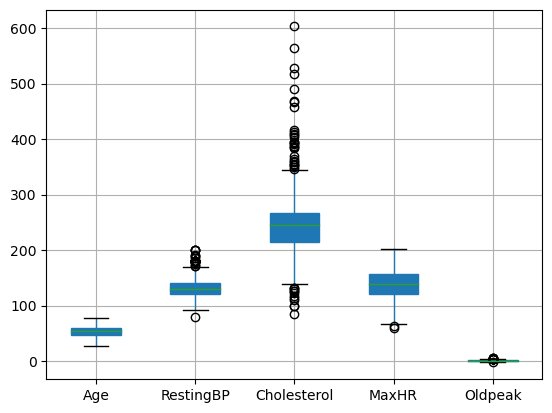

In [4]:
box=Heart.boxplot(column=['Age','RestingBP','Cholesterol','MaxHR','Oldpeak'],patch_artist=True)
colors = ['skyblue','green']
for patch, color in zip(box.artists, colors):
    patch.set_facecolor(color) # kutunun doldurma rengini ayarlar
plt.show()

### Outlier Detection

In [5]:
#from scipy import stats
#from scipy.stats import zscore
#numeric_cols = Heart.select_dtypes(include=[np.number]).columns
#numeric_cols=numeric_cols.drop(['HeartDisease','FastingBS'])
#outlier_indices = []

#for col in numeric_cols:
#    Q1 = Heart[col].quantile(0.25)
#    Q3 = Heart[col].quantile(0.75)
#    IQR = Q3 - Q1
#    lower_bound = Q1 - 1.5 * IQR
#    upper_bound = Q3 + 1.5 * IQR
#    outliers = (Heart[col] < lower_bound) | (Heart[col] > upper_bound)
#    outlier_indices.extend(Heart[outliers].index)

#outlier_indices = list(set(outlier_indices))
#Heart = Heart.drop(outlier_indices)

#z_scores = Heart.apply(zscore)
#threshold = 3
#df_clean = Heart[(np.abs(z_scores) < threshold).all(axis=1)]

In [6]:
Heart.describe()

Age   RestingBP  Cholesterol   FastingBS       MaxHR  \
count  917.000000  917.000000   917.000000  917.000000  917.000000   
mean    53.509269  132.540894   244.635389    0.233370  136.789531   
std      9.437636   17.999749    53.347125    0.423206   25.467129   
min     28.000000   80.000000    85.000000    0.000000   60.000000   
25%     47.000000  120.000000   214.000000    0.000000  120.000000   
50%     54.000000  130.000000   244.635389    0.000000  138.000000   
75%     60.000000  140.000000   267.000000    0.000000  156.000000   
max     77.000000  200.000000   603.000000    1.000000  202.000000   

          Oldpeak  HeartDisease  
count  917.000000    917.000000  
mean     0.886696      0.552890  
std      1.066960      0.497466  
min     -2.600000      0.000000  
25%      0.000000      0.000000  
50%      0.600000      1.000000  
75%      1.500000      1.000000  
max      6.200000      1.000000

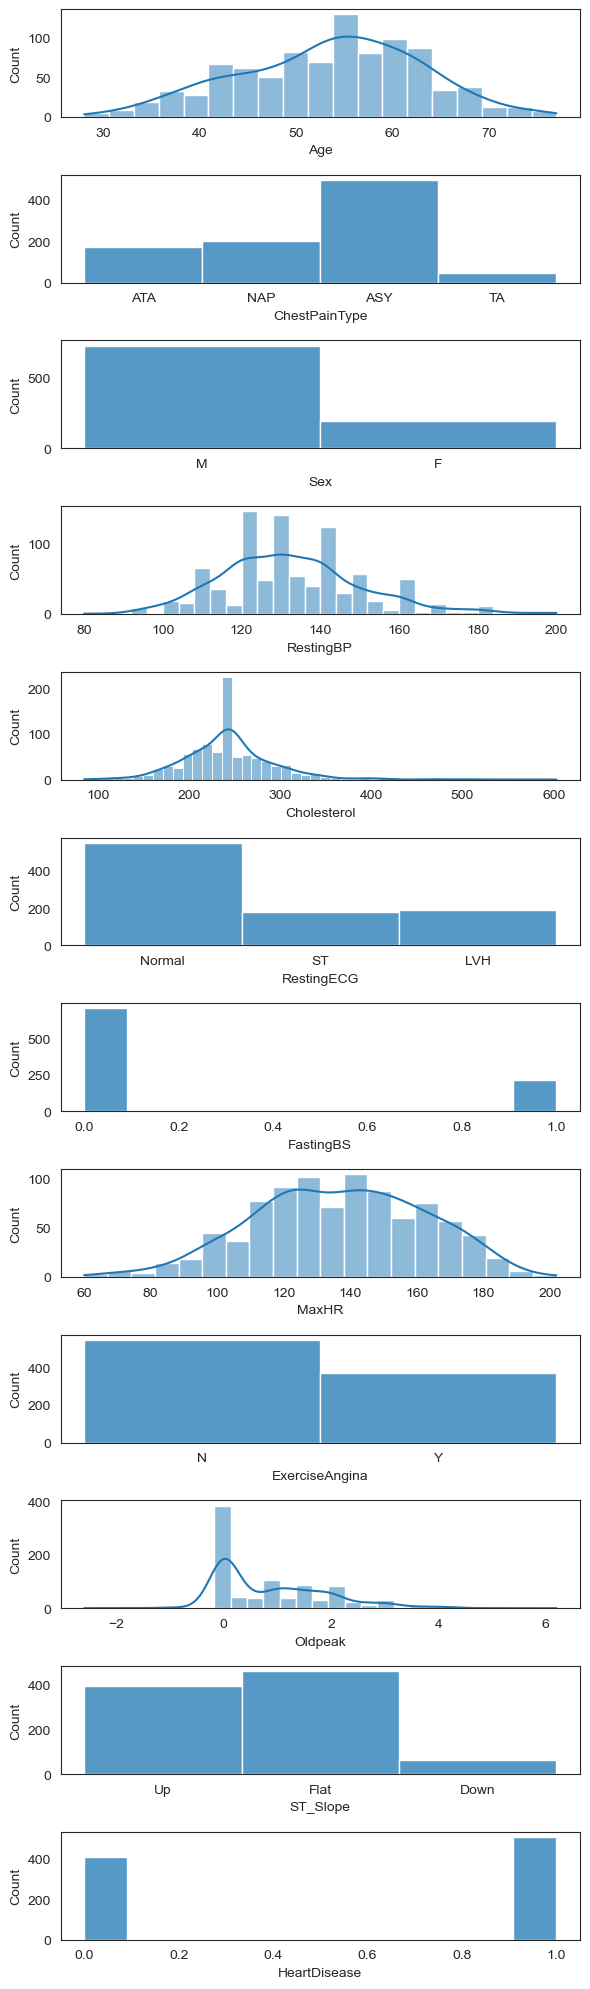

In [7]:
sns.set_style(style='white')
fig, axs = plt.subplots(12,figsize=(6,20))
sns.histplot(data=Heart, x='Age', kde=True, ax=axs[0])
sns.histplot(data=Heart, x='ChestPainType', kde=False, ax=axs[1])
sns.histplot(data=Heart, x='Sex', kde=False, ax=axs[2])
sns.histplot(data=Heart, x='RestingBP', kde=True, ax=axs[3])
sns.histplot(data=Heart, x='Cholesterol', kde=True, ax=axs[4])
sns.histplot(data=Heart, x='RestingECG', kde=False, ax=axs[5])
sns.histplot(data=Heart, x='FastingBS', kde=False, ax=axs[6])
sns.histplot(data=Heart, x='MaxHR', kde=True, ax=axs[7])
sns.histplot(data=Heart, x='ExerciseAngina', kde=False, ax=axs[8])
sns.histplot(data=Heart, x='Oldpeak', kde=True, ax=axs[9])
sns.histplot(data=Heart, x='ST_Slope', kde=False, ax=axs[10])
sns.histplot(data=Heart, x='HeartDisease', kde=False, ax=axs[11])
plt.tight_layout()
plt.show()

In [8]:
Heart.corr()

C:\Users\Van_P\AppData\Local\Temp\ipykernel_31448\2726288295.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  Heart.corr()


Age  RestingBP  Cholesterol  FastingBS     MaxHR   Oldpeak  \
Age           1.000000   0.263084     0.053374   0.198170 -0.382280  0.258563   
RestingBP     0.263084   1.000000     0.083076   0.067823 -0.109693  0.174252   
Cholesterol   0.053374   0.083076     1.000000   0.043015 -0.017244  0.053039   
FastingBS     0.198170   0.067823     0.043015   1.000000 -0.131067  0.053062   
MaxHR        -0.382280  -0.109693    -0.017244  -0.131067  1.000000 -0.161213   
Oldpeak       0.258563   0.174252     0.053039   0.053062 -0.161213  1.000000   
HeartDisease  0.282012   0.117990     0.094113   0.267994 -0.401410  0.403638   

              HeartDisease  
Age               0.282012  
RestingBP         0.117990  
Cholesterol       0.094113  
FastingBS         0.267994  
MaxHR            -0.401410  
Oldpeak           0.403638  
HeartDisease      1.000000

C:\Users\Van_P\AppData\Local\Temp\ipykernel_31448\3255860745.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = Heart.corr()


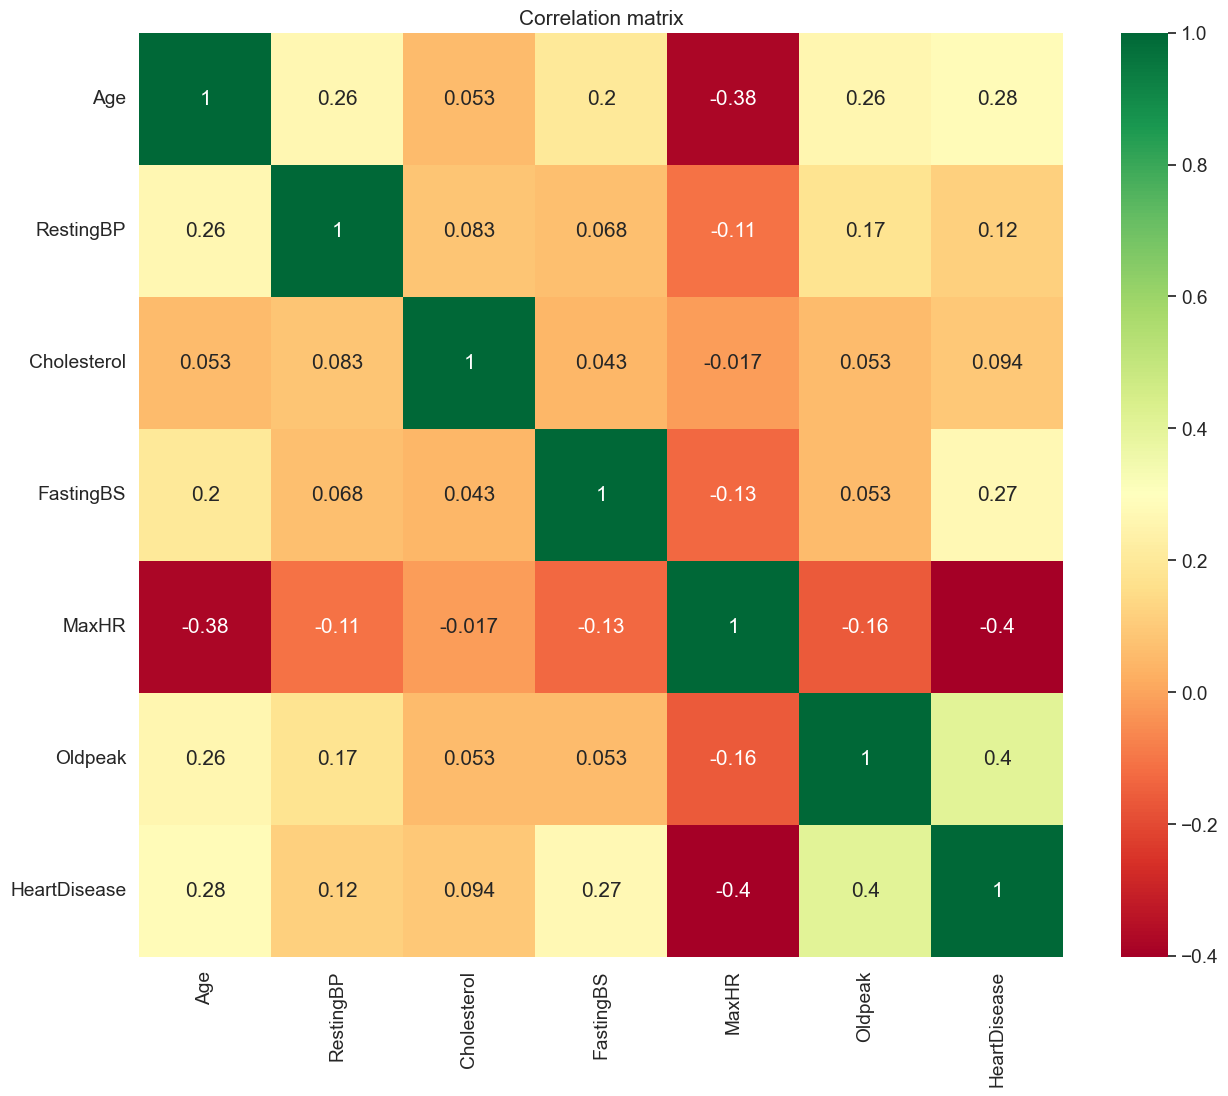

In [9]:
sns.set(font_scale = 1.25)
correlation_matrix = Heart.corr()
plt.figure(figsize=(15,12))
ax = sns.heatmap(correlation_matrix, vmax=1, square=True,annot=True,cmap='RdYlGn')
plt.title('Correlation matrix')
plt.yticks(rotation=0)
plt.xticks(rotation=90)
plt.show()

In [10]:
#Scaling
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
scaled_features = Heart.copy()
col_names = ['Age','RestingBP','Cholesterol','MaxHR','Oldpeak']
features = scaled_features[col_names]
scaler = MinMaxScaler().fit(features.values)
features = scaler.transform(features.values)
scaled_features[col_names] = features
scaled_features

Age Sex ChestPainType  RestingBP  Cholesterol  FastingBS RestingECG  \
0    0.244898   M           ATA   0.500000     0.393822          0     Normal   
1    0.428571   F           NAP   0.666667     0.183398          0     Normal   
2    0.183673   M           ATA   0.416667     0.382239          0         ST   
3    0.408163   F           ASY   0.483333     0.249035          0     Normal   
4    0.530612   M           NAP   0.583333     0.212355          0     Normal   
..        ...  ..           ...        ...          ...        ...        ...   
913  0.346939   M            TA   0.250000     0.345560          0     Normal   
914  0.816327   M           ASY   0.533333     0.208494          1     Normal   
915  0.591837   M           ASY   0.416667     0.088803          0     Normal   
916  0.591837   F           ATA   0.416667     0.291506          0        LVH   
917  0.204082   M           NAP   0.483333     0.173745          0     Normal   

        MaxHR ExerciseAngina   Oldpeak ST_Slope  HeartDisease  
0    0.788732              N  0.295455       Up             0  
1    0.676056              N  0.409091     Flat             1  
2    0.267606              N  0.295455       Up             0  
3    0.338028              Y  0.465909     Flat             1  
4    0.436620              N  0.295455       Up             0  
..        ...            ...       ...      ...           ...  
913  0.507042              N  0.431818     Flat             1  
914  0.570423              N  0.681818     Flat             1  
915  0.387324              Y  0.431818     Flat             1  
916  0.802817              N  0.295455     Flat             1  
917  0.795775              N  0.295455       Up             0  

[917 rows x 12 columns]

In [11]:
from sklearn.preprocessing import OneHotEncoder
onhe = OneHotEncoder(drop="if_binary",sparse=False, handle_unknown= "ignore")
enco = onhe.fit_transform(scaled_features[["Sex","ChestPainType","RestingECG","FastingBS","ExerciseAngina","ST_Slope"]])
enco = pd.DataFrame(enco, columns= onhe.get_feature_names_out(["Sex","ChestPainType","RestingECG","FastingBS","ExerciseAngina","ST_Slope"]))

Heart1=pd.concat([scaled_features.reset_index(), enco], axis = 1)
Heart1=Heart1.drop(['index','Sex','ChestPainType','RestingECG','FastingBS','ExerciseAngina','ST_Slope'],axis=1)
Heart1

C:\Users\Van_P\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Age  RestingBP  Cholesterol     MaxHR   Oldpeak  HeartDisease  \
0    0.244898   0.500000     0.393822  0.788732  0.295455             0   
1    0.428571   0.666667     0.183398  0.676056  0.409091             1   
2    0.183673   0.416667     0.382239  0.267606  0.295455             0   
3    0.408163   0.483333     0.249035  0.338028  0.465909             1   
4    0.530612   0.583333     0.212355  0.436620  0.295455             0   
..        ...        ...          ...       ...       ...           ...   
912  0.346939   0.250000     0.345560  0.507042  0.431818             1   
913  0.816327   0.533333     0.208494  0.570423  0.681818             1   
914  0.591837   0.416667     0.088803  0.387324  0.431818             1   
915  0.591837   0.416667     0.291506  0.802817  0.295455             1   
916  0.204082   0.483333     0.173745  0.795775  0.295455             0   

     Sex_M  ChestPainType_ASY  ChestPainType_ATA  ChestPainType_NAP  \
0      1.0                0.0                1.0                0.0   
1      0.0                0.0                0.0                1.0   
2      1.0                0.0                1.0                0.0   
3      0.0                1.0                0.0                0.0   
4      1.0                0.0                0.0                1.0   
..     ...                ...                ...                ...   
912    1.0                0.0                0.0                0.0   
913    1.0                1.0                0.0                0.0   
914    1.0                1.0                0.0                0.0   
915    0.0                0.0                1.0                0.0   
916    1.0                0.0                0.0                1.0   

     ChestPainType_TA  RestingECG_LVH  RestingECG_Normal  RestingECG_ST  \
0                 0.0             0.0                1.0            0.0   
1                 0.0             0.0                1.0            0.0   
2                 0.0             0.0                0.0            1.0   
3                 0.0             0.0                1.0            0.0   
4                 0.0             0.0                1.0            0.0   
..                ...             ...                ...            ...   
912               1.0             0.0                1.0            0.0   
913               0.0             0.0                1.0            0.0   
914               0.0             0.0                1.0            0.0   
915               0.0             1.0                0.0            0.0   
916               0.0             0.0                1.0            0.0   

     FastingBS_1  ExerciseAngina_Y  ST_Slope_Down  ST_Slope_Flat  ST_Slope_Up  
0            0.0               0.0            0.0            0.0          1.0  
1            0.0               0.0            0.0            1.0          0.0  
2            0.0               0.0            0.0            0.0          1.0  
3            0.0               1.0            0.0            1.0          0.0  
4            0.0               0.0            0.0            0.0          1.0  
..           ...               ...            ...            ...          ...  
912          0.0               0.0            0.0            1.0          0.0  
913          1.0               0.0            0.0            1.0          0.0  
914          0.0               1.0            0.0            1.0          0.0  
915          0.0               0.0            0.0            1.0          0.0  
916          0.0               0.0            0.0            0.0          1.0  

[917 rows x 19 columns]

In [12]:
Heart1.corr()

Age  RestingBP  Cholesterol     MaxHR   Oldpeak  \
Age                1.000000   0.263084     0.053374 -0.382280  0.258563   
RestingBP          0.263084   1.000000     0.083076 -0.109693  0.174252   
Cholesterol        0.053374   0.083076     1.000000 -0.017244  0.053039   
MaxHR             -0.382280  -0.109693    -0.017244  1.000000 -0.161213   
Oldpeak            0.258563   0.174252     0.053039 -0.161213  1.000000   
HeartDisease       0.282012   0.117990     0.094113 -0.401410  0.403638   
Sex_M              0.055670   0.009427    -0.101721 -0.189668  0.105444   
ChestPainType_ASY  0.166903   0.041568     0.084587 -0.354444  0.280936   
ChestPainType_ATA -0.218113  -0.051374    -0.015290  0.254214 -0.261903   
ChestPainType_NAP -0.011681  -0.027536    -0.062349  0.133411 -0.107615   
ChestPainType_TA   0.032083   0.049464    -0.047323  0.100235  0.032382   
RestingECG_LVH     0.145837   0.050648     0.075495  0.126242  0.087140   
RestingECG_Normal -0.230793  -0.113759    -0.042422  0.023181 -0.117293   
RestingECG_ST      0.136903   0.089156    -0.024534 -0.157561  0.056283   
FastingBS_1        0.198170   0.067823     0.043015 -0.131067  0.053062   
ExerciseAngina_Y   0.216017   0.153064     0.077578 -0.370023  0.409494   
ST_Slope_Down      0.138451  -0.010323    -0.008920 -0.073127  0.322371   
ST_Slope_Flat      0.185499   0.110171     0.093678 -0.343641  0.282874   
ST_Slope_Up       -0.258027  -0.105969    -0.090032  0.384339 -0.450299   

                   HeartDisease     Sex_M  ChestPainType_ASY  \
Age                    0.282012  0.055670           0.166903   
RestingBP              0.117990  0.009427           0.041568   
Cholesterol            0.094113 -0.101721           0.084587   
MaxHR                 -0.401410 -0.189668          -0.354444   
Oldpeak                0.403638  0.105444           0.280936   
HeartDisease           1.000000  0.305118           0.518339   
Sex_M                  0.305118  1.000000           0.184631   
ChestPainType_ASY      0.518339  0.184631           1.000000   
ChestPainType_ATA     -0.401680 -0.161294          -0.523403   
ChestPainType_NAP     -0.215311 -0.067682          -0.576929   
ChestPainType_TA      -0.054591 -0.003903          -0.249442   
RestingECG_LVH         0.011174 -0.049246           0.001691   
RestingECG_Normal     -0.092452 -0.011098          -0.062707   
RestingECG_ST          0.103067  0.064009           0.075916   
FastingBS_1            0.267994  0.120424           0.130629   
ExerciseAngina_Y       0.495490  0.191226           0.429495   
ST_Slope_Down          0.122852  0.066201           0.103157   
ST_Slope_Flat          0.553700  0.115596           0.305186   
ST_Slope_Up           -0.621843 -0.150537          -0.360850   

                   ChestPainType_ATA  ChestPainType_NAP  ChestPainType_TA  \
Age                        -0.218113          -0.011681          0.032083   
RestingBP                  -0.051374          -0.027536          0.049464   
Cholesterol                -0.015290          -0.062349         -0.047323   
MaxHR                       0.254214           0.133411          0.100235   
Oldpeak                    -0.261903          -0.107615          0.032382   
HeartDisease               -0.401680          -0.215311         -0.054591   
Sex_M                      -0.161294          -0.067682         -0.003903   
ChestPainType_ASY          -0.523403          -0.576929         -0.249442   
ChestPainType_ATA           1.000000          -0.256306         -0.110817   
ChestPainType_NAP          -0.256306           1.000000         -0.122150   
ChestPainType_TA           -0.110817          -0.122150          1.000000   
RestingECG_LVH             -0.086081           0.036413          0.081293   
RestingECG_Normal           0.108422           0.003352         -0.057538   
RestingECG_ST              -0.046381          -0.041317         -0.011736   
FastingBS_1                -0.140844          -0.038201          0.026752   
ExerciseAn

In [13]:
X=Heart1.loc[:,Heart1.columns!='HeartDisease']
y=Heart1.loc[:,Heart1.columns=='HeartDisease']

### Feature Selection and One of the trial

In [50]:
from sklearn.feature_selection import RFE
from sklearn.svm import SVC
model = SVC(kernel="linear")
no_features = 15
rfe = RFE(model, n_features_to_select=no_features)
rfe = rfe.fit(X, y)
X_train_rfe = rfe.transform(X_train)
X_test_rfe = rfe.transform(X_test)

C:\Users\Van_P\anaconda3\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Van_P\anaconda3\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Van_P\anaconda3\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Van_P\anaconda3\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,

In [51]:
LGB = lgb.LGBMClassifier(max_depth=10,num_leaves=10,n_estimators=20,random_state=0,learning_rate=0.1,reg_alpha = 0.1,
                        reg_lambda = 0.5,subsample= 0.1,tree_learner = "voting",colsample_bytree = 0.43)
LGB.fit(X_train_rfe, y_train)
pred_lgb = LGB.predict(X_test_rfe) #make prediction on test set

C:\Users\Van_P\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:99: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Van_P\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


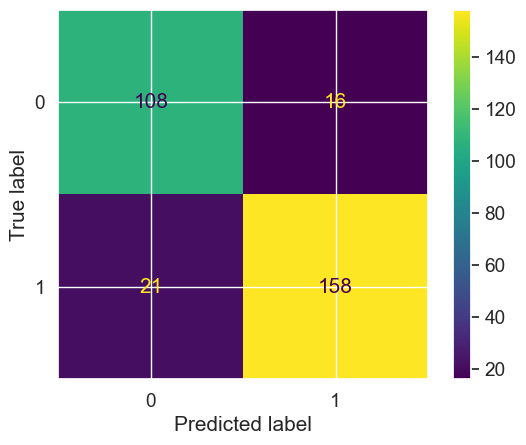

True Negatives:  108
False Positives:  16
False Negatives:  21
True Positives:  158
Accuracy: 0.8778877887788779
Precision: 0.9080459770114943
F1: 0.8951841359773371
MCCC: 0.7494405408038276


In [53]:
cm = confusion_matrix(y_test, pred_lgb, labels=LGB.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                display_labels=LGB.classes_)
disp.plot()
plt.show()
tp, fn, fp, tn = confusion_matrix(y_true = y_test, y_pred = pred_lgb, labels=[1,0]).reshape(-1)
print("True Negatives: ",tn)
print("False Positives: ",fp)
print("False Negatives: ",fn)
print("True Positives: ",tp)

accuray_lgb = accuracy_score(y_test,pred_lgb)
print("Accuracy:", accuray_lgb)
precision_lgb = precision_score(y_test, pred_lgb)
print("Precision:", precision_lgb)
f1_lgb=f1_score(y_test, pred_lgb)
print("F1:", f1_lgb)
mcc_lgb = matthews_corrcoef(y_test, pred_lgb)
print("MCCC:", mcc_lgb)

In [17]:
# Creating  and test dataset
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=1)

In [18]:
LGB = lgb.LGBMClassifier(max_depth=10,num_leaves=10,n_estimators=20,random_state=0,learning_rate=0.1,reg_alpha = 0.1,
                        reg_lambda = 0.5,subsample= 0.1,tree_learner = "voting",colsample_bytree = 0.43)
LGB.fit(X_train, y_train)
pred_lgb = LGB.predict(X_test) #make prediction on test set

C:\Users\Van_P\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:99: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Van_P\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


In [19]:
from sklearn.model_selection import GridSearchCV
def algorithm_pipeline(X_train_data, X_test_data, y_train_data, y_test_data, 
                       model, param_grid, cv=5, scoring_fit='accuracy',
                       do_probabilities = False):
    gs = GridSearchCV(
        estimator=model,
        param_grid=param_grid, 
        cv=cv, 
        n_jobs=-1, 
        scoring=scoring_fit,
        verbose=1
    )
    fitted_model = gs.fit(X_train_data, y_train_data)
    if do_probabilities:
      pred = fitted_model.predict_proba(X_test_data)
    else:
      pred = fitted_model.predict(X_test_data)
    return fitted_model, pred

In [20]:
import time
model = LGB
start=time.time()
param_grid = {'max_depth': [5,7,10,14,20],
             'num_leaves':[10,20,30,50,100],
             'n_estimators':[10,20,40,50],
              'learning_rate':[0.05,0.1,0.15,0.2]}

model, pred = algorithm_pipeline(X_train, X_test, y_train, y_test, model, 
                                 param_grid, cv=5)
end = time.time()
print(model.best_score_)
print(model.best_params_)
print("Time Taken with GridSearchCV:", end-start)

Fitting 5 folds for each of 400 candidates, totalling 2000 fits
0.876222844195655
{'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 40, 'num_leaves': 20}
Time Taken with GridSearchCV: 11.850368976593018


C:\Users\Van_P\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:99: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Van_P\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


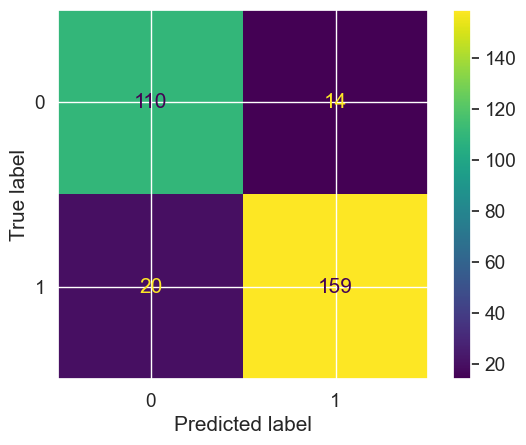

True Negatives:  110
False Positives:  14
False Negatives:  20
True Positives:  159
Accuracy: 0.8877887788778878
Precision: 0.9190751445086706
F1: 0.9034090909090909
MCCC: 0.7702802887598925


In [21]:
#LGB RESULTS
from sklearn.metrics import precision_score
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import matthews_corrcoef
cm = confusion_matrix(y_test, pred_lgb, labels=LGB.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=LGB.classes_)
disp.plot()
plt.show()
tp, fn, fp, tn = confusion_matrix(y_true = y_test, y_pred = pred_lgb, labels=[1,0]).reshape(-1)
print("True Negatives: ",tn)
print("False Positives: ",fp)
print("False Negatives: ",fn)
print("True Positives: ",tp)

accuray_lgb = accuracy_score(y_test,pred_lgb)
print("Accuracy:", accuray_lgb)
precision_lgb = precision_score(y_test, pred_lgb)
print("Precision:", precision_lgb)
f1_lgb=f1_score(y_test, pred_lgb)
print("F1:", f1_lgb)
mcc_lgb = matthews_corrcoef(y_test, pred_lgb)
print("MCCC:", mcc_lgb)

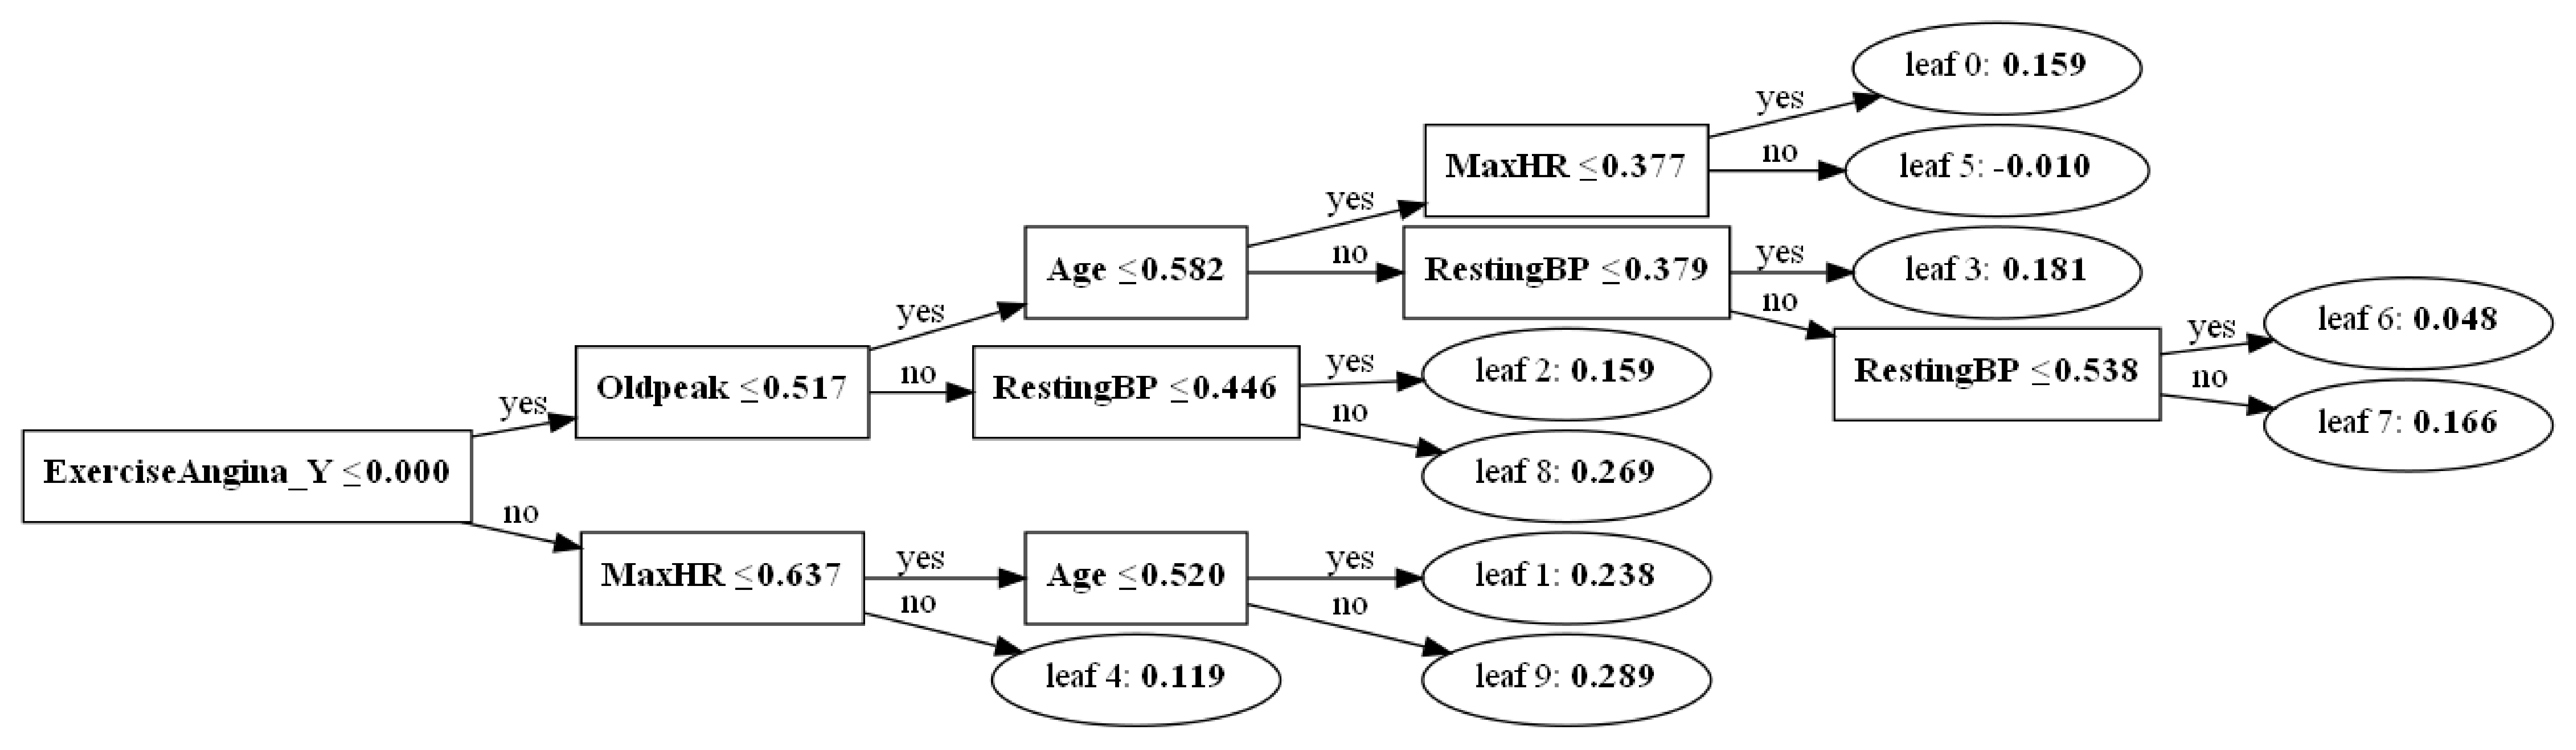

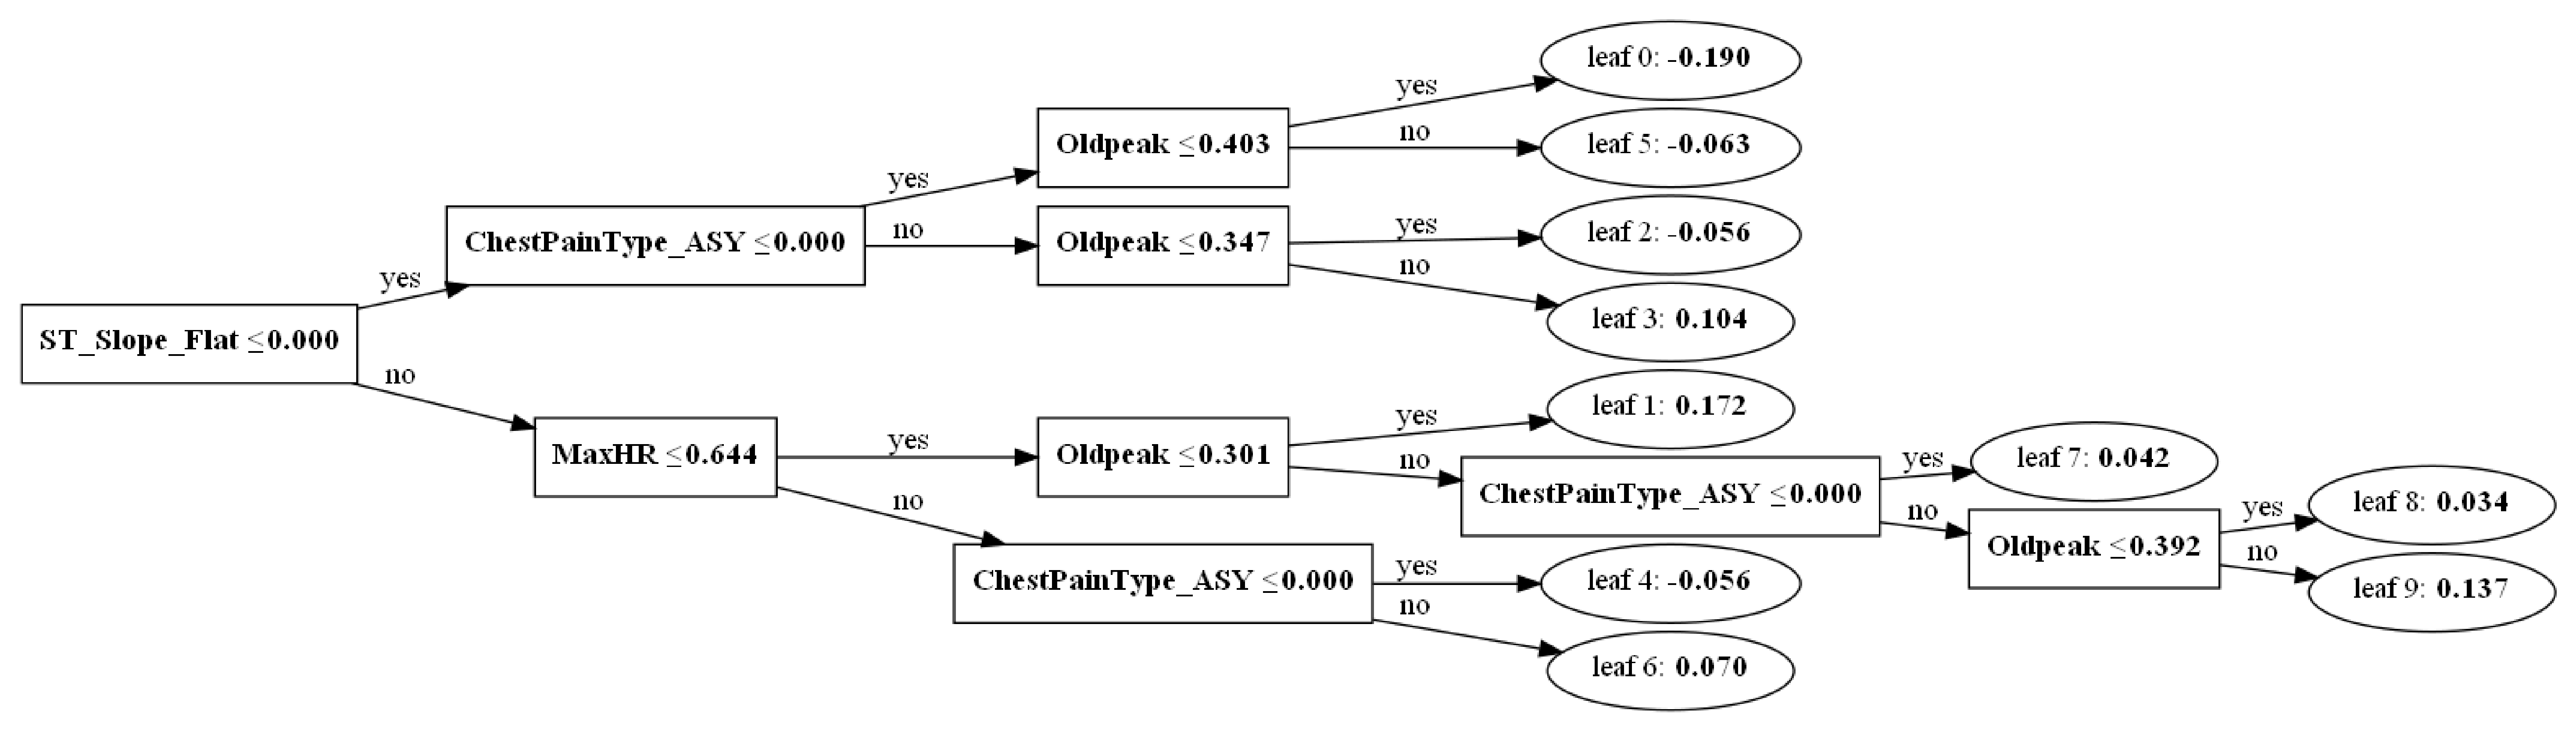

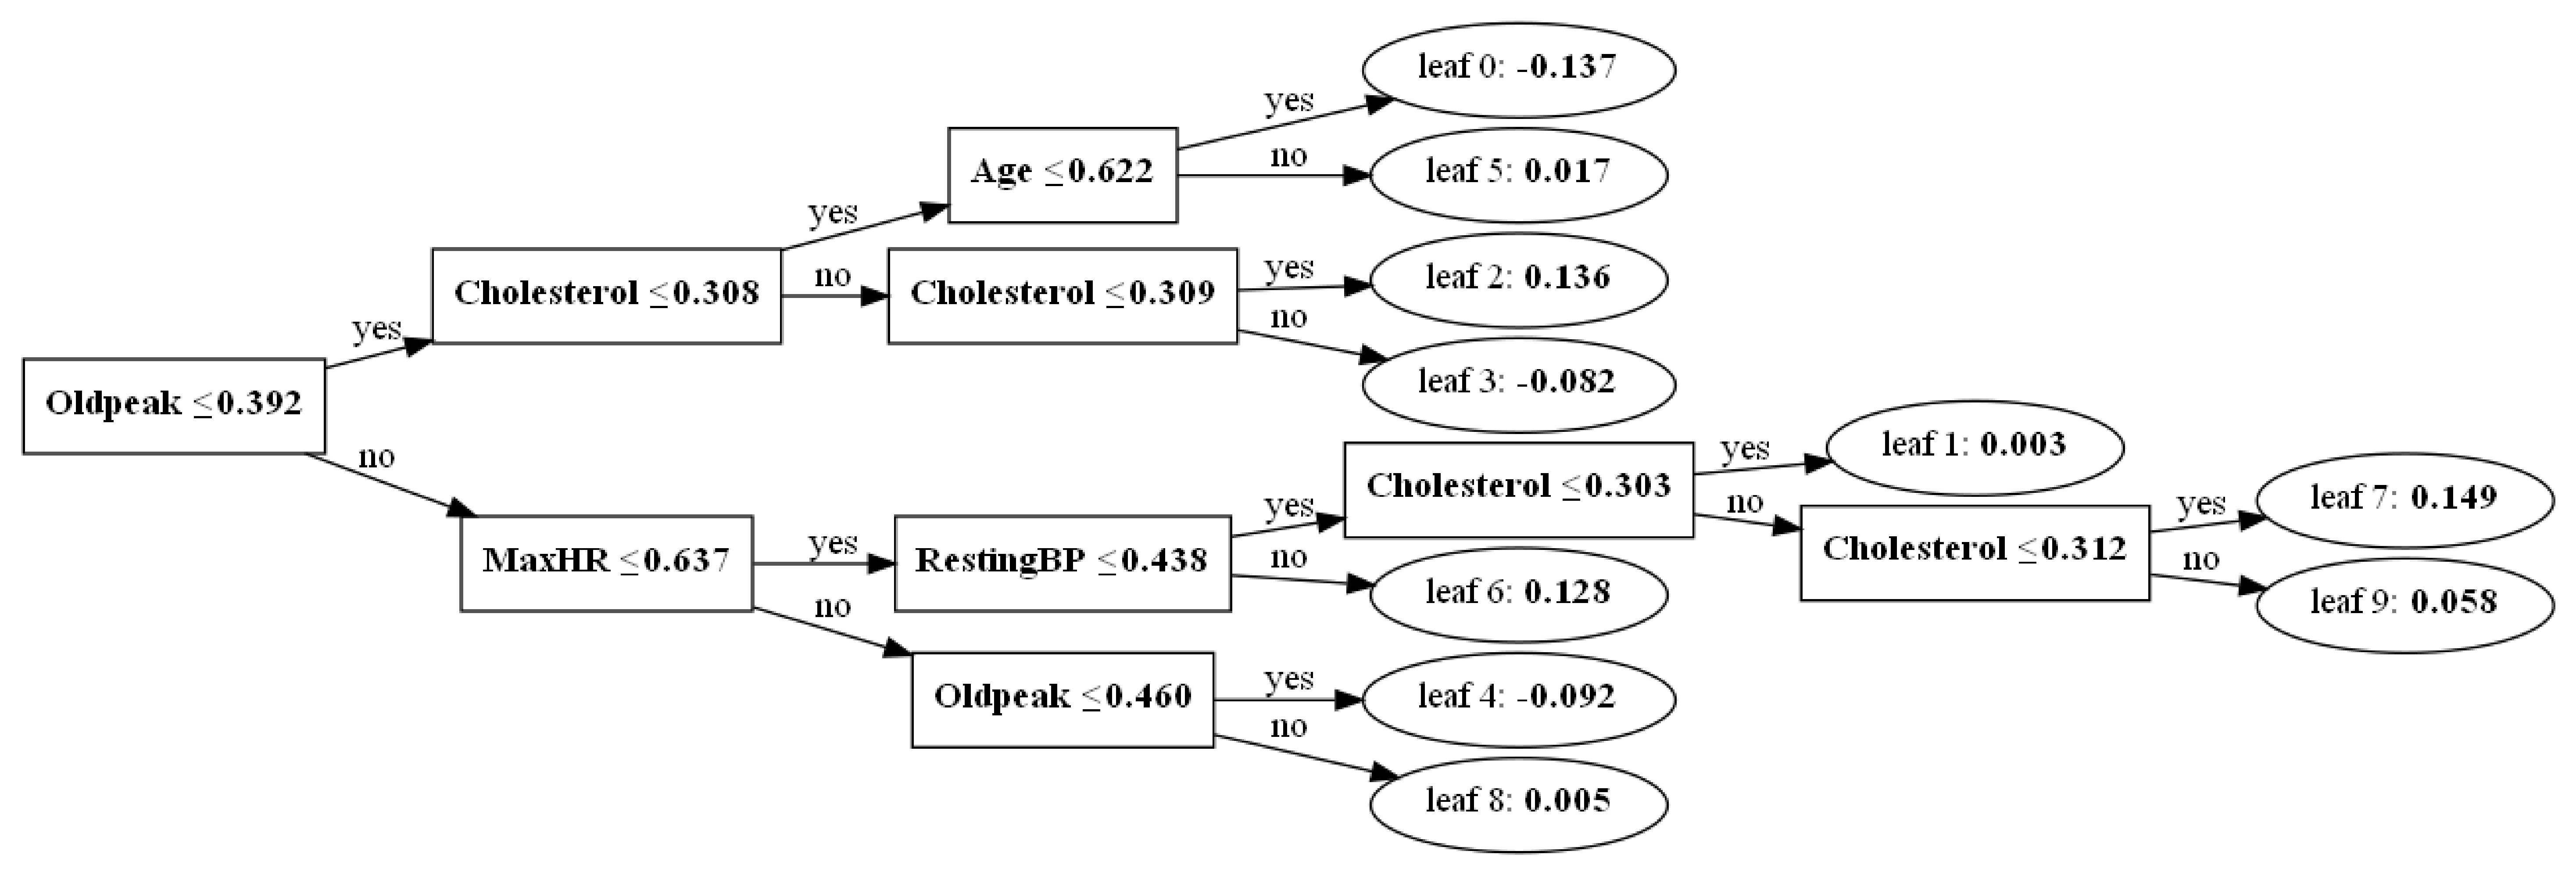

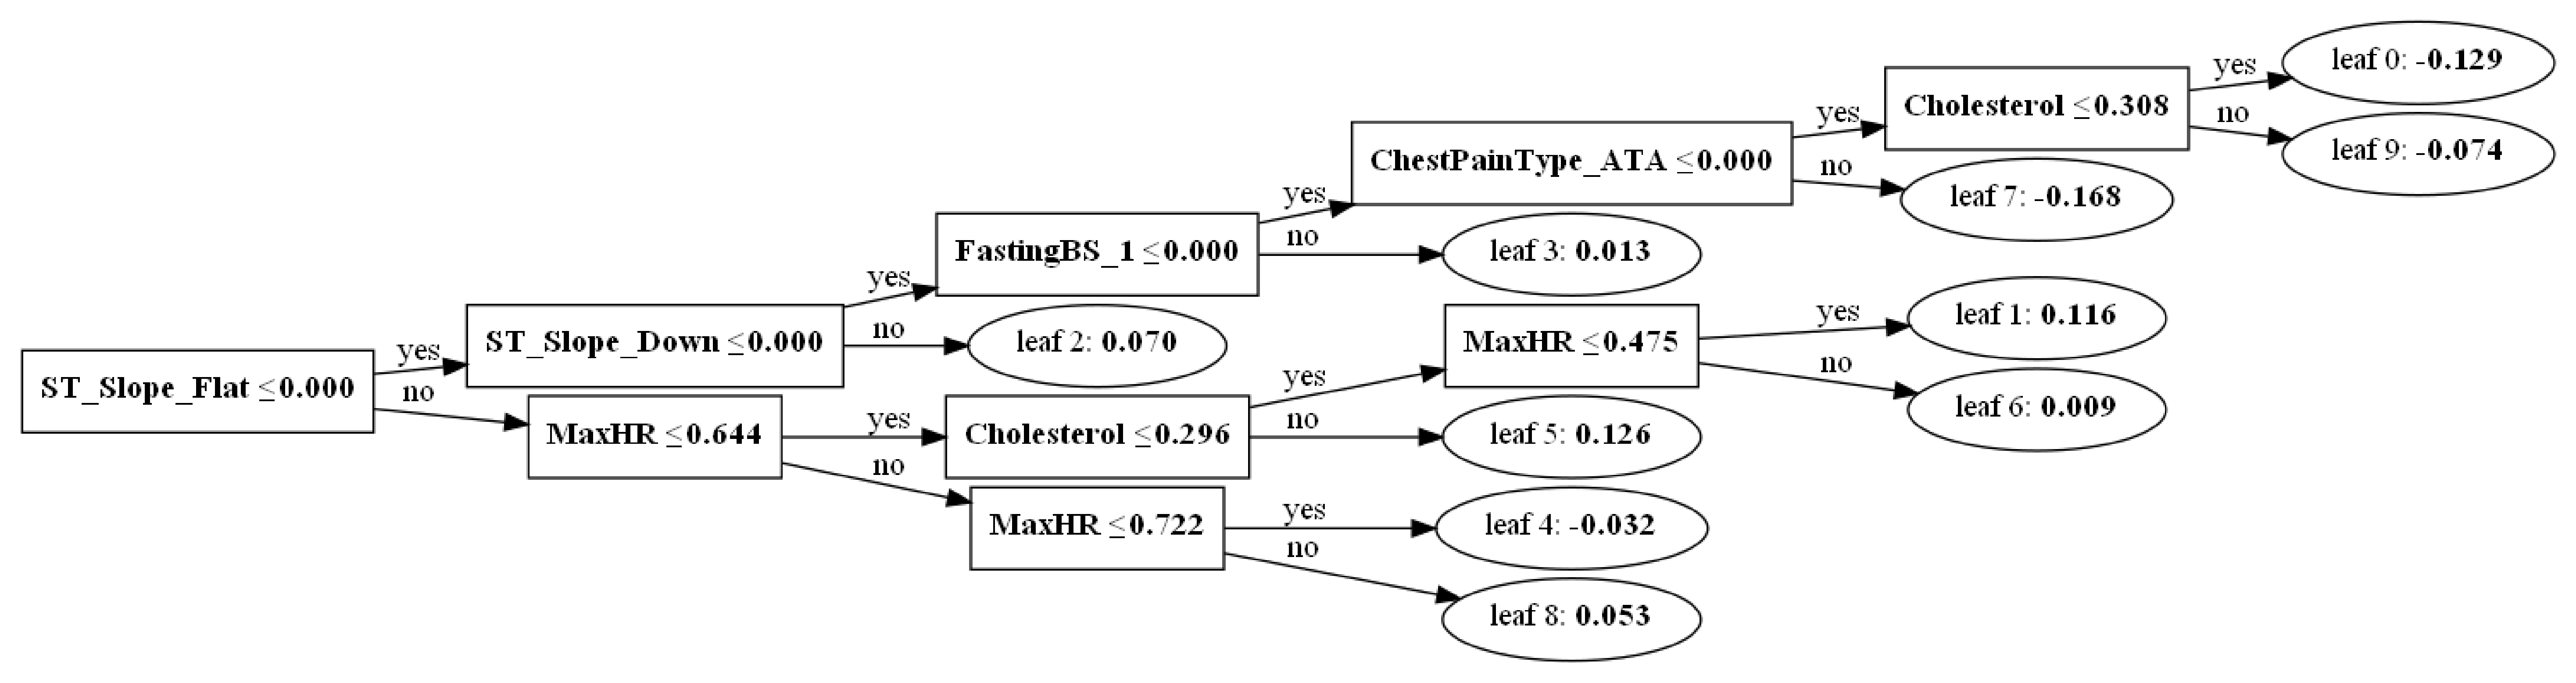

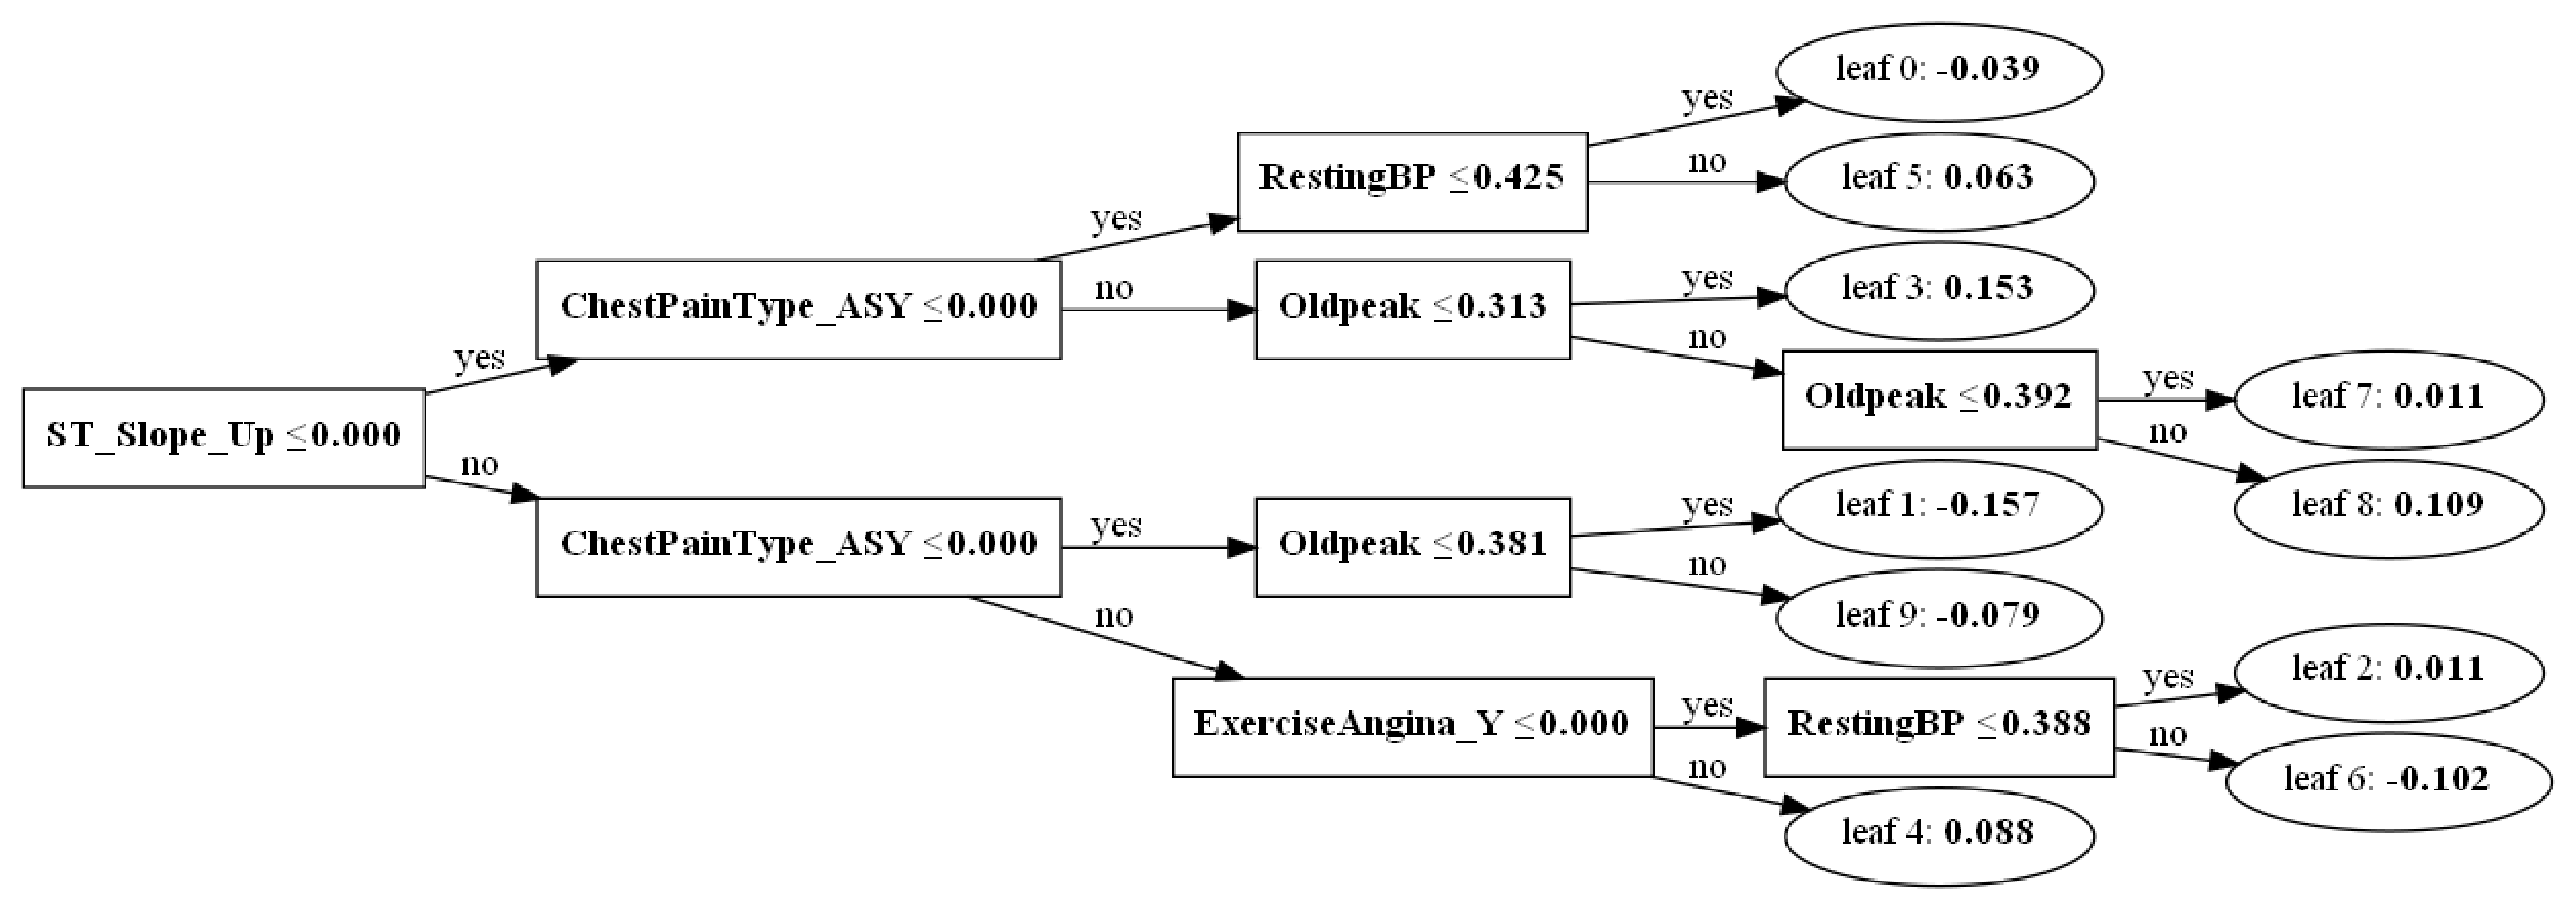

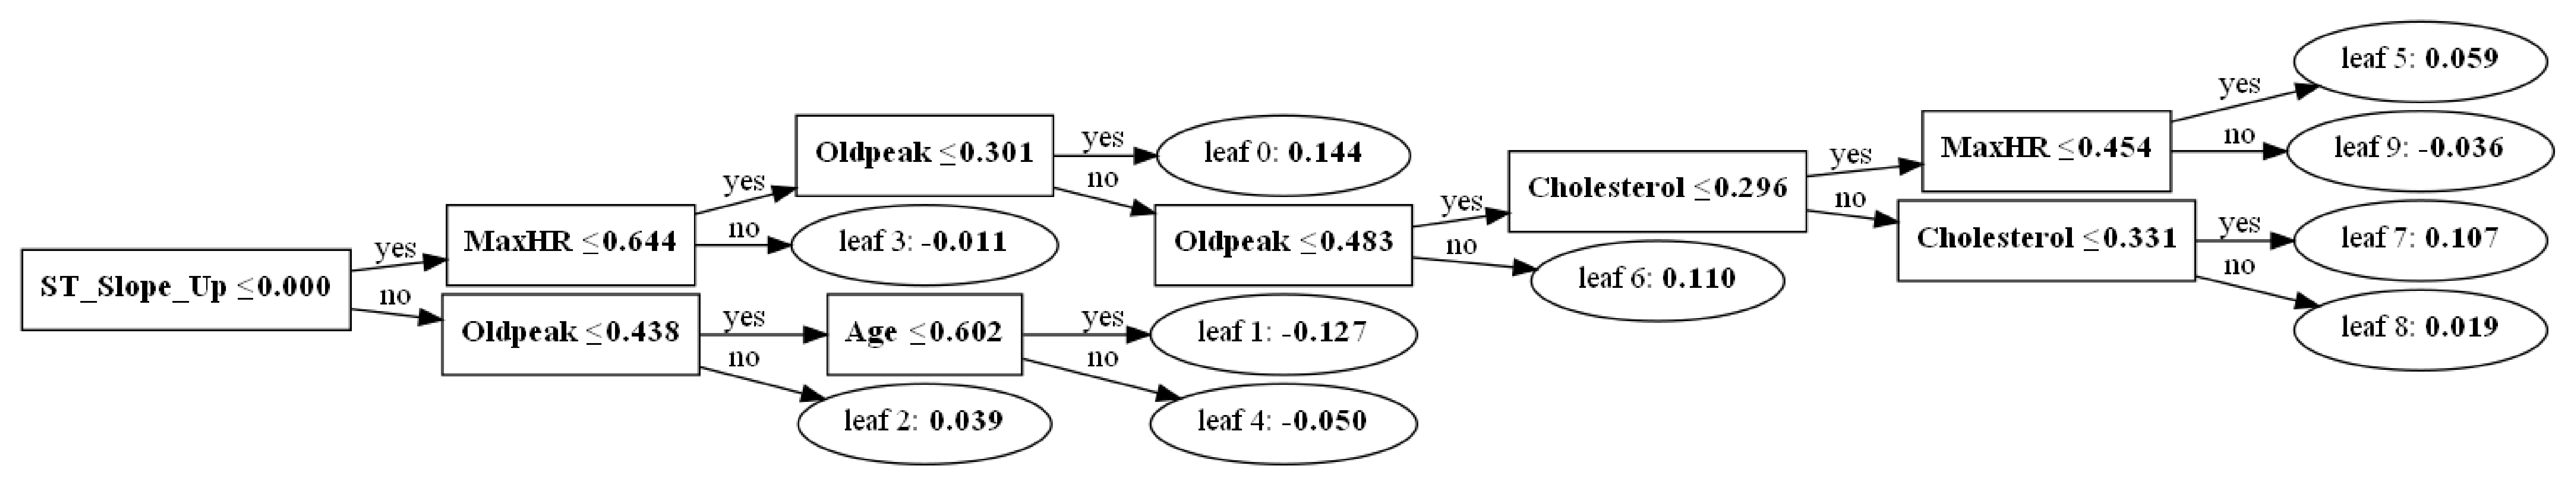

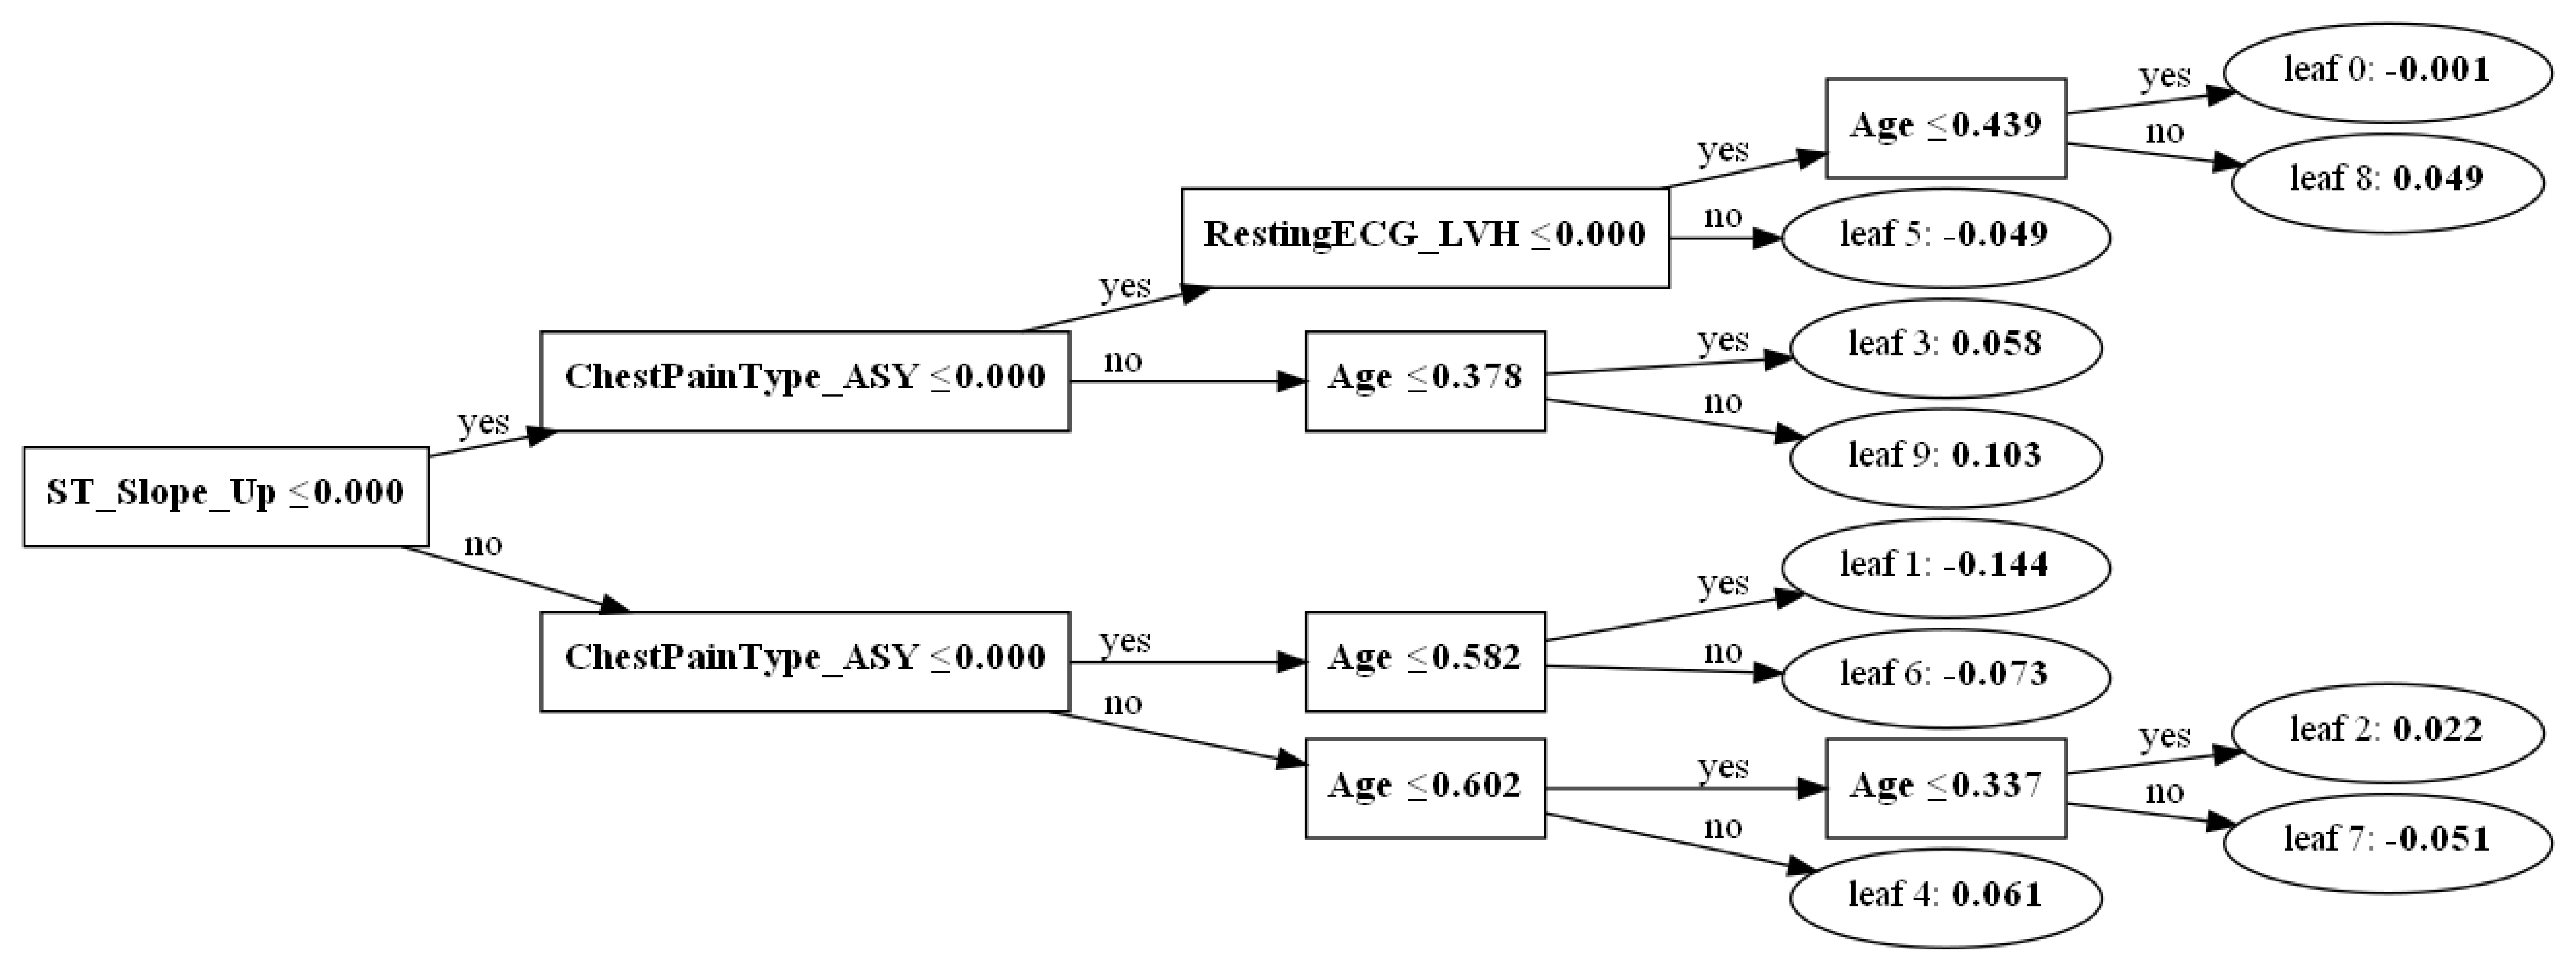

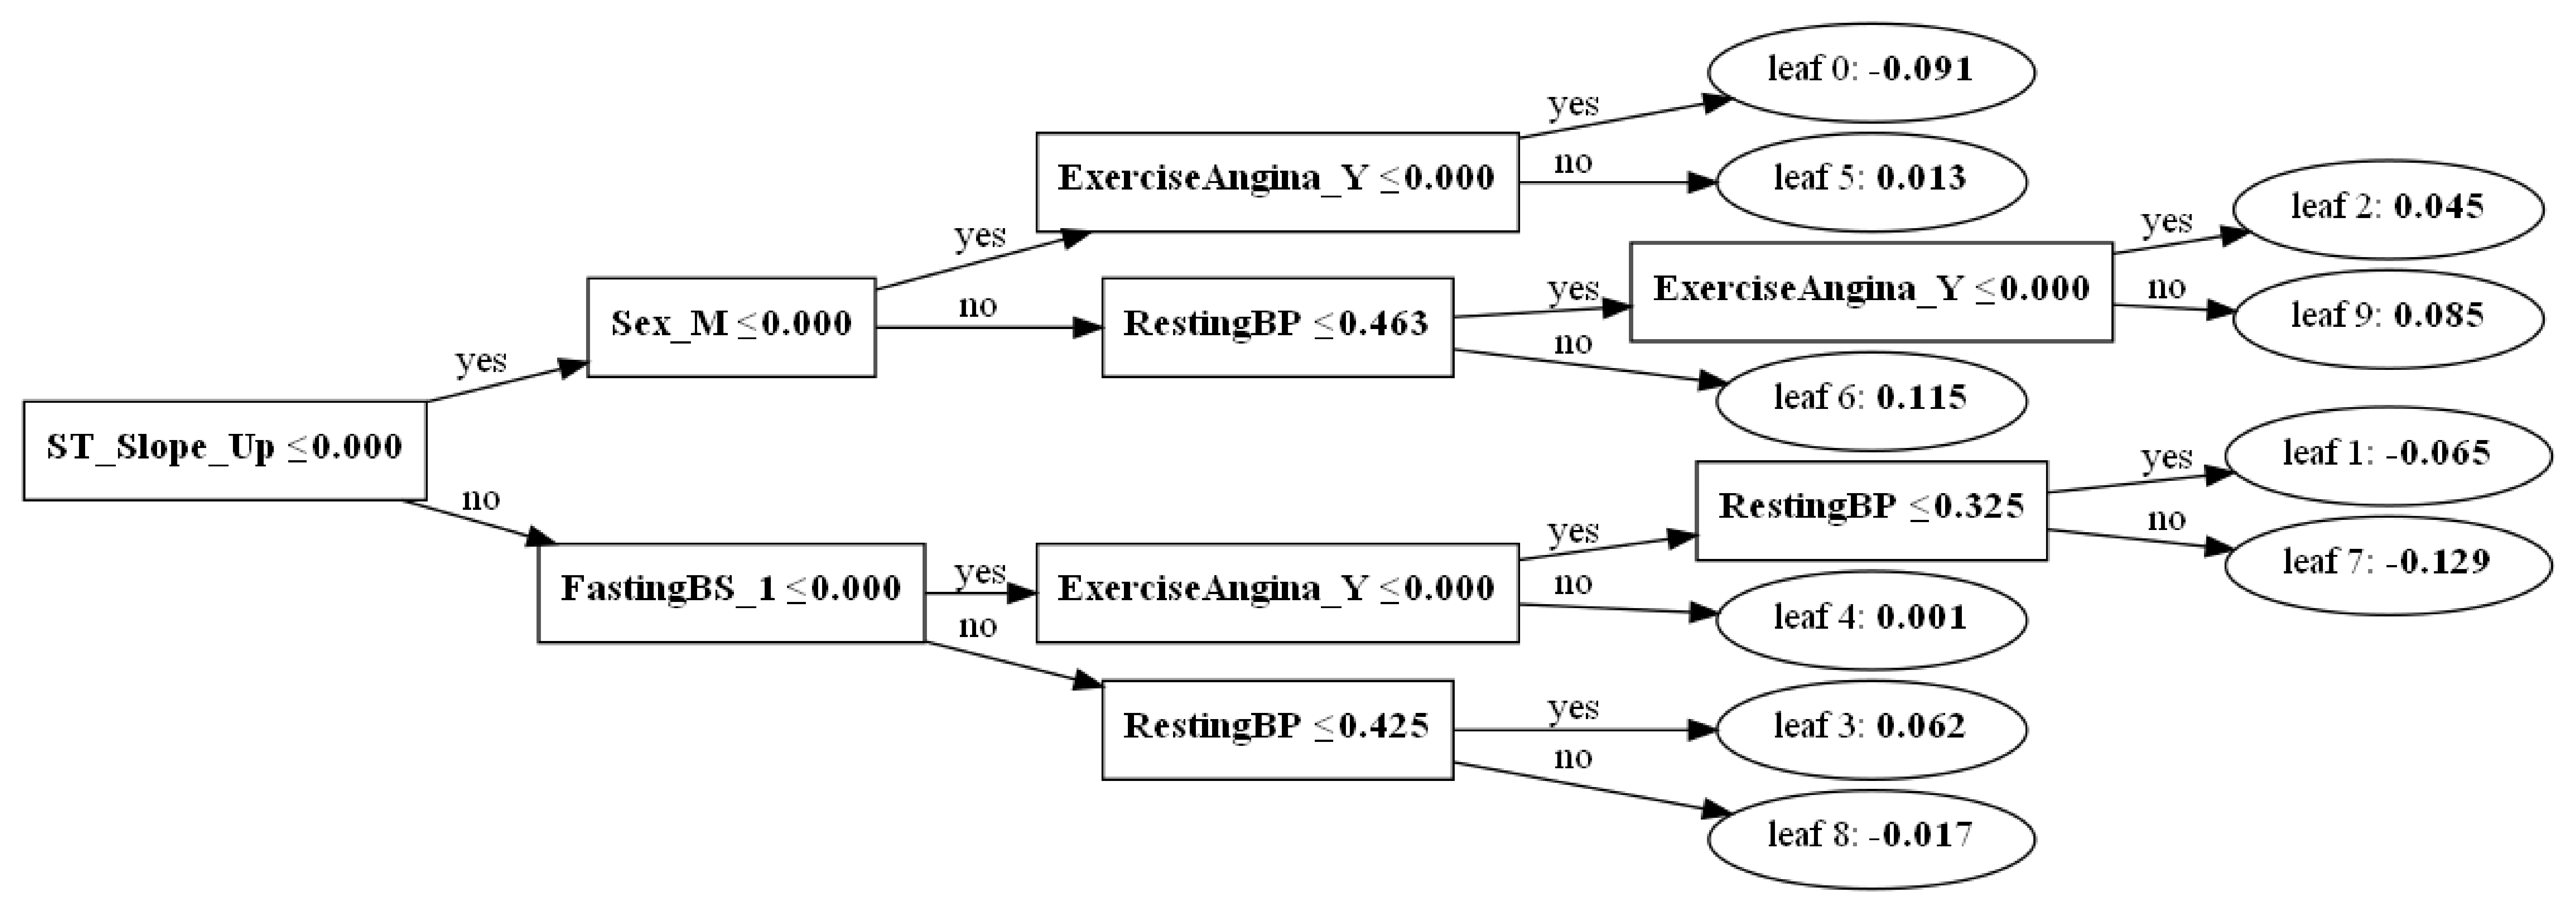

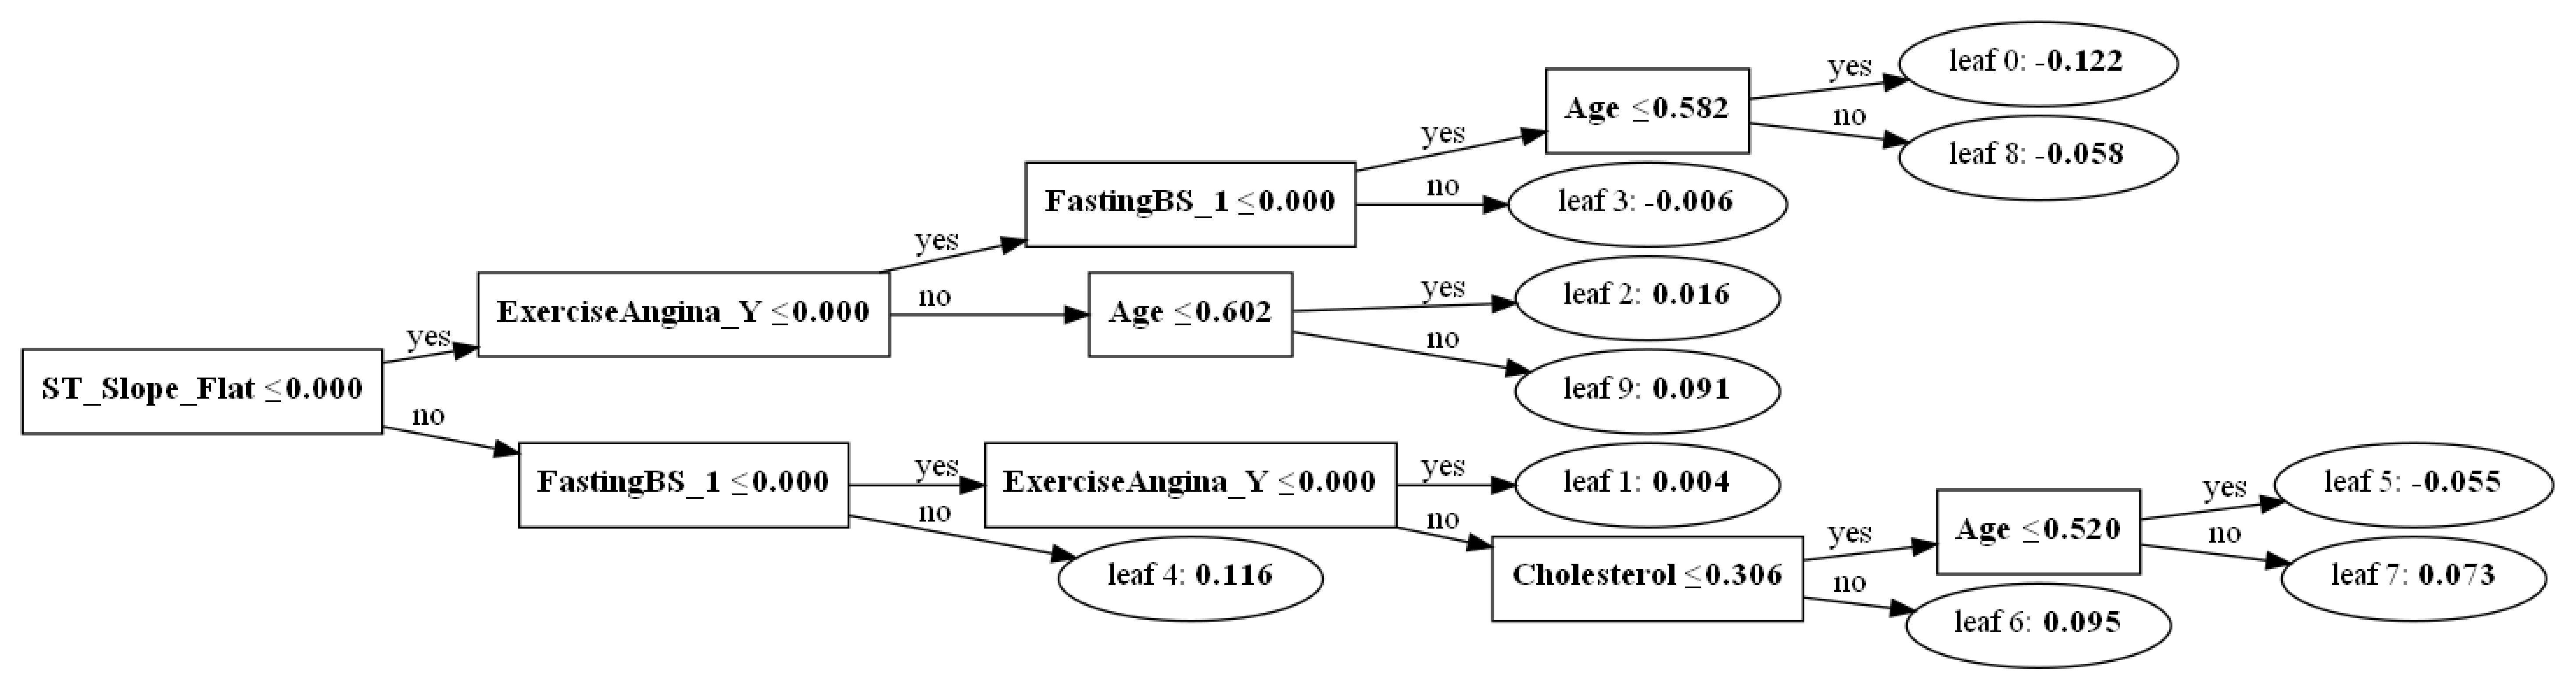

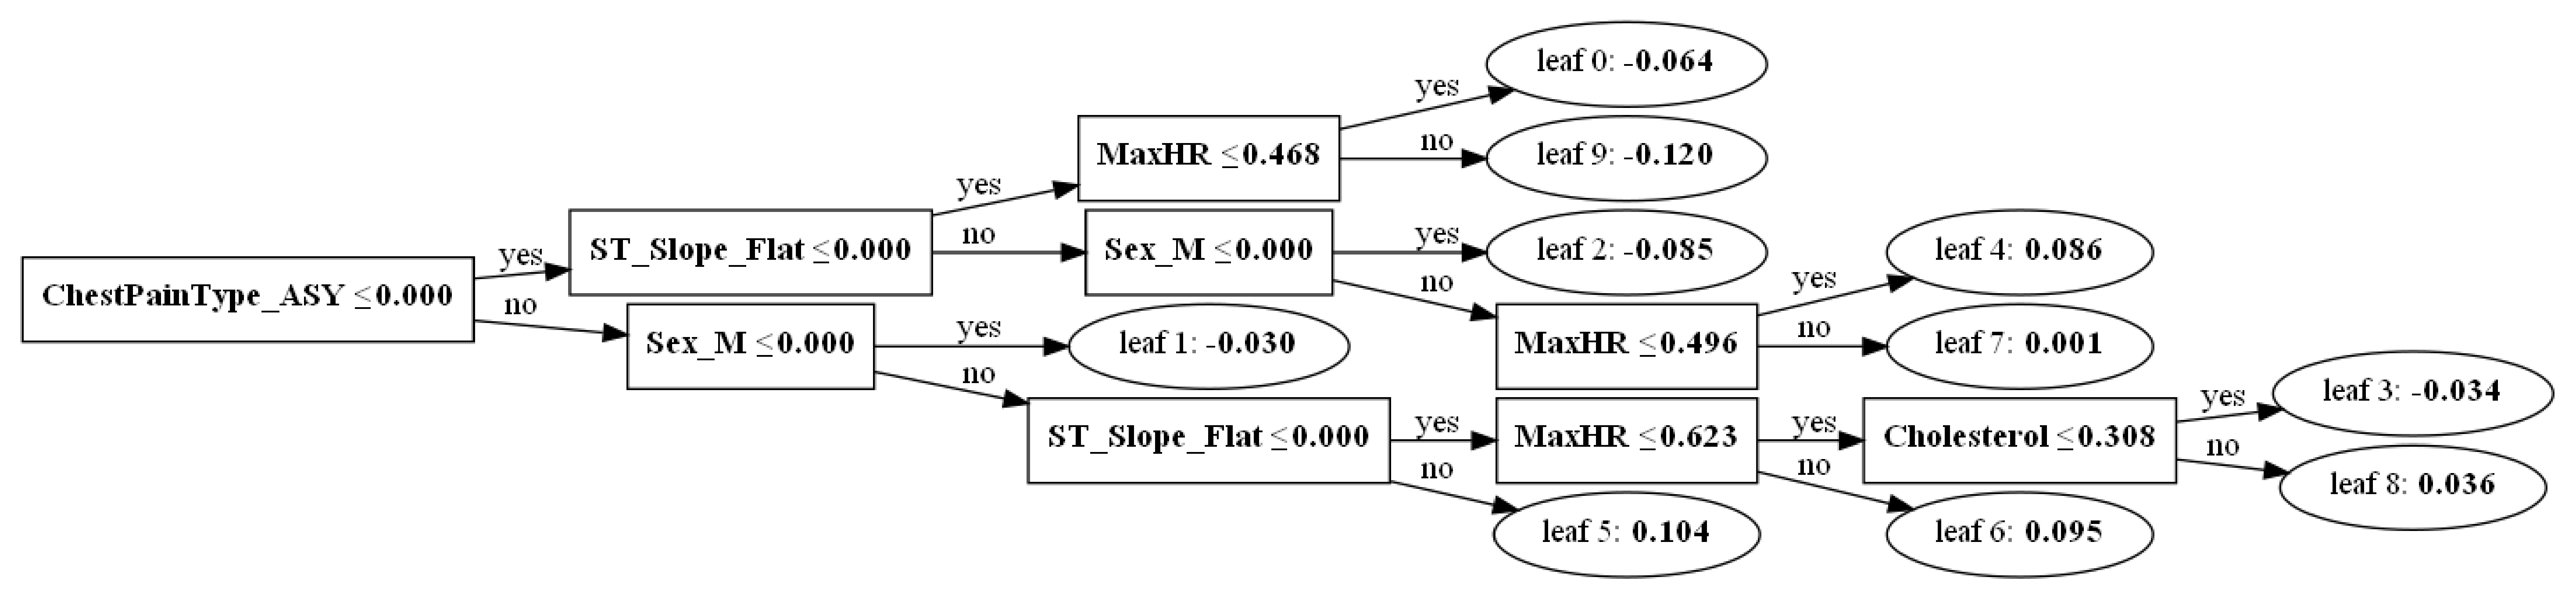

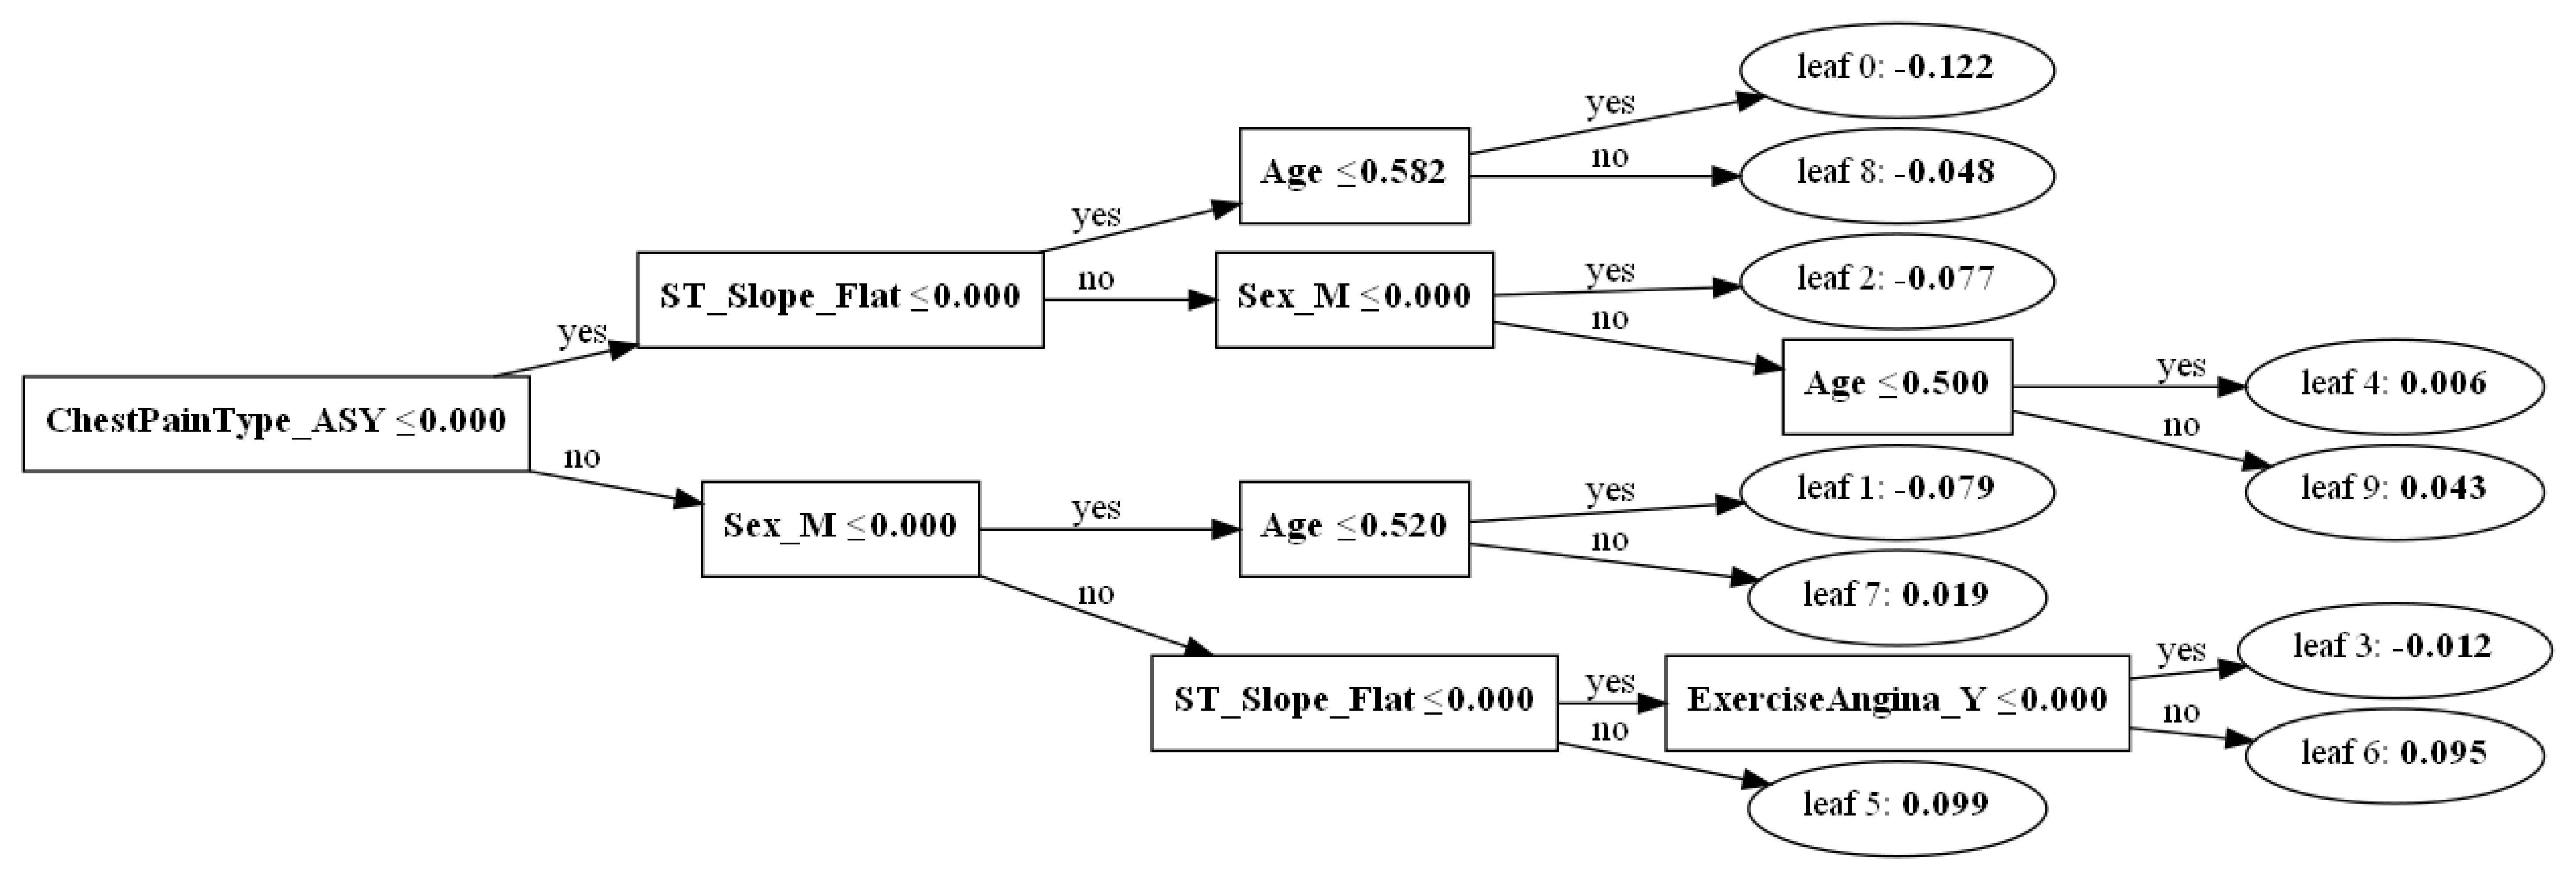

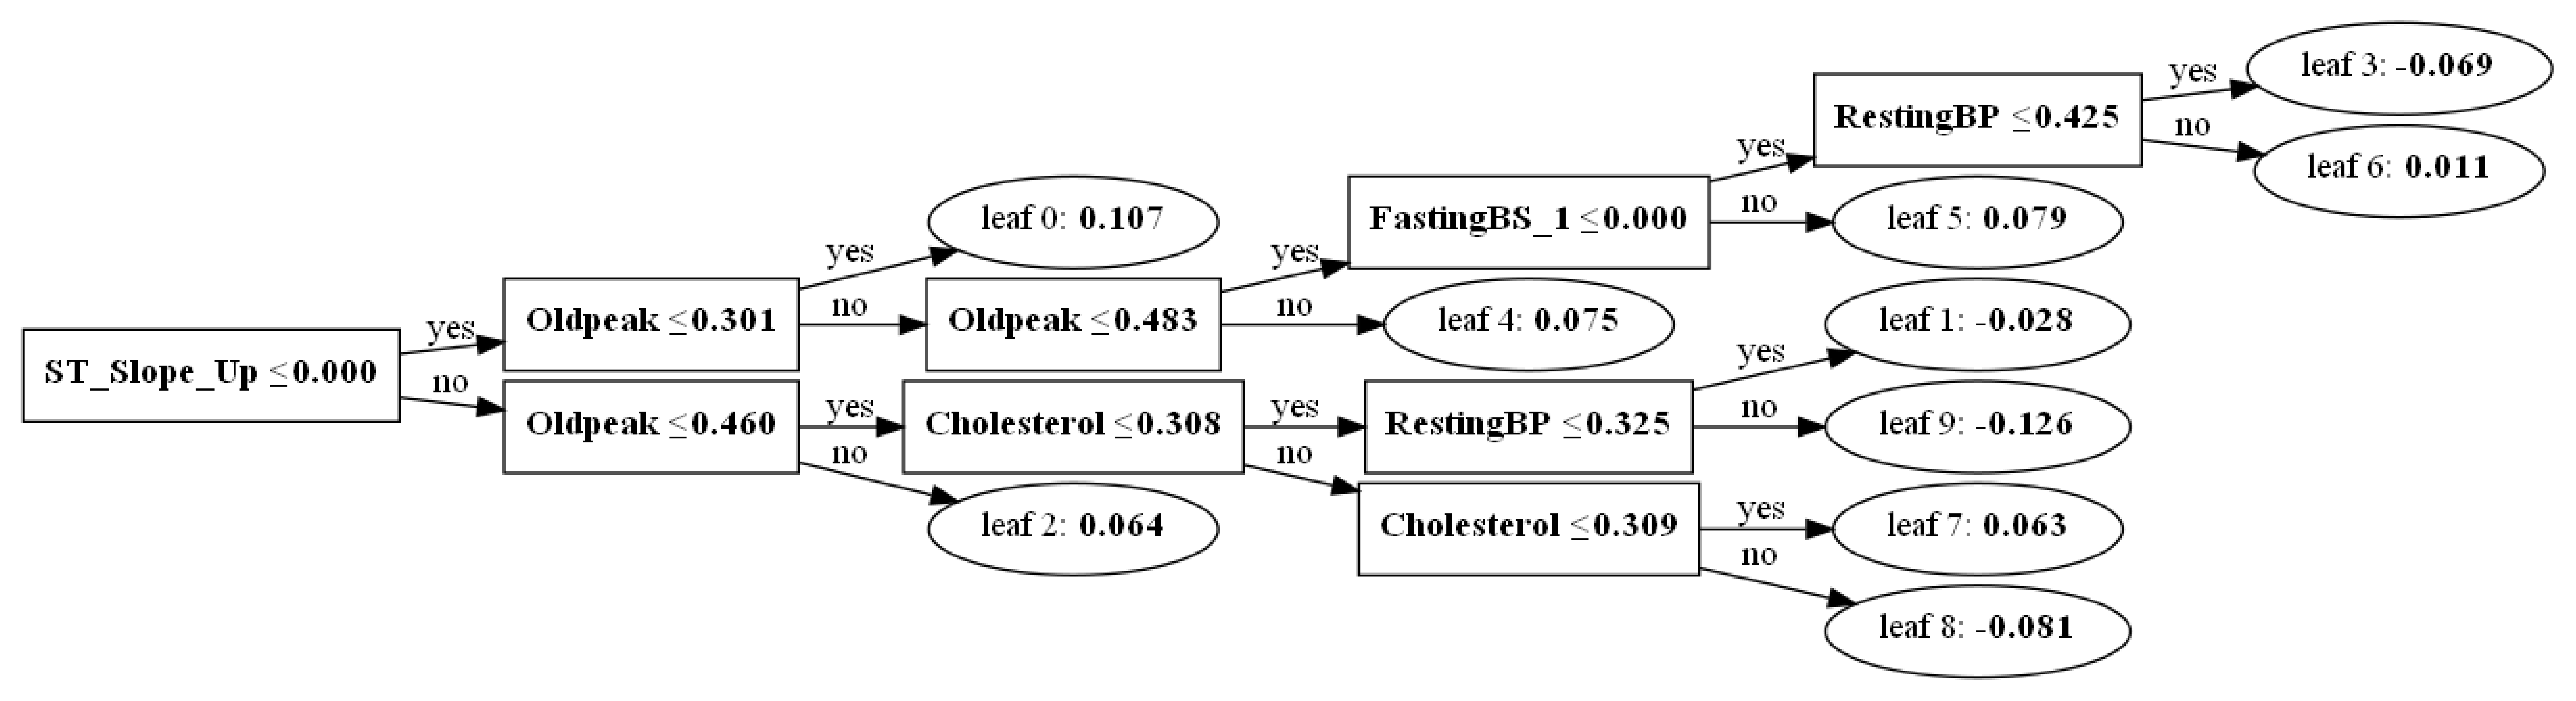

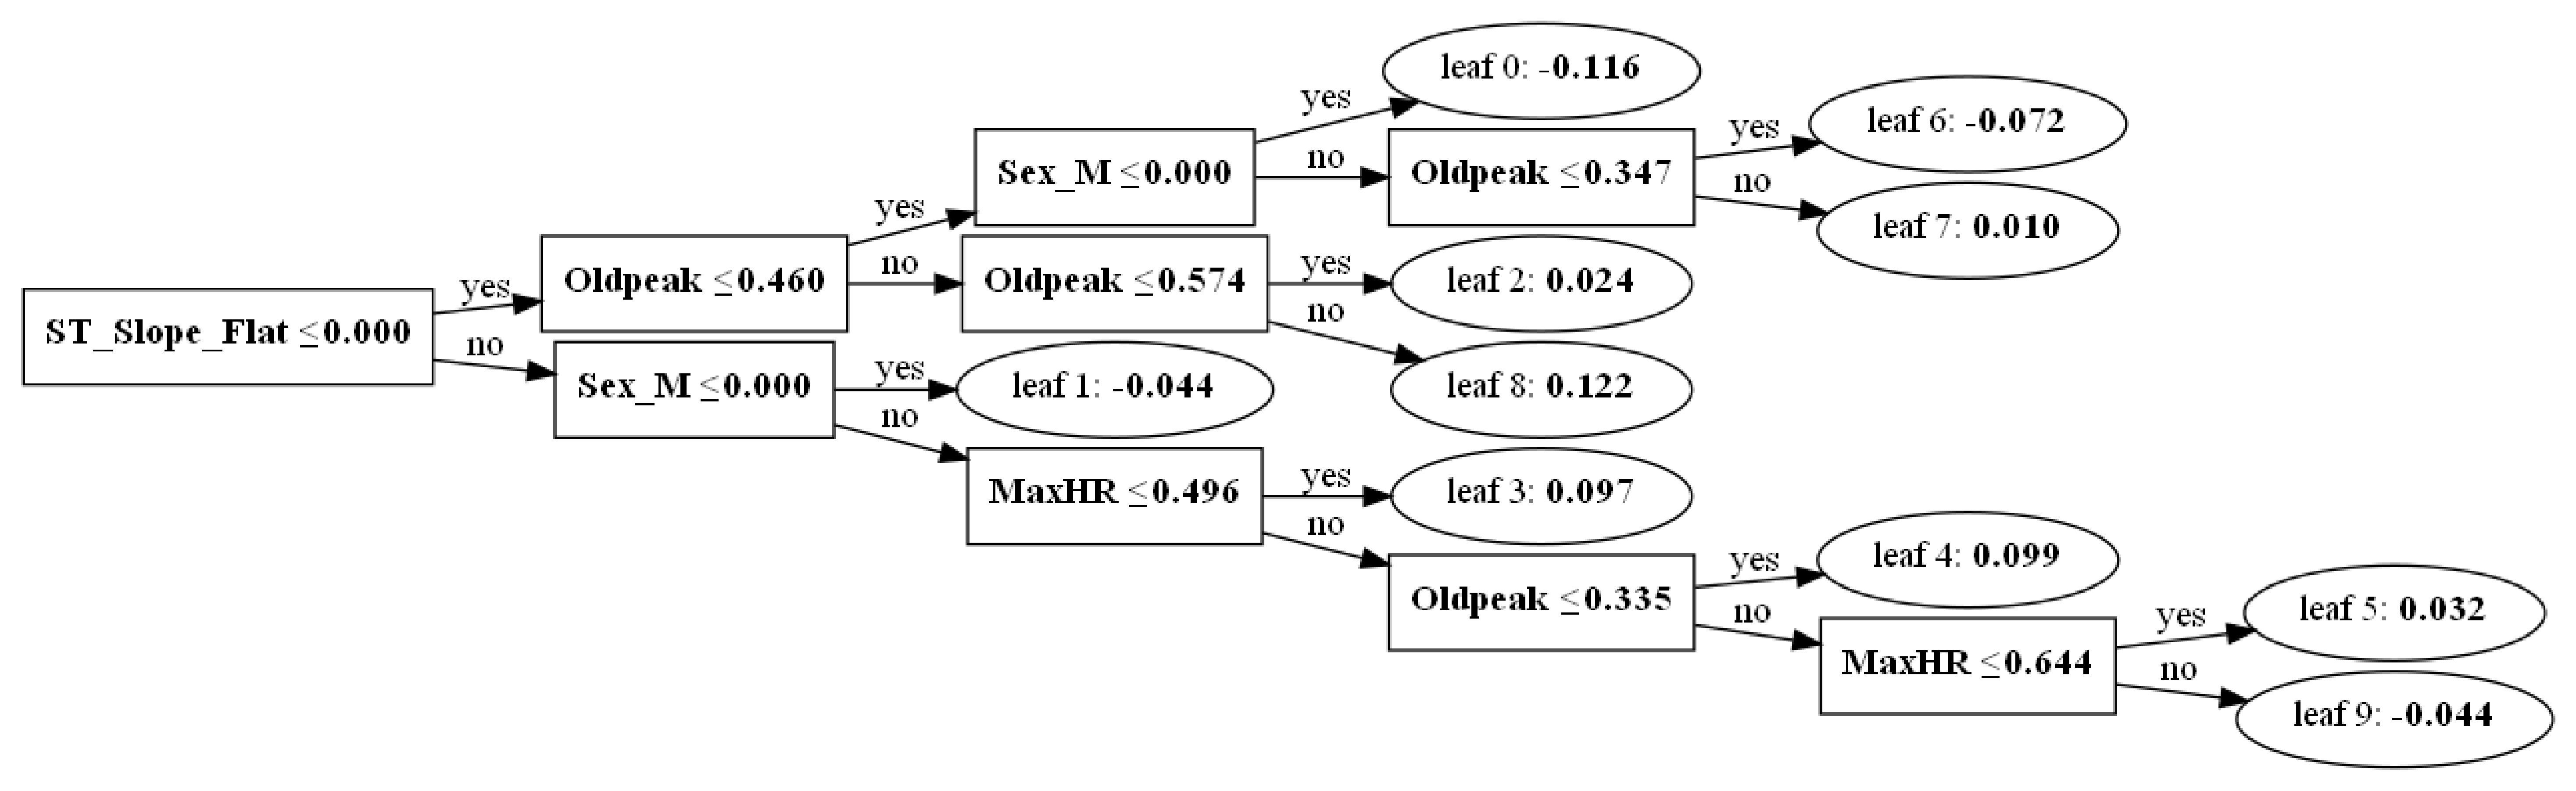

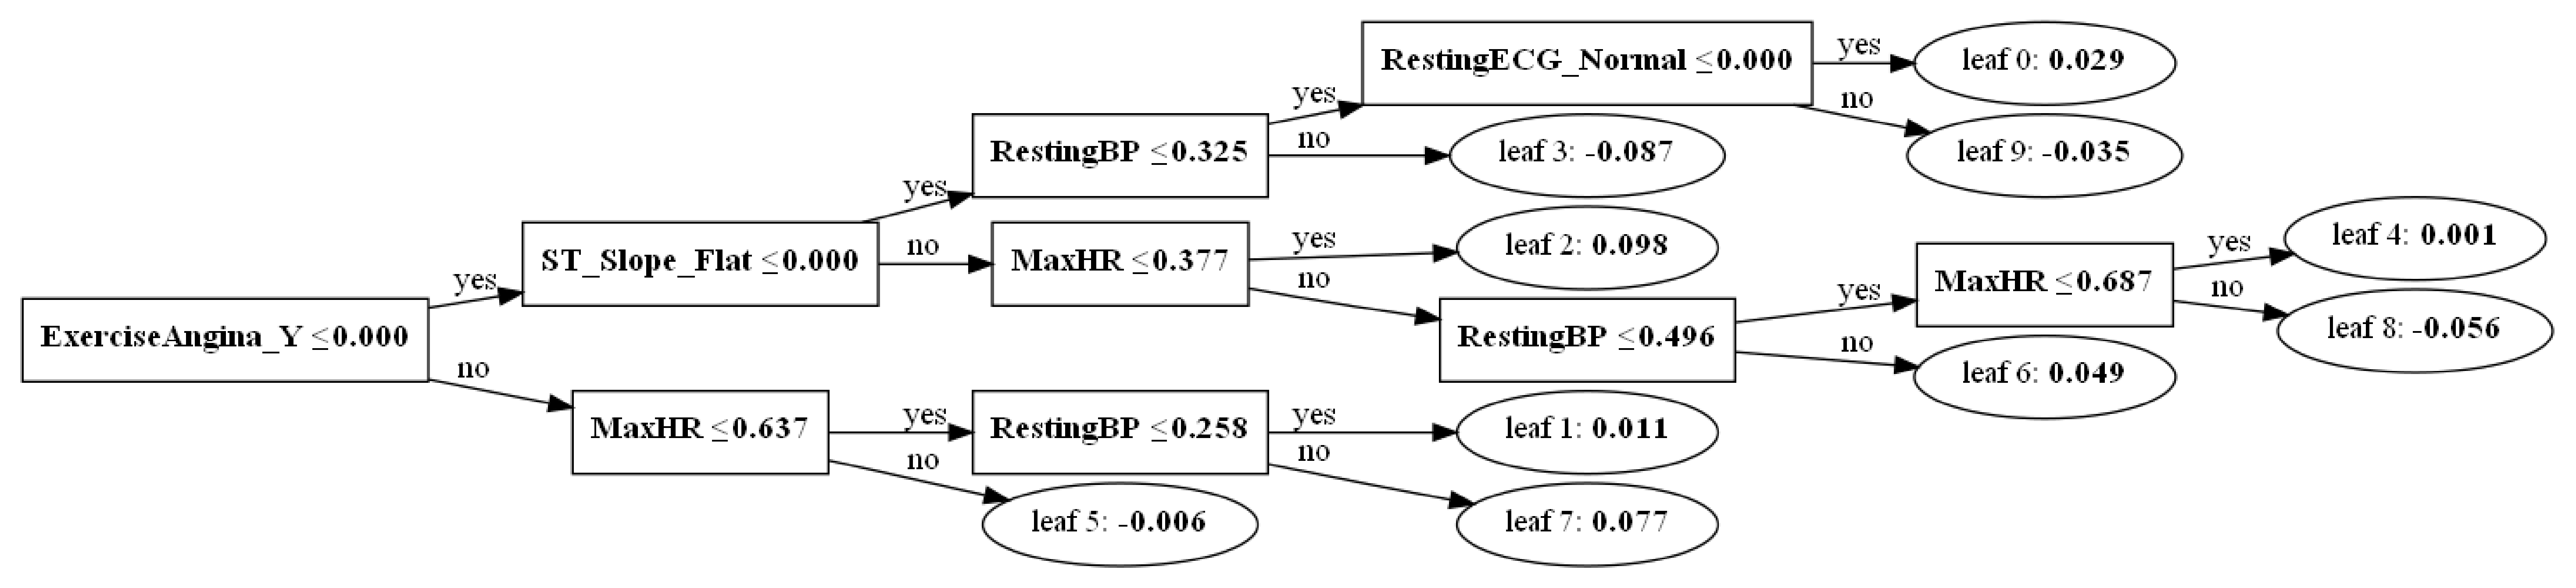

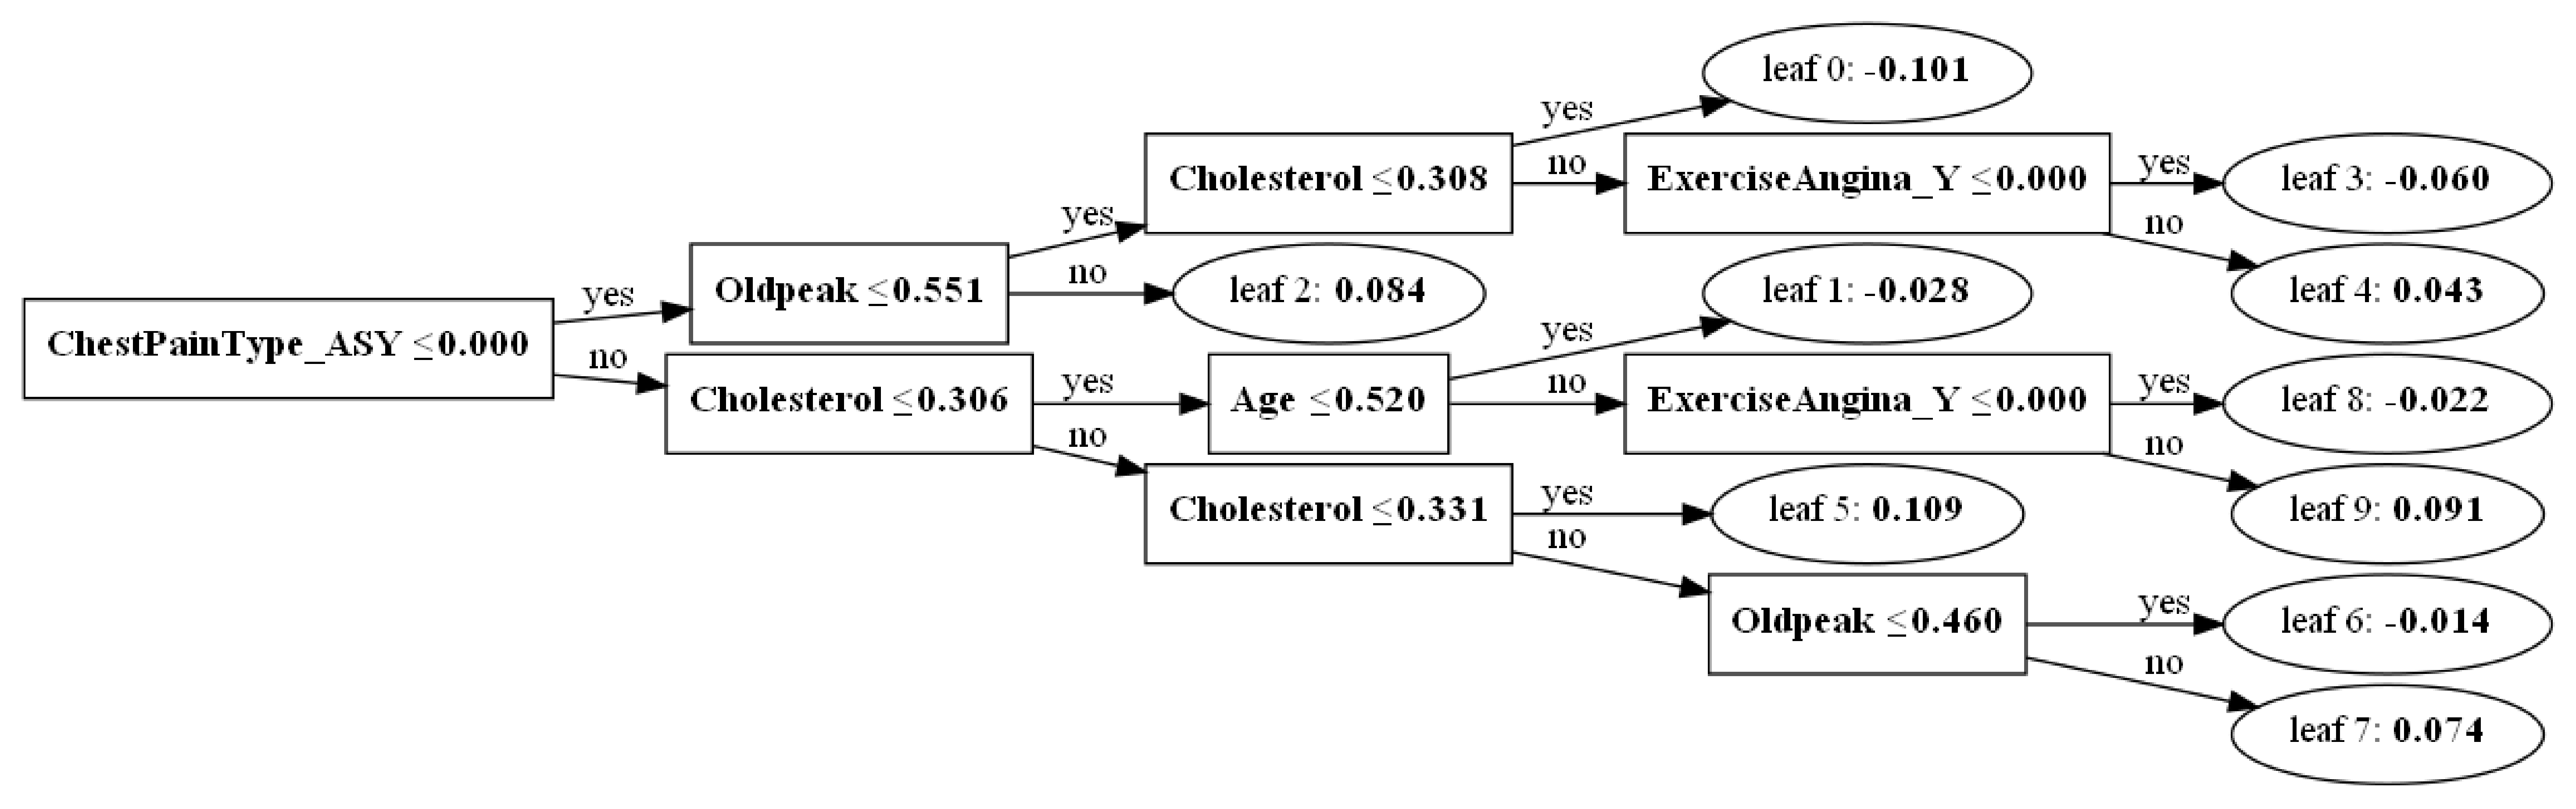

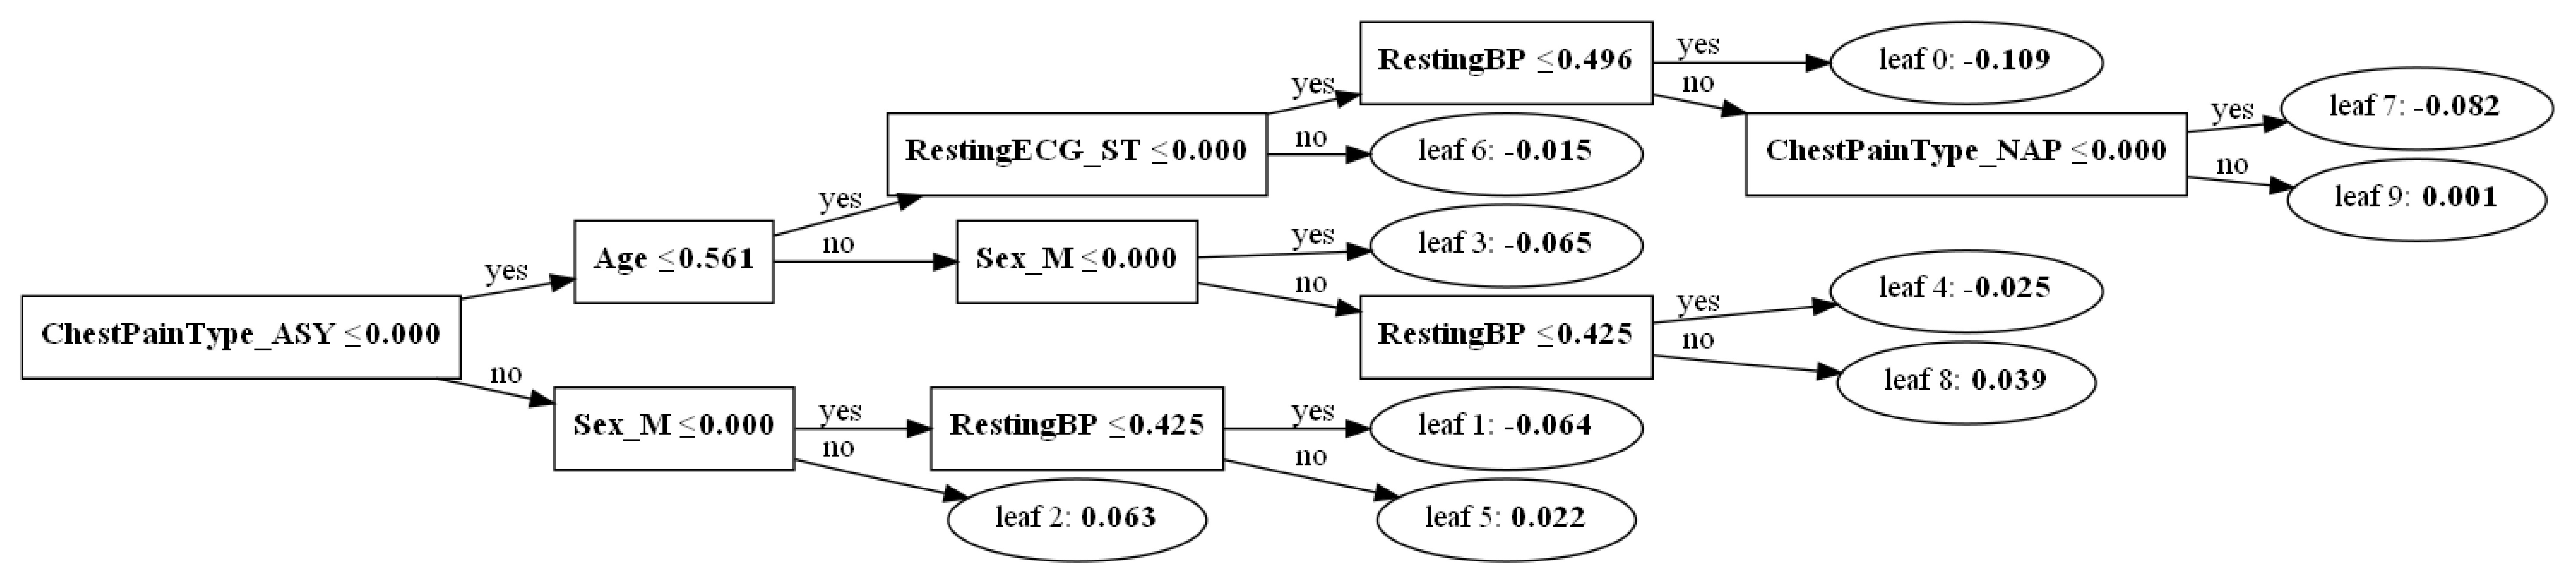

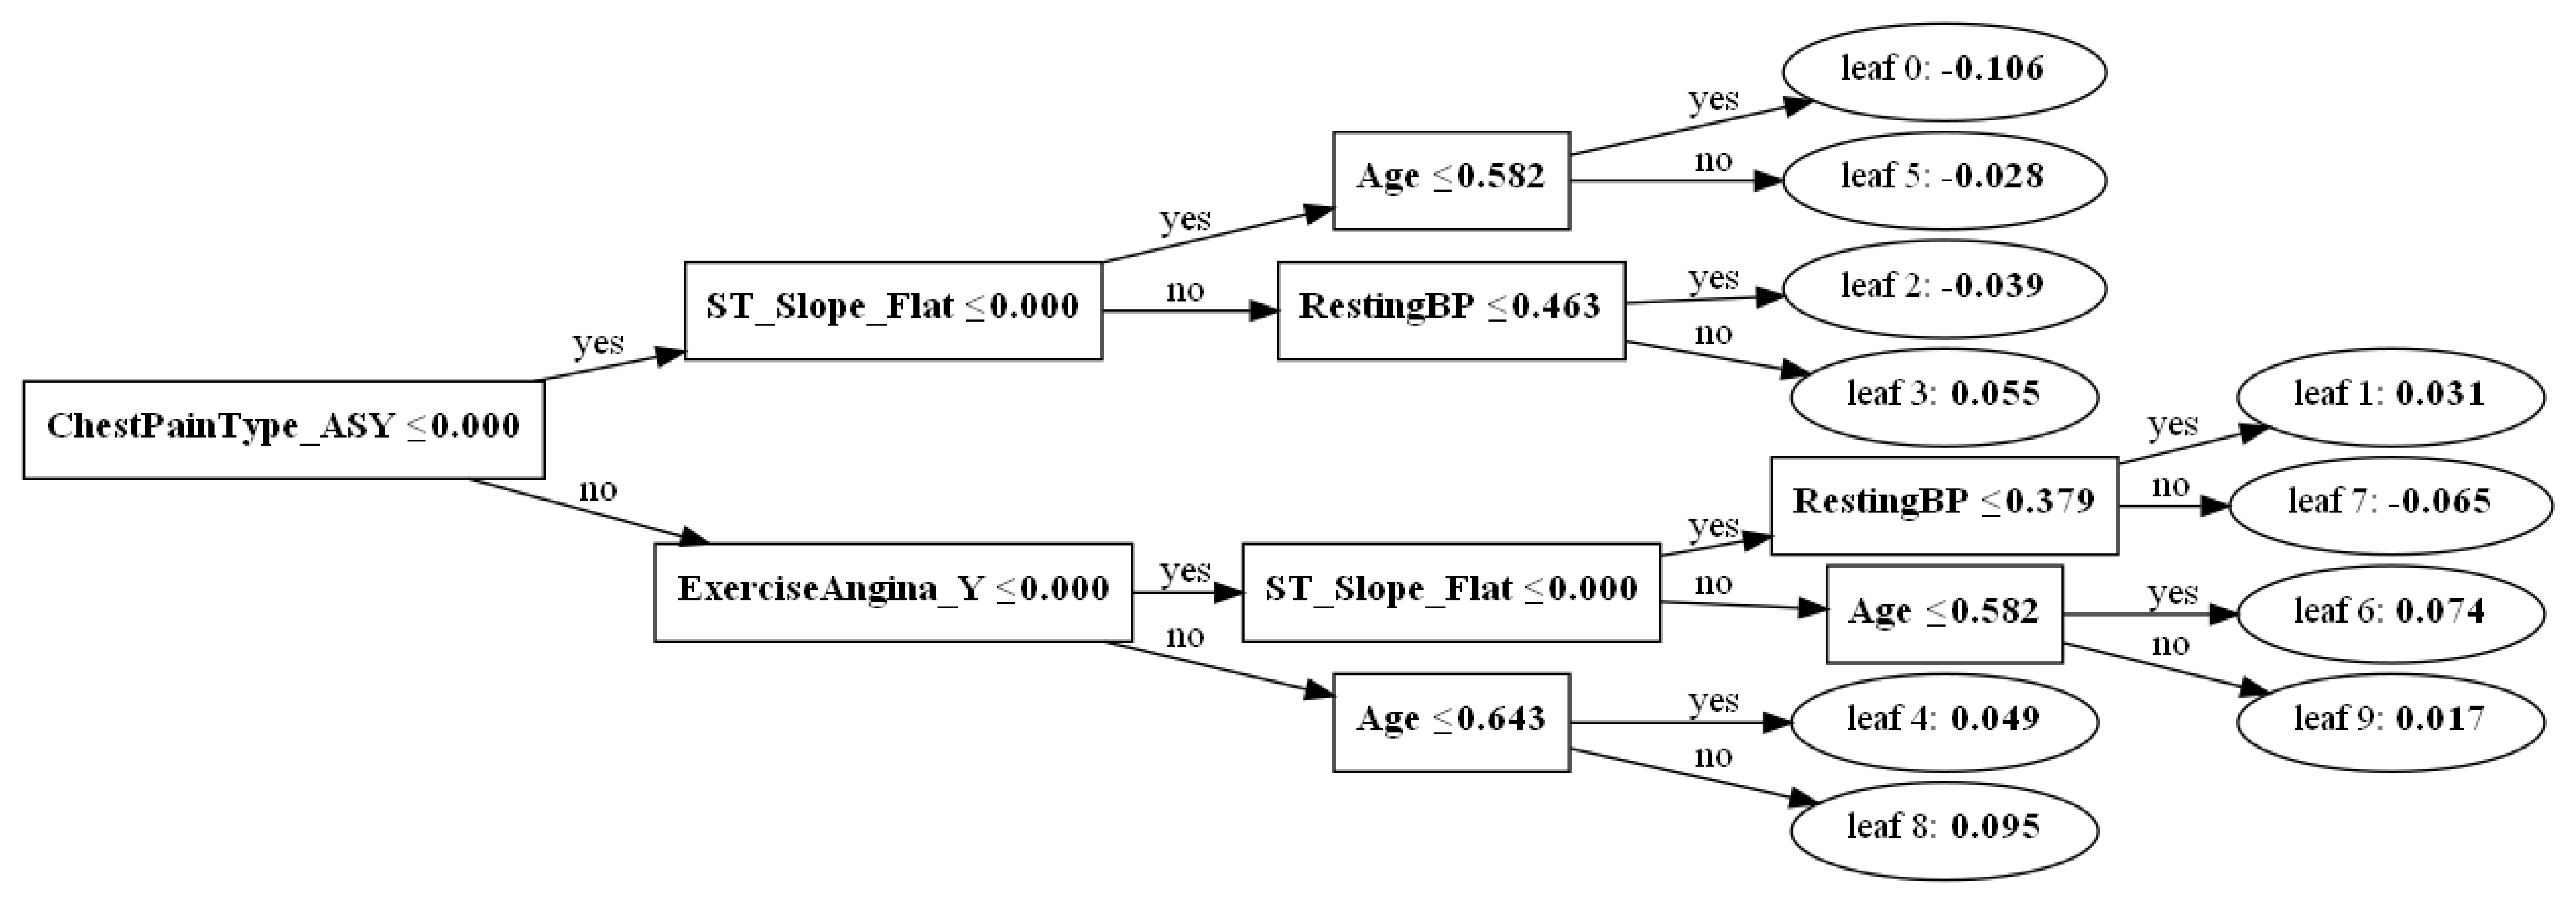

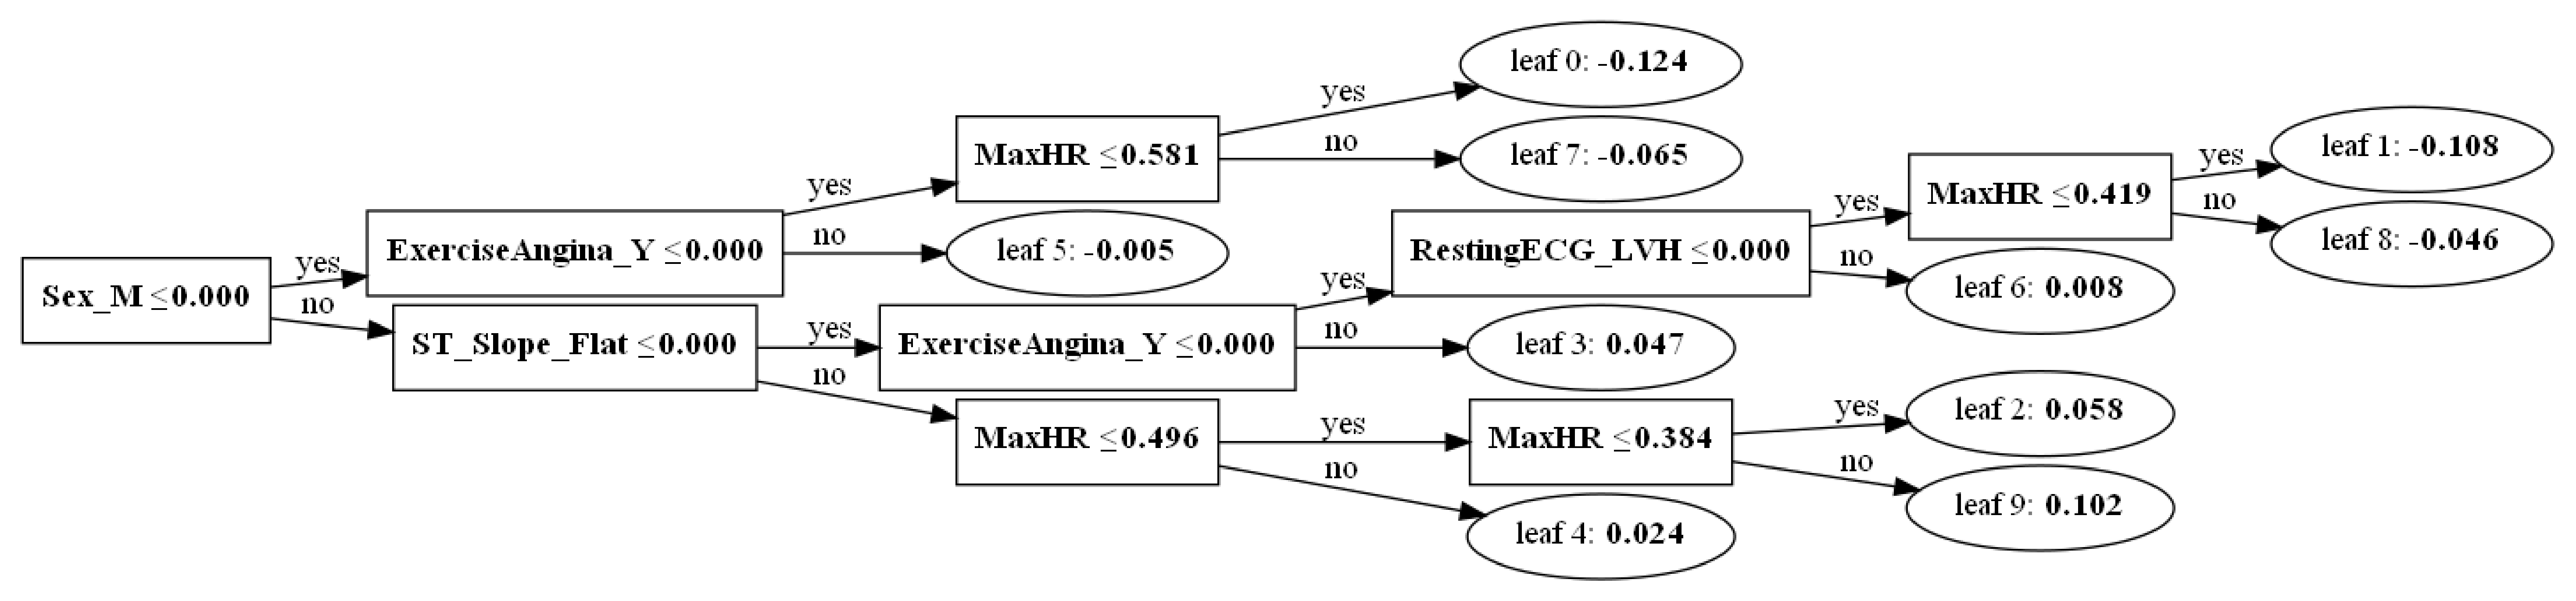

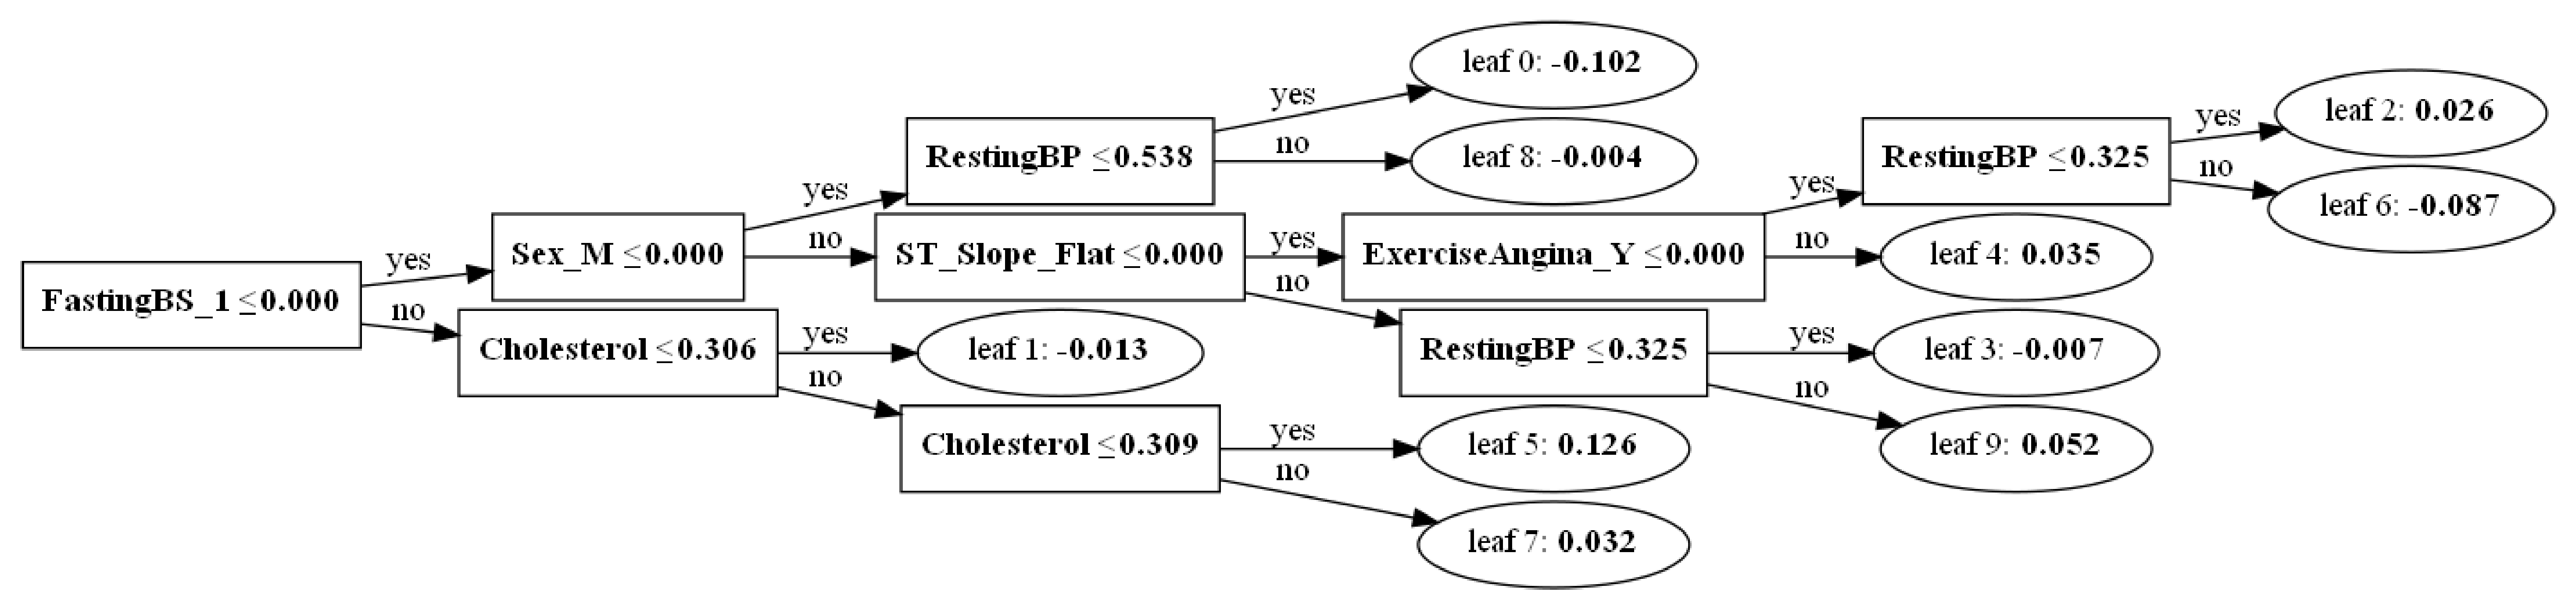

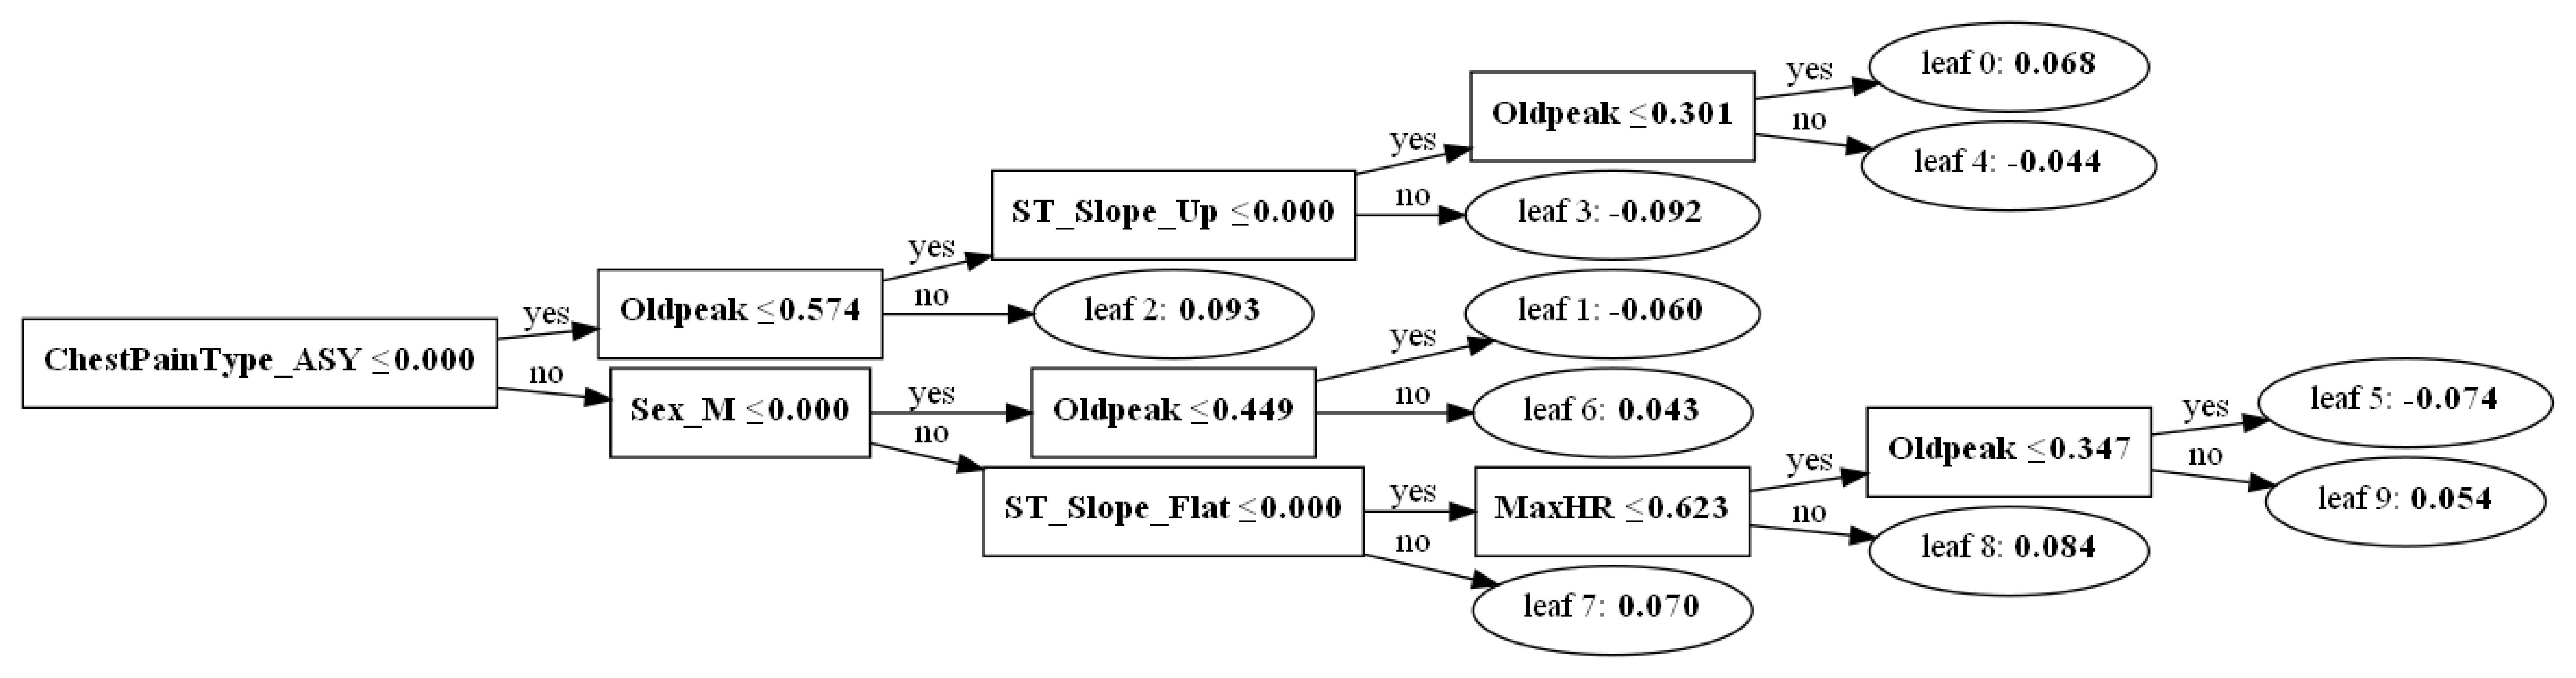

In [22]:
from lightgbm import plot_tree
i=0
while i<20:
    lgb.plot_tree(LGB,figsize=(20,6),tree_index=i,dpi=300)
    plt.gcf().set_size_inches(25, 15)
    plt.show()
    i+=1

In [23]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(LGB, X, y, cv=10, scoring='accuracy')
print("Accuracy: ", scores)

Accuracy:  [0.89130435 0.95652174 0.79347826 0.93478261 0.86956522 0.86956522
 0.85869565 0.79120879 0.74725275 0.78021978]


C:\Users\Van_P\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:99: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Van_P\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
C:\Users\Van_P\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:99: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Van_P\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please

In [24]:
#SVM
from sklearn import svm
clf = svm.SVC(kernel='linear')
clf.fit(X_train, y_train)
svm_pred = clf.predict(X_test)

C:\Users\Van_P\anaconda3\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


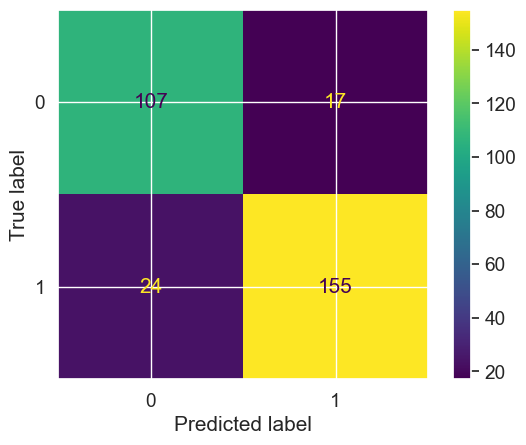

True Negatives:  107
False Positives:  17
False Negatives:  24
True Positives:  155
Accuracy: 0.8646864686468647
Precision: 0.9011627906976745
F1: 0.8831908831908832
MCCC: 0.723370437462303


In [25]:
#SVM Results
cm = confusion_matrix(y_test, svm_pred, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=clf.classes_)
disp.plot()
plt.show()
tp, fn, fp, tn = confusion_matrix(y_true = y_test, y_pred = svm_pred, labels=[1,0]).reshape(-1)
print("True Negatives: ",tn)
print("False Positives: ",fp)
print("False Negatives: ",fn)
print("True Positives: ",tp)

accuray_svm = accuracy_score(y_test,svm_pred)
print("Accuracy:", accuray_svm)
precision_svm = precision_score(y_test, svm_pred)
print("Precision:", precision_svm)
f1_svm=f1_score(y_test, svm_pred)
print("F1:", f1_svm)
mcc_svm = matthews_corrcoef(y_test, svm_pred)
print("MCCC:", mcc_svm)

In [26]:
#XGBOOST
import xgboost as xg
xgb = xg.XGBClassifier(n_estimators = 12, seed = 10,max_depth=5,booster='gbtree',
                       min_child_weight =5,subsample =0.5,objective='binary:logistic',reg_alpha = 0.1,reg_lambda = 0.5
                      ,colsample_bytree=0.5)
xgb.fit(X_train, y_train)
pred_xgb = xgb.predict(X_test)

In [27]:
import time
model = xgb
start=time.time()
param_grid = {'max_depth': [5,7,10,14,20],
             'seed':[8,10,15],
             'min_child_weight':[3,5,10,15],
              'subsample':[0.5,1]}

model, pred = algorithm_pipeline(X_train, X_test, y_train, y_test, model, 
                                 param_grid, cv=5)
end = time.time()
#Root Mean Squared Error
print(np.sqrt(-model.best_score_))
print(model.best_params_)
print("Time Taken with GridSearchCV:", end-start)

Fitting 5 folds for each of 120 candidates, totalling 600 fits
nan
{'max_depth': 5, 'min_child_weight': 5, 'seed': 8, 'subsample': 1}
Time Taken with GridSearchCV: 1.4353923797607422


C:\Users\Van_P\AppData\Local\Temp\ipykernel_31448\2597407337.py:13: RuntimeWarning: invalid value encountered in sqrt
  print(np.sqrt(-model.best_score_))


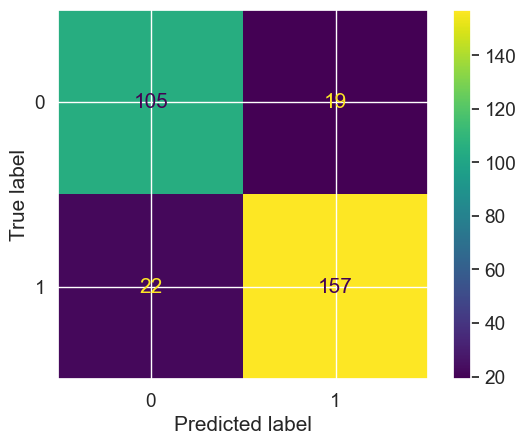

True Negatives:  105
False Positives:  19
False Negatives:  22
True Positives:  157
Accuracy: 0.8646864686468647
Precision: 0.8920454545454546
F1: 0.8845070422535212
MCCC: 0.721338713963354


In [28]:
#XGB Results
cm = confusion_matrix(y_test, pred_xgb, labels=xgb .classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=xgb .classes_)
disp.plot()
plt.show()
tp, fn, fp, tn = confusion_matrix(y_true = y_test, y_pred = pred_xgb, labels=[1,0]).reshape(-1)
print("True Negatives: ",tn)
print("False Positives: ",fp)
print("False Negatives: ",fn)
print("True Positives: ",tp)

accuray_xgb = accuracy_score(y_test, pred_xgb)
print("Accuracy:", accuray_xgb)
precision_xgb = precision_score(y_test, pred_xgb)
print("Precision:", precision_xgb)
f1_xgb=f1_score(y_test, pred_xgb)
print("F1:", f1_xgb)
mcc_xgb = matthews_corrcoef(y_test, pred_xgb)
print("MCCC:", mcc_xgb)

In [29]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(xgb, X, y, cv=10, scoring='accuracy')
print("Accuracy: ", scores)

Accuracy:  [0.84782609 0.94565217 0.80434783 0.90217391 0.85869565 0.86956522
 0.86956522 0.84615385 0.78021978 0.79120879]


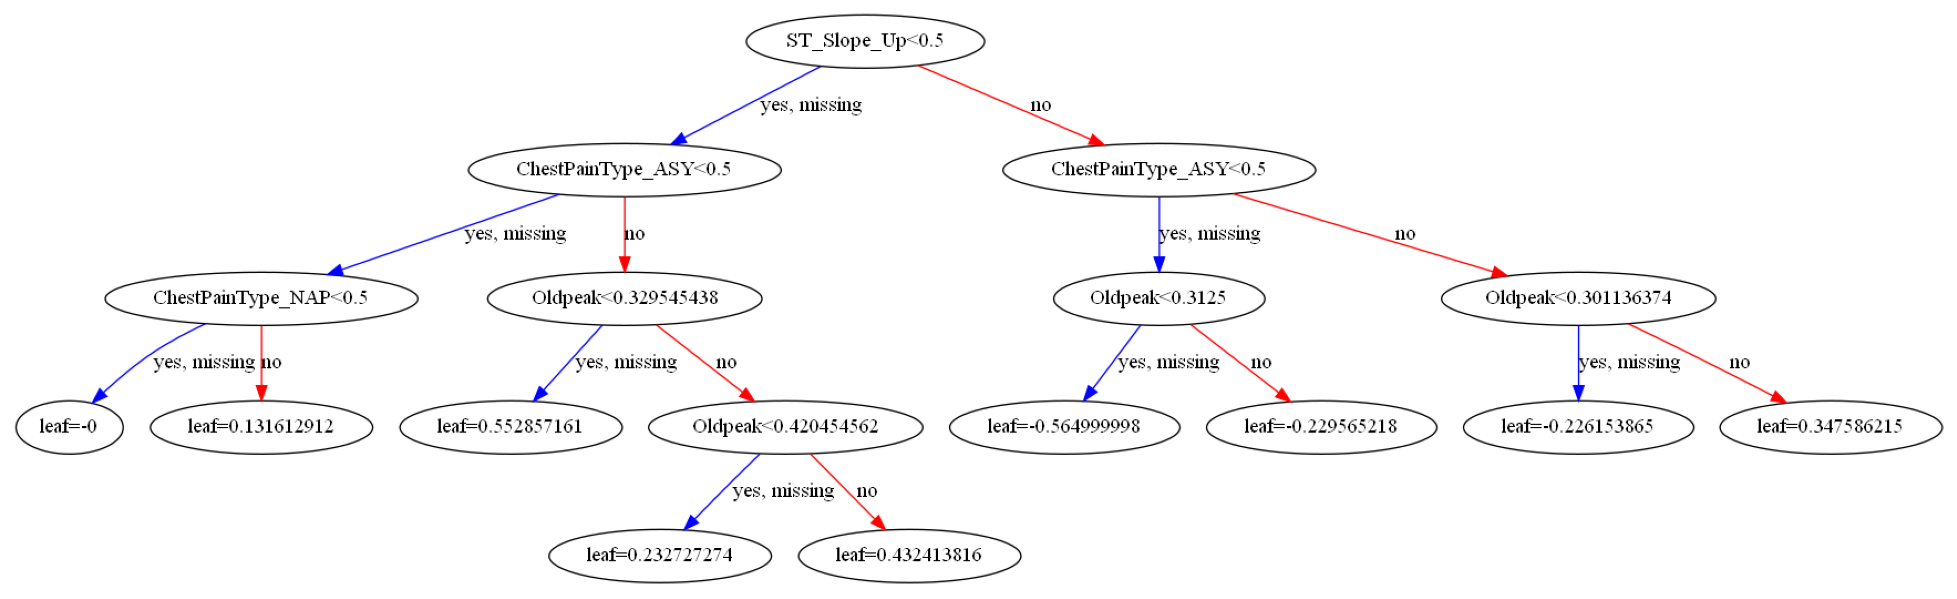

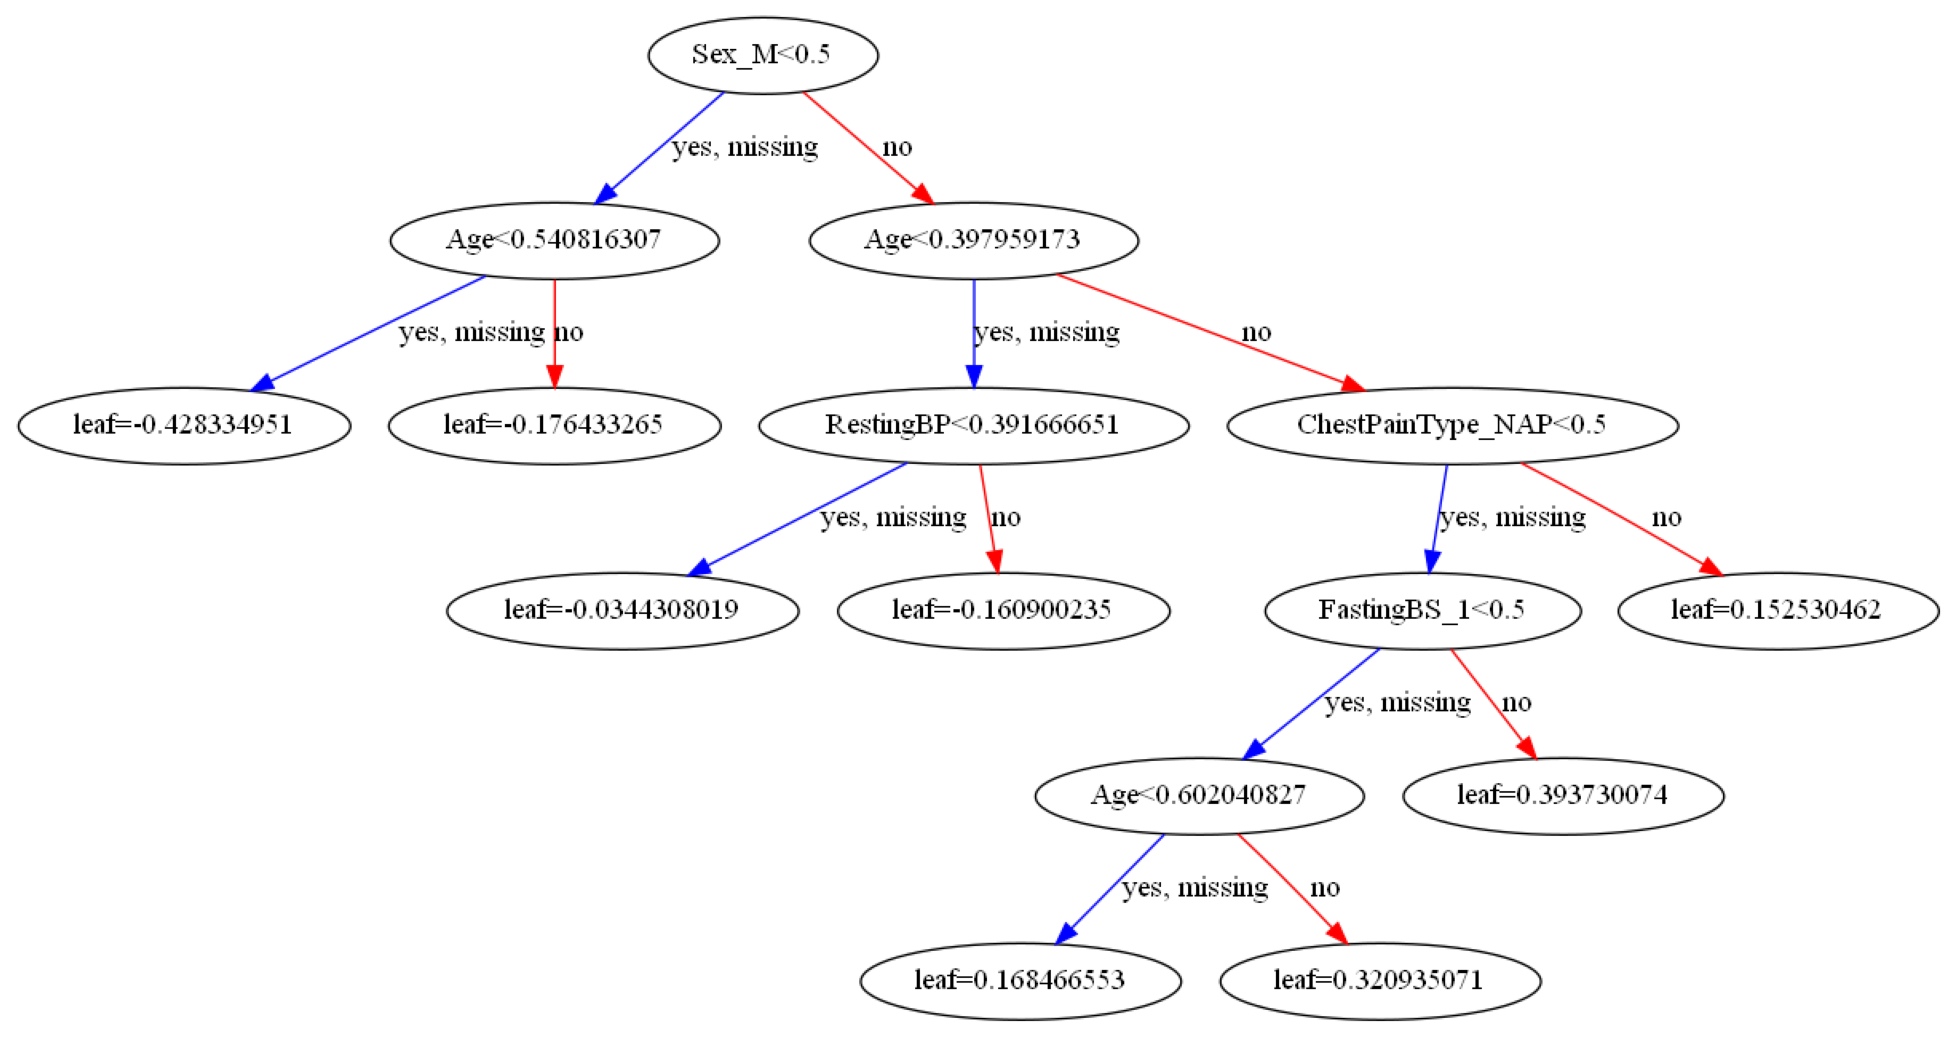

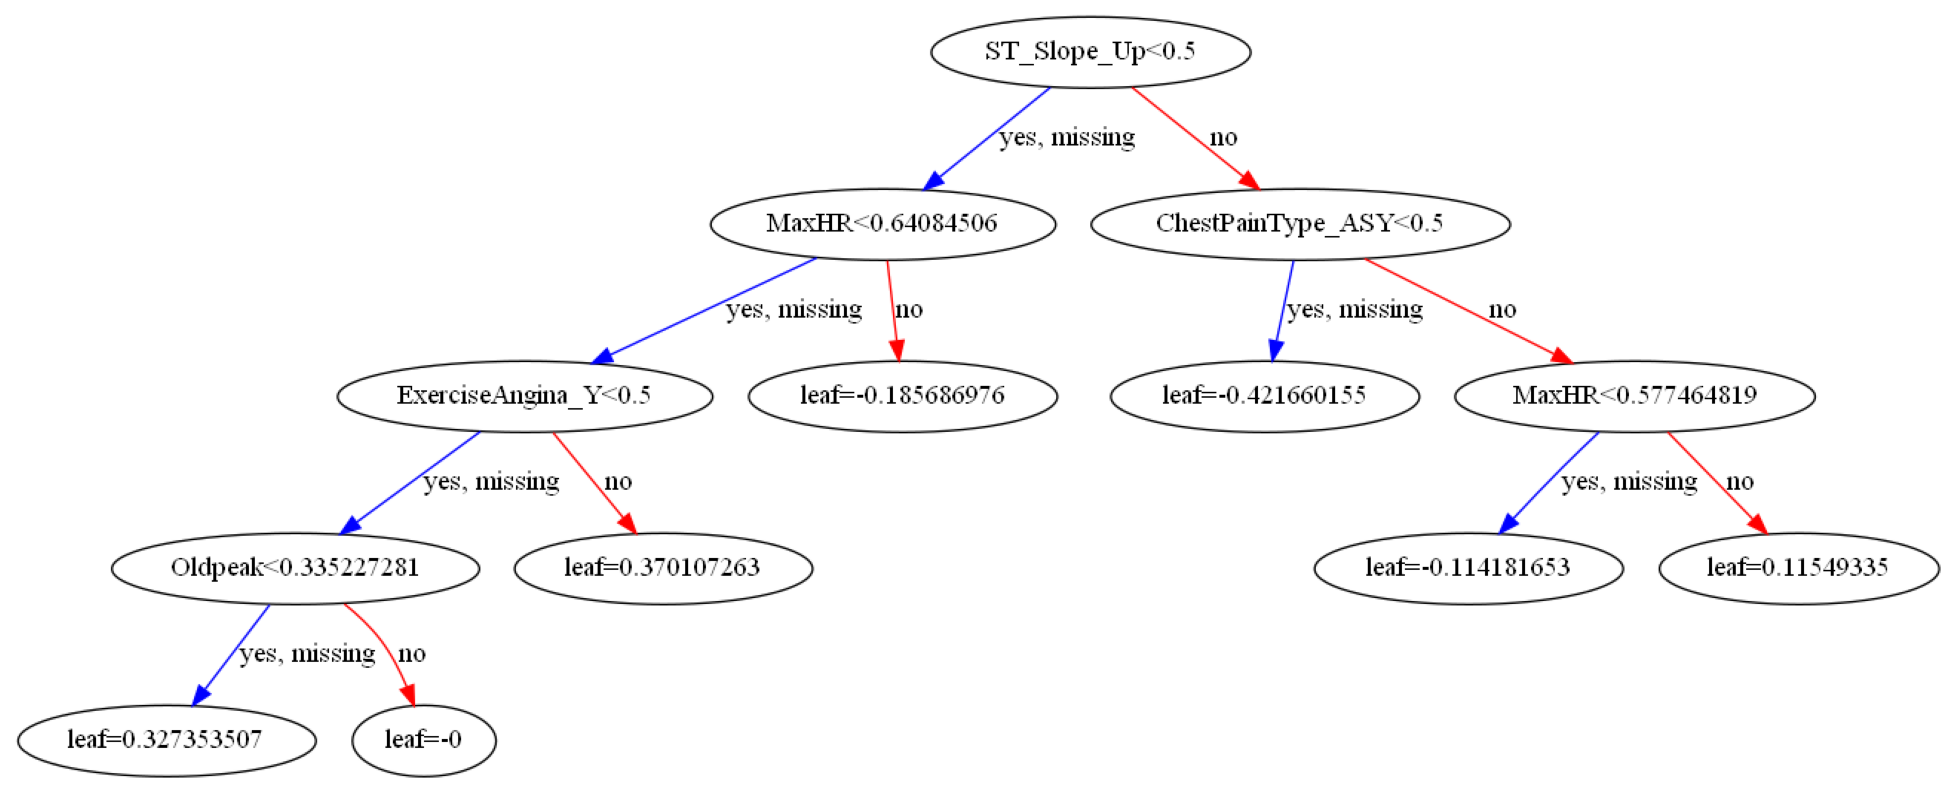

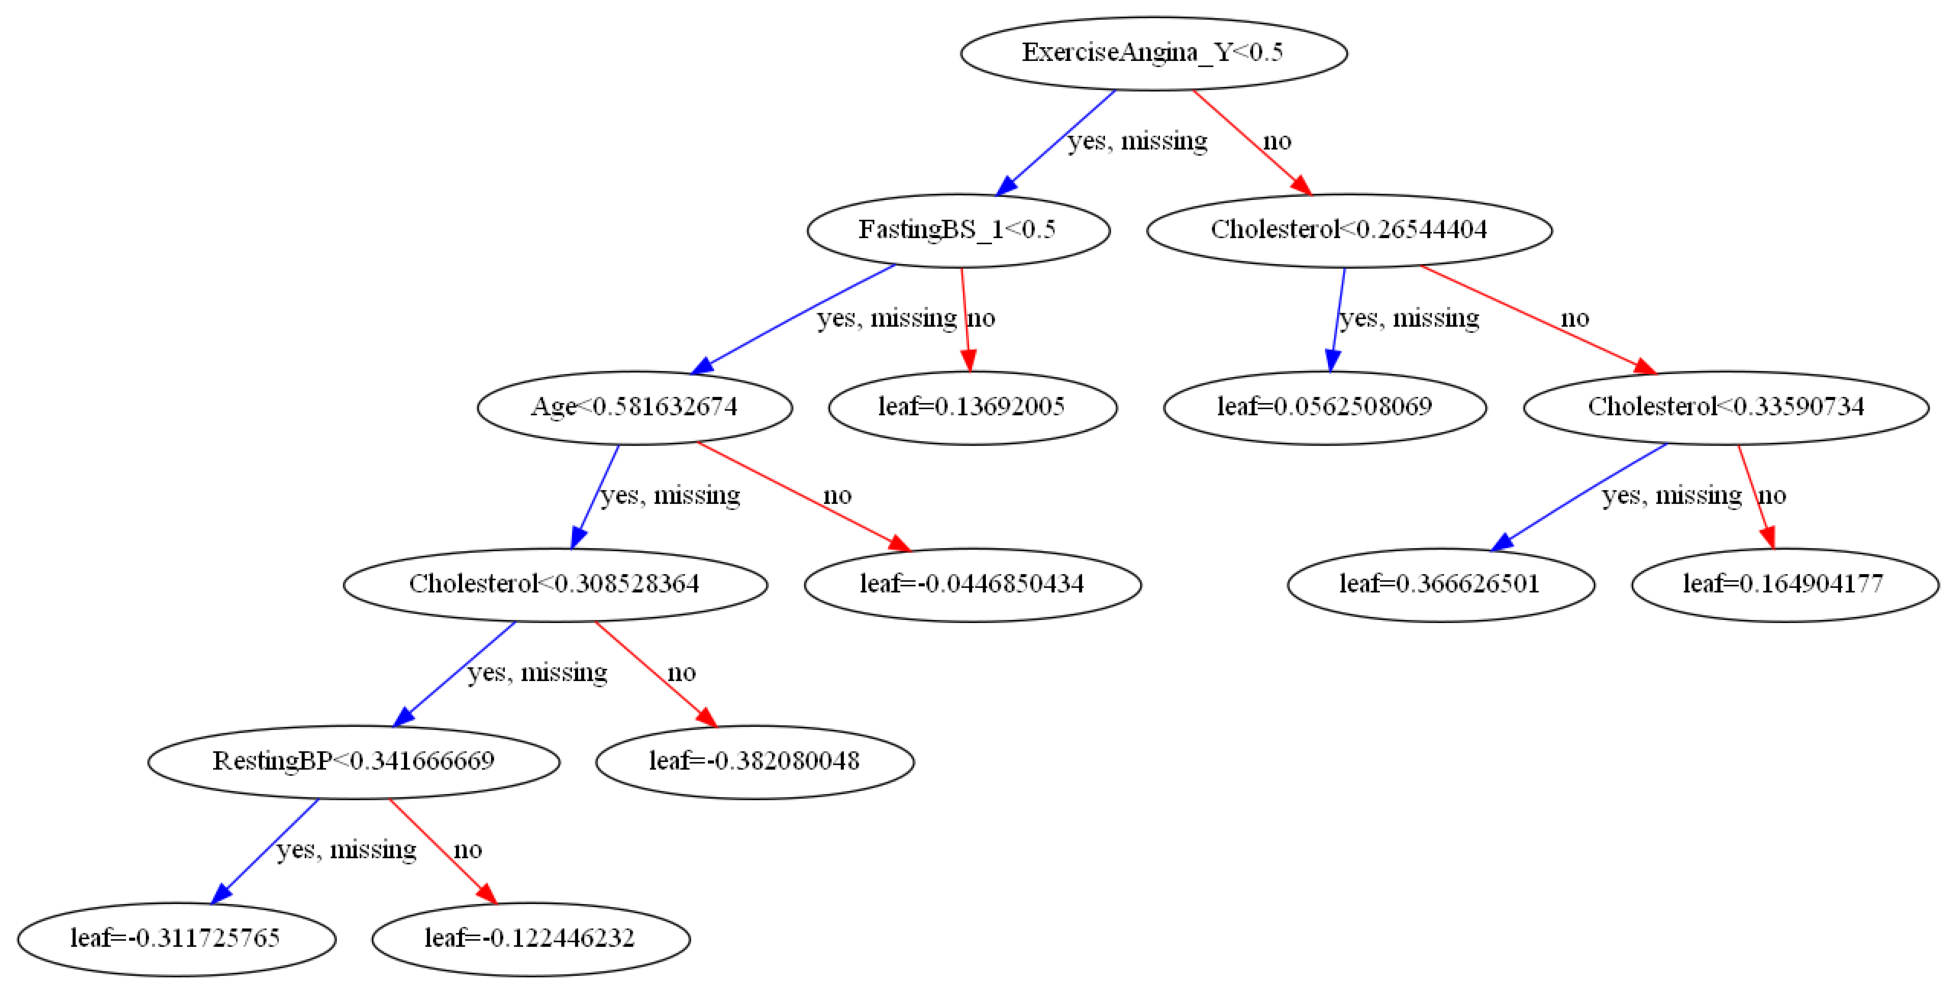

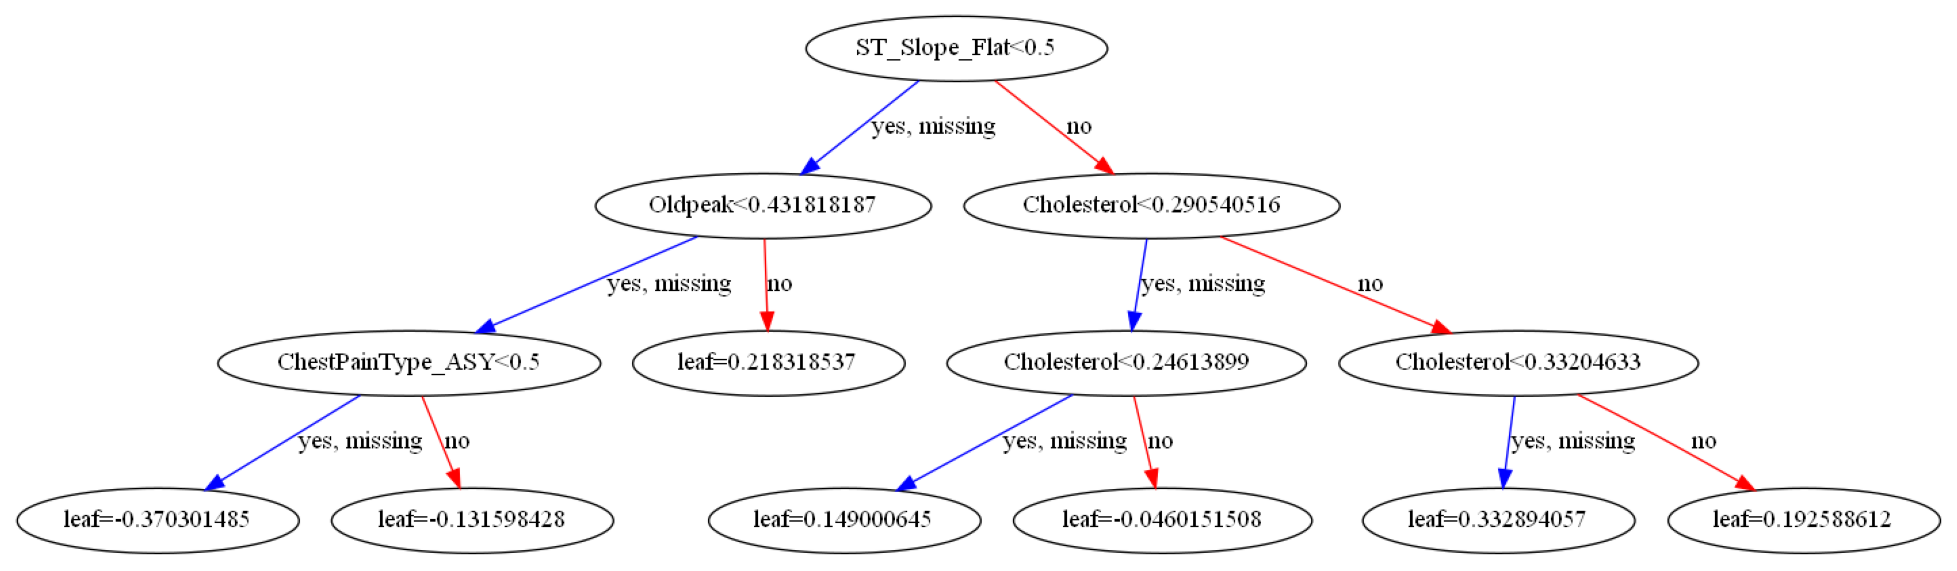

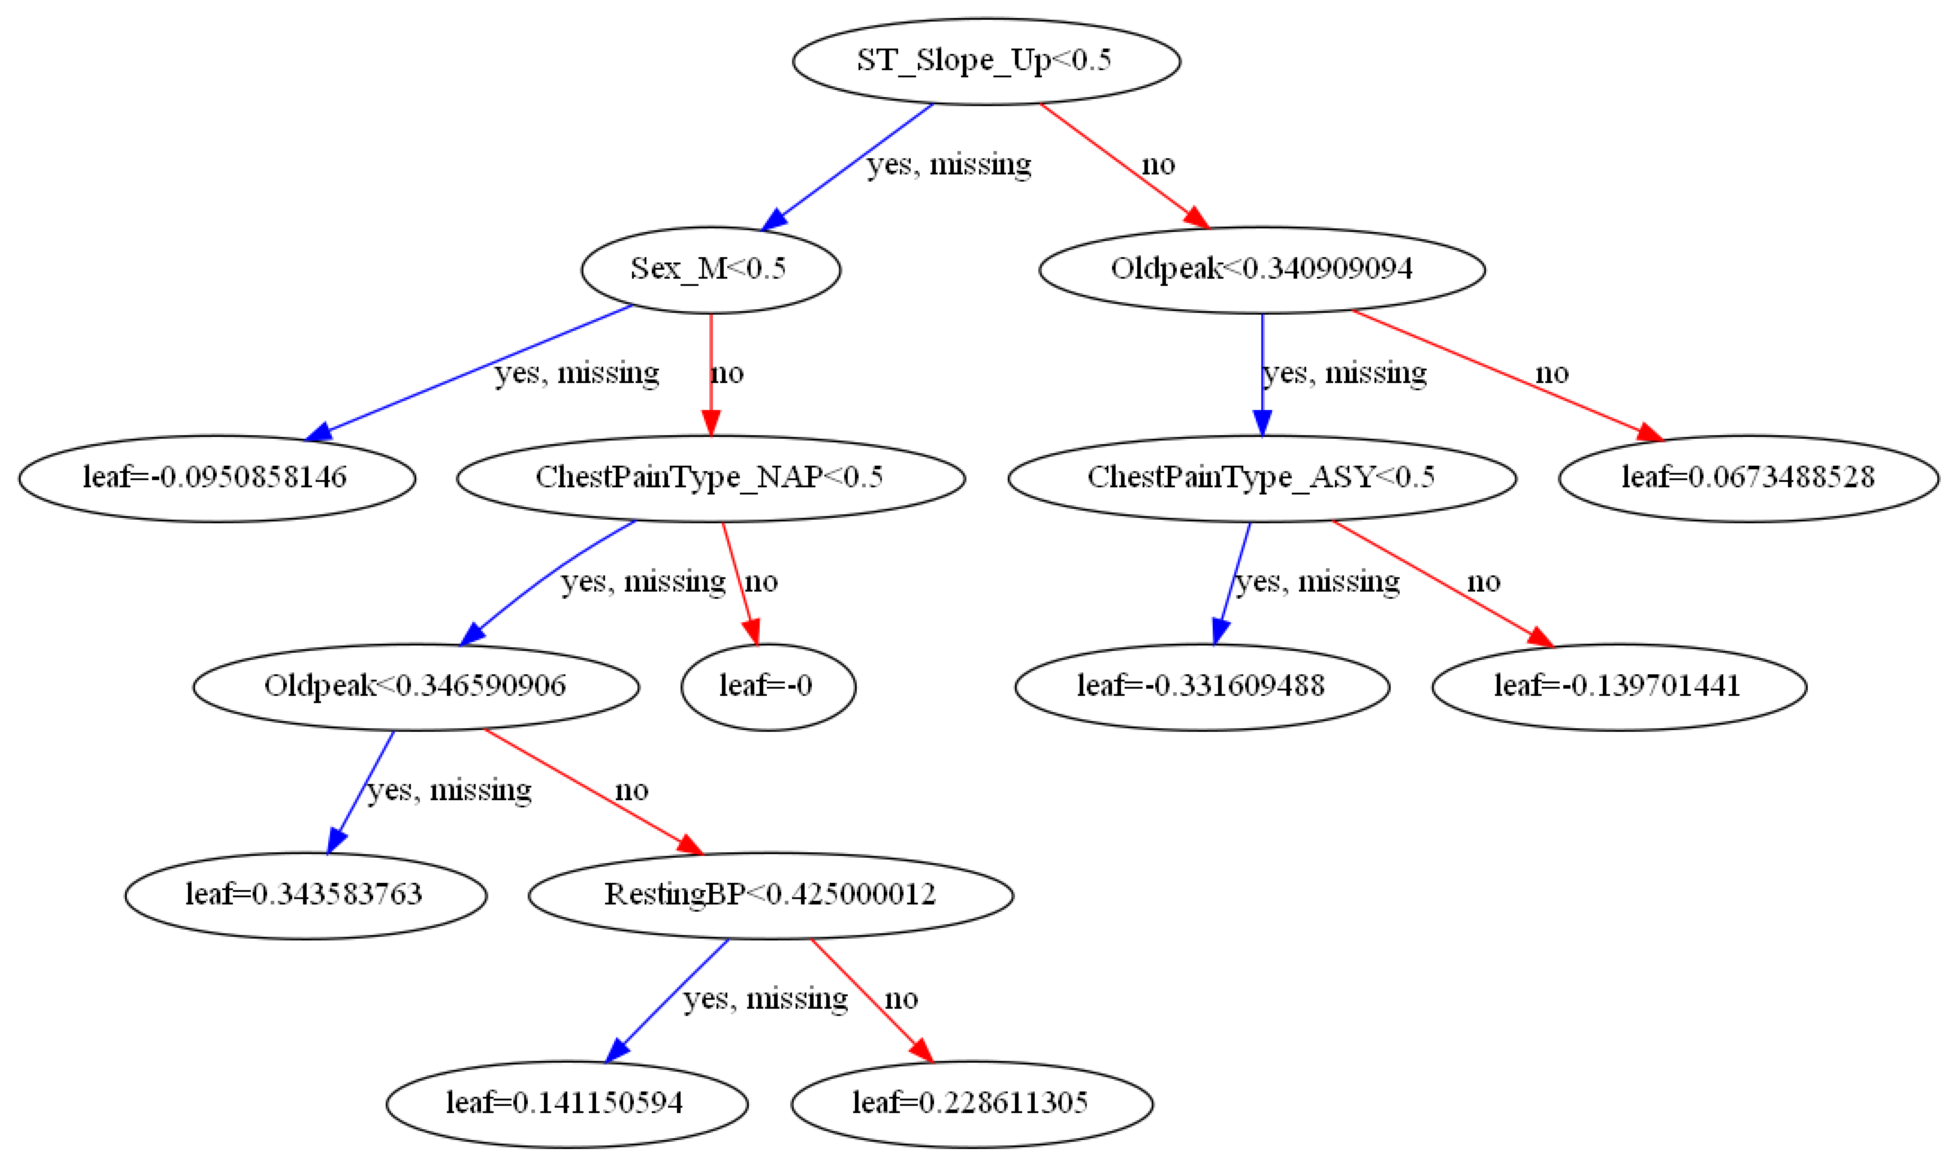

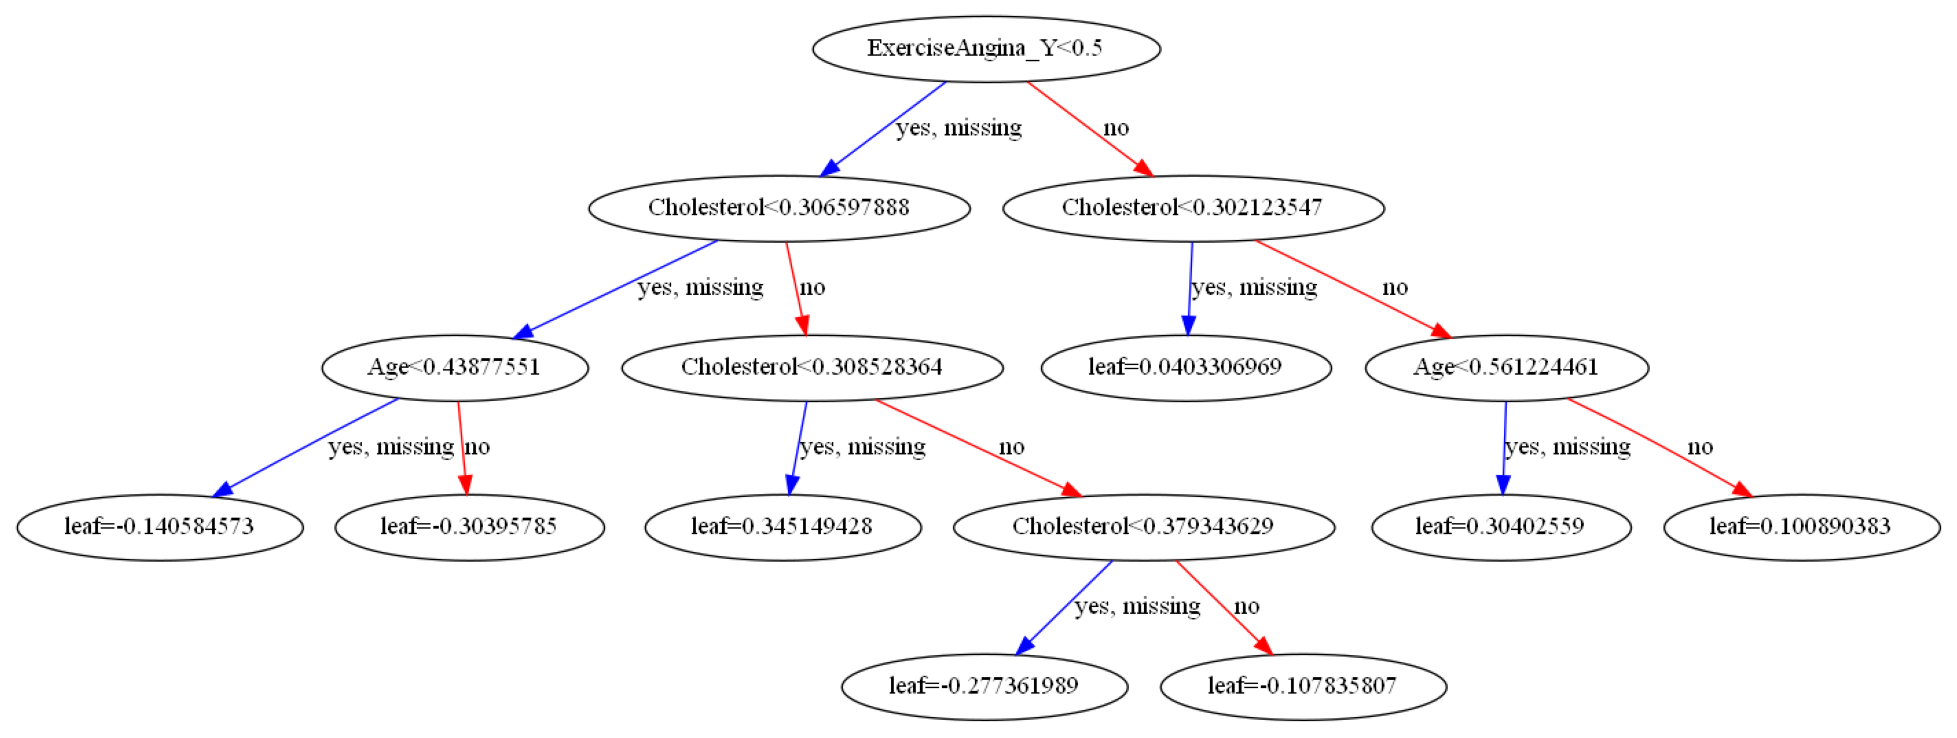

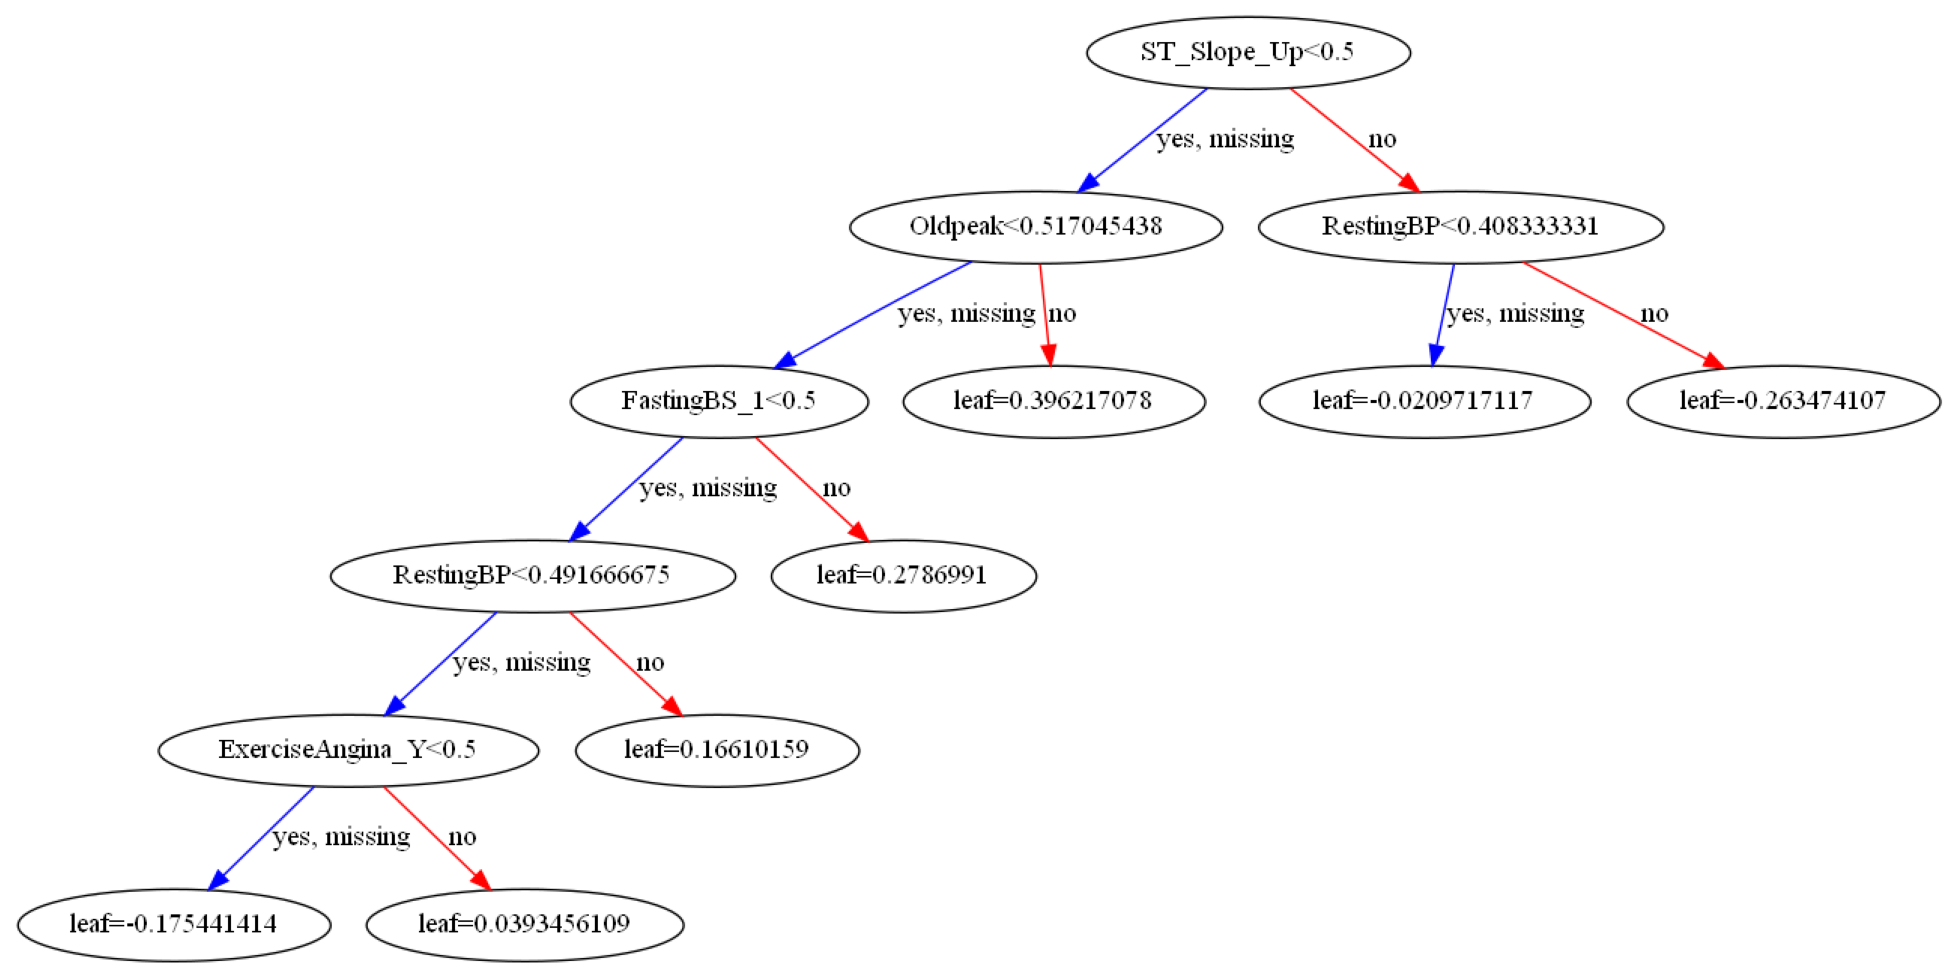

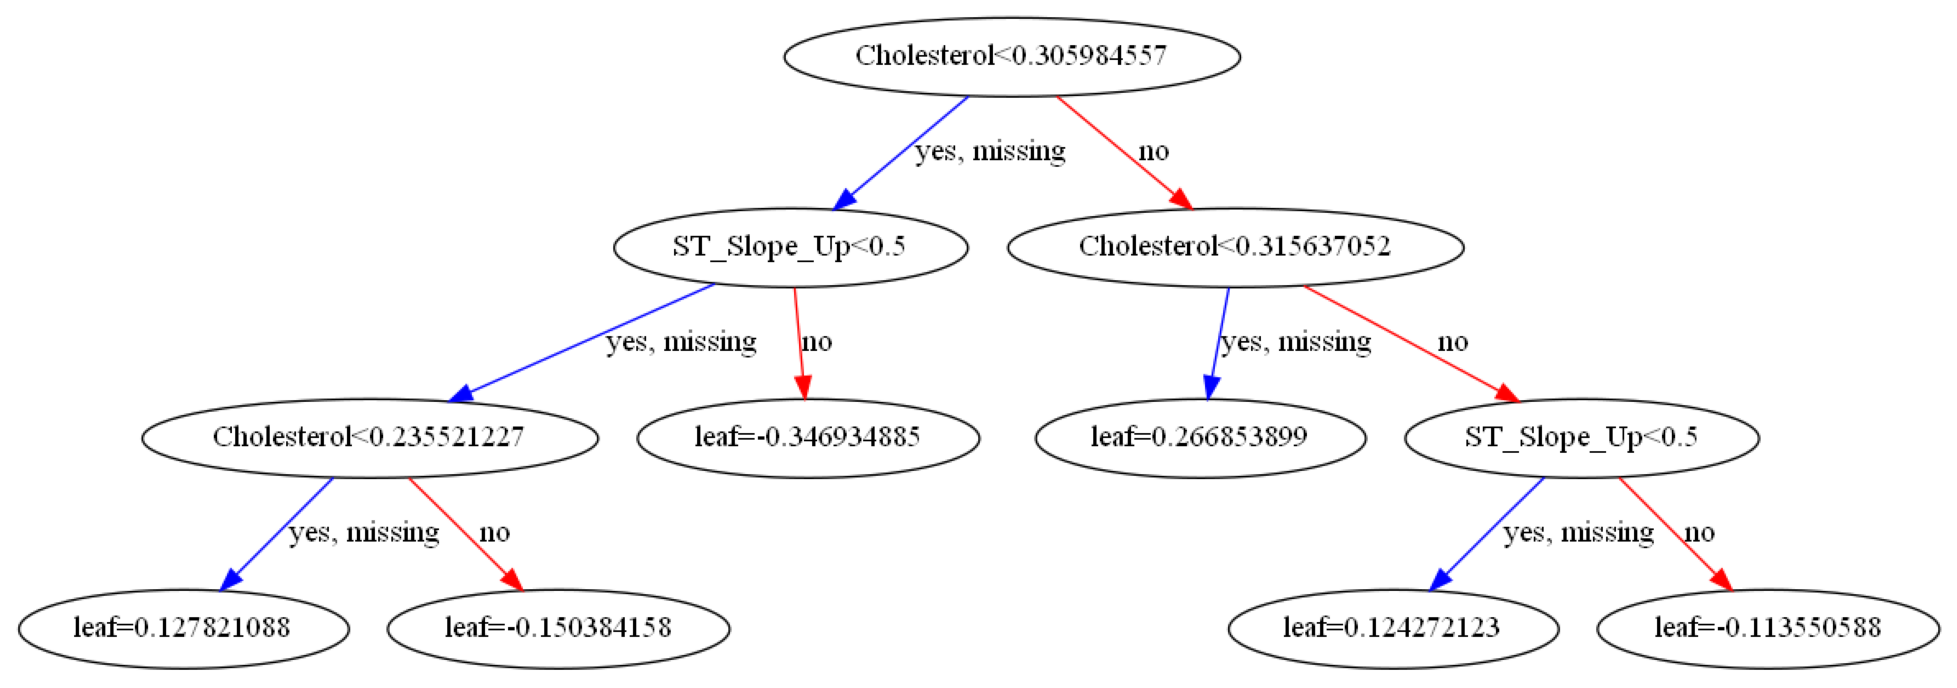

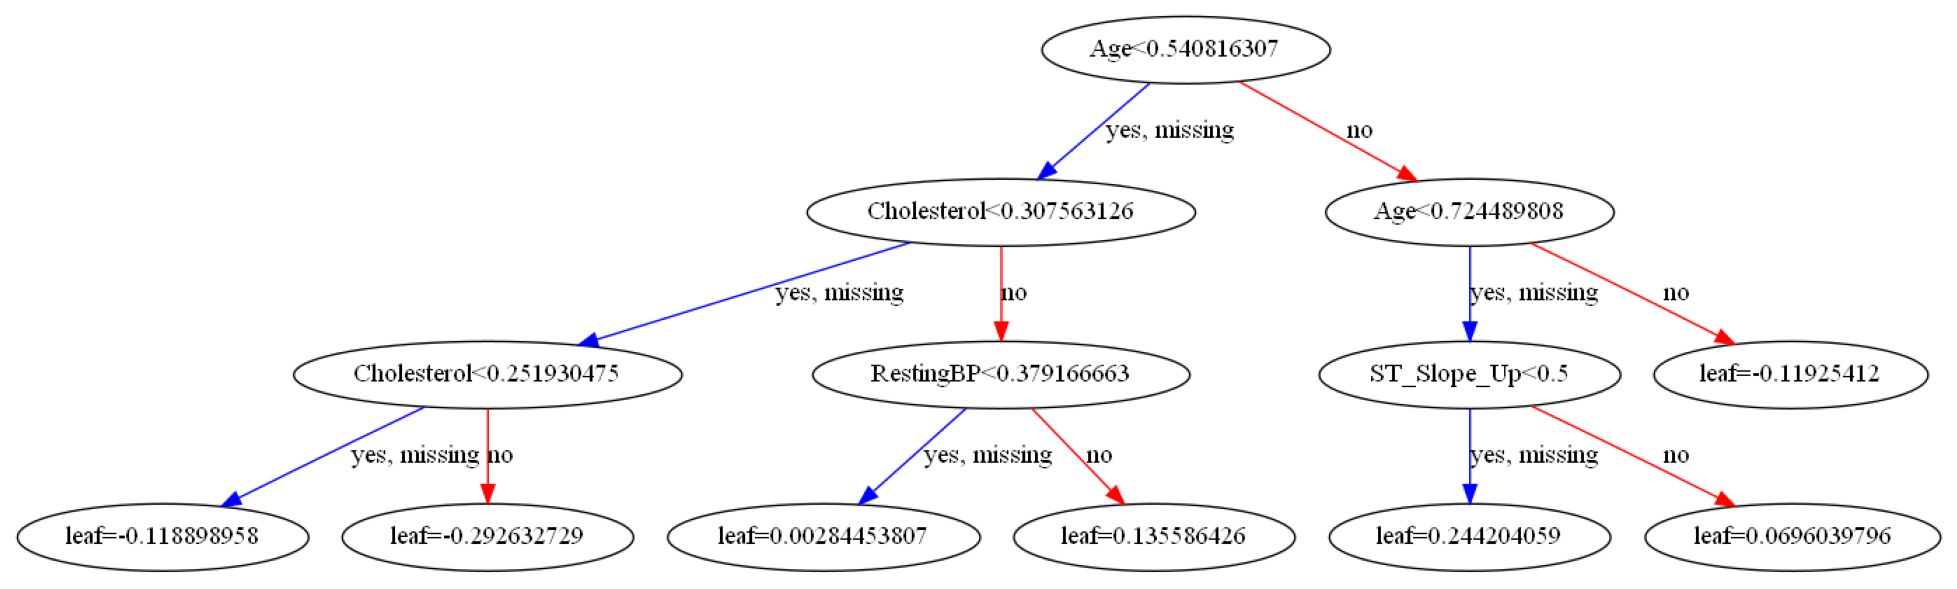

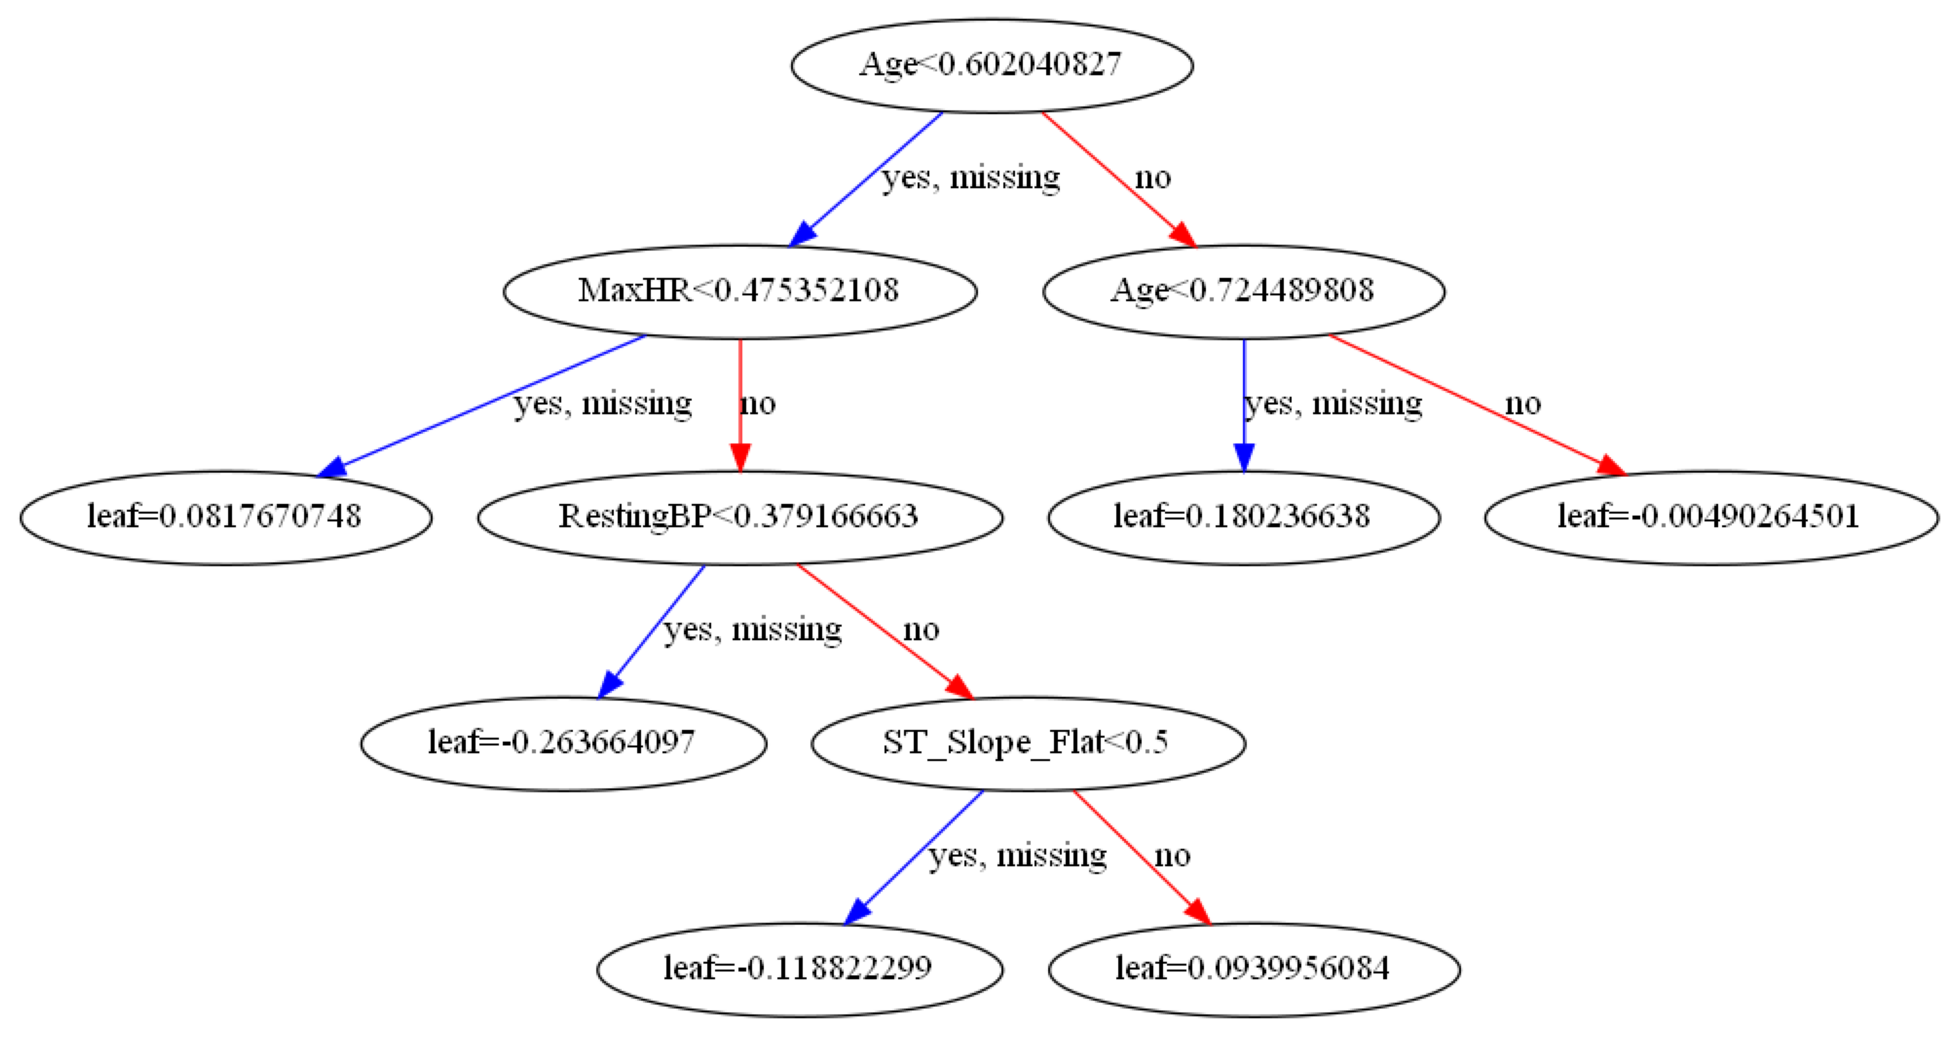

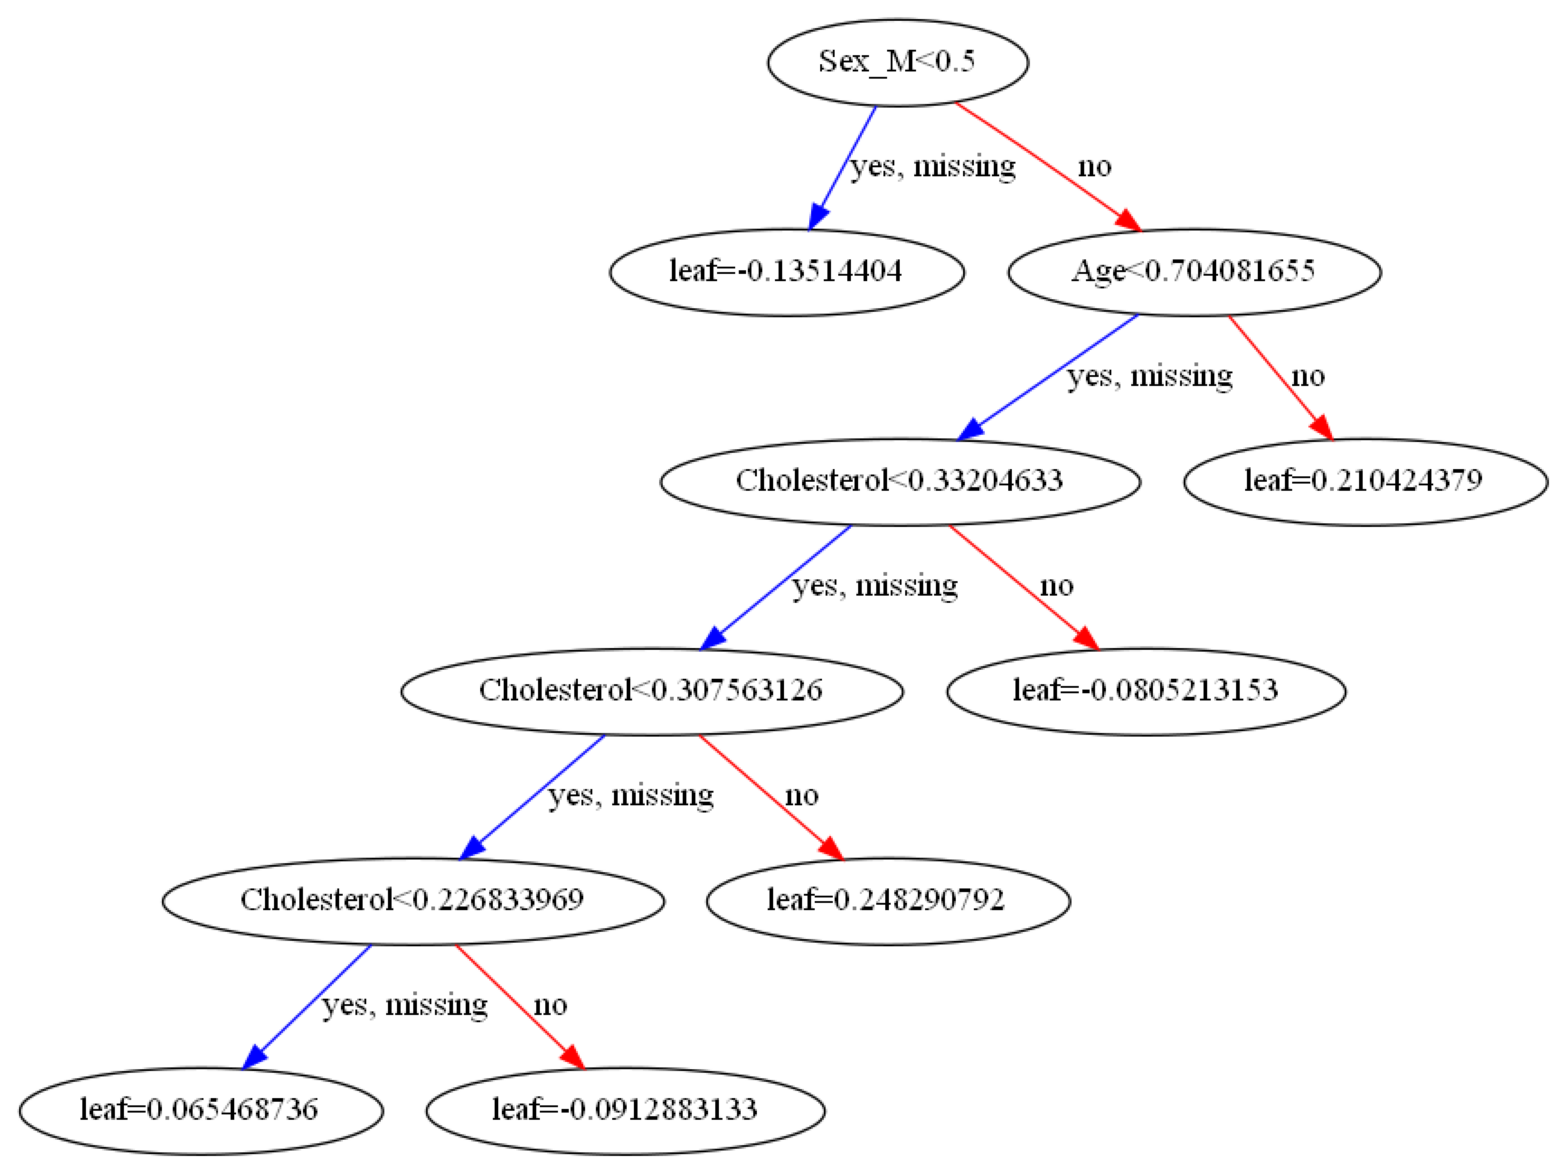

In [30]:
from xgboost import plot_tree
import matplotlib.pyplot as plt
i=0
while i<12:
    plot_tree(xgb,num_trees=i)
    plt.gcf().set_size_inches(25, 15)
    plt.show()
    i+=1

In [31]:
a=np.array([0.408163,0.69,0.354892,0.338028,0.465909,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0]).reshape(1,-1)
samp=xgb.predict(a)
samp

array([1])

In [32]:
#Decision Tree
from sklearn.tree import DecisionTreeClassifier
DCS= DecisionTreeClassifier(random_state=1,splitter='best',max_depth=4,min_samples_split=7)
DCS = DCS.fit(X_train,y_train)
Dcs_pred = DCS.predict(X_test)

In [33]:
import time
model = DCS
start=time.time()
param_grid = {'max_depth': [4,7,10,14,20,25,50],
             'splitter':['best','random'],
             'min_samples_split':[2,3,7,10]}

model, pred = algorithm_pipeline(X_train, X_test, y_train, y_test, model, 
                                 param_grid, cv=5)
end = time.time()
print(model.best_score_)
print(model.best_params_)
print("Time Taken with GridSearchCV:", end-start)

Fitting 5 folds for each of 56 candidates, totalling 280 fits
0.8371451419432226
{'max_depth': 4, 'min_samples_split': 2, 'splitter': 'random'}
Time Taken with GridSearchCV: 0.6447279453277588


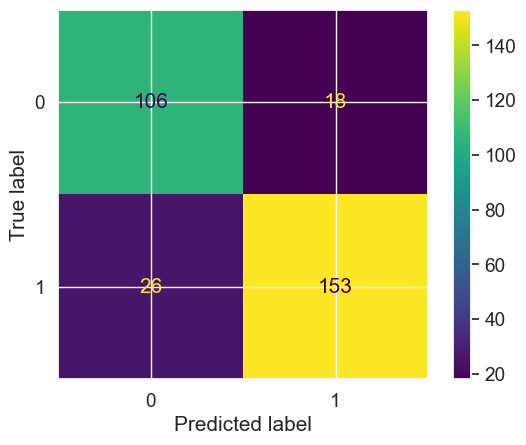

True Negatives:  106
False Positives:  18
False Negatives:  26
True Positives:  153
Accuracy: 0.8547854785478548
Precision: 0.8947368421052632
F1: 0.8742857142857143
MCCC: 0.7036524096717953


In [34]:
#Decision Tree Results
cm = confusion_matrix(y_test, Dcs_pred, labels=DCS .classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=DCS .classes_)
disp.plot()
plt.show()
tp, fn, fp, tn = confusion_matrix(y_true = y_test, y_pred = Dcs_pred, labels=[1,0]).reshape(-1)
print("True Negatives: ",tn)
print("False Positives: ",fp)
print("False Negatives: ",fn)
print("True Positives: ",tp)

accuray_dcs = accuracy_score(y_test, Dcs_pred)
print("Accuracy:", accuray_dcs)
precision_dcs = precision_score(y_test, Dcs_pred)
print("Precision:", precision_dcs)
f1_DCS=f1_score(y_test, Dcs_pred)
print("F1:", f1_DCS)
mcc_DCS = matthews_corrcoef(y_test, Dcs_pred)
print("MCCC:", mcc_DCS)

In [35]:
#Random Forest
from sklearn.ensemble import RandomForestClassifier
RFC = RandomForestClassifier(n_estimators=100,criterion='gini',random_state=1,max_depth=4)
RFC.fit(X_train,y_train)
RFC_pred = RFC.predict(X_test)

C:\Users\Van_P\AppData\Local\Temp\ipykernel_31448\2632127155.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  RFC.fit(X_train,y_train)


In [36]:
import time
model = RFC
start=time.time()
param_grid = {'n_estimators': [80,100],
             'criterion':['gini','entropy','log_loss'],
             'max_depth':[4,5,6]}

model, pred = algorithm_pipeline(X_train, X_test, y_train, y_test, model, 
                                 param_grid, cv=5)
end = time.time()
print(model.best_score_)
print(model.best_params_)
print("Time Taken with GridSearchCV:", end-start)

Fitting 5 folds for each of 18 candidates, totalling 90 fits
0.866453418632547
{'criterion': 'entropy', 'max_depth': 6, 'n_estimators': 100}
Time Taken with GridSearchCV: 2.1375460624694824


C:\Users\Van_P\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:909: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


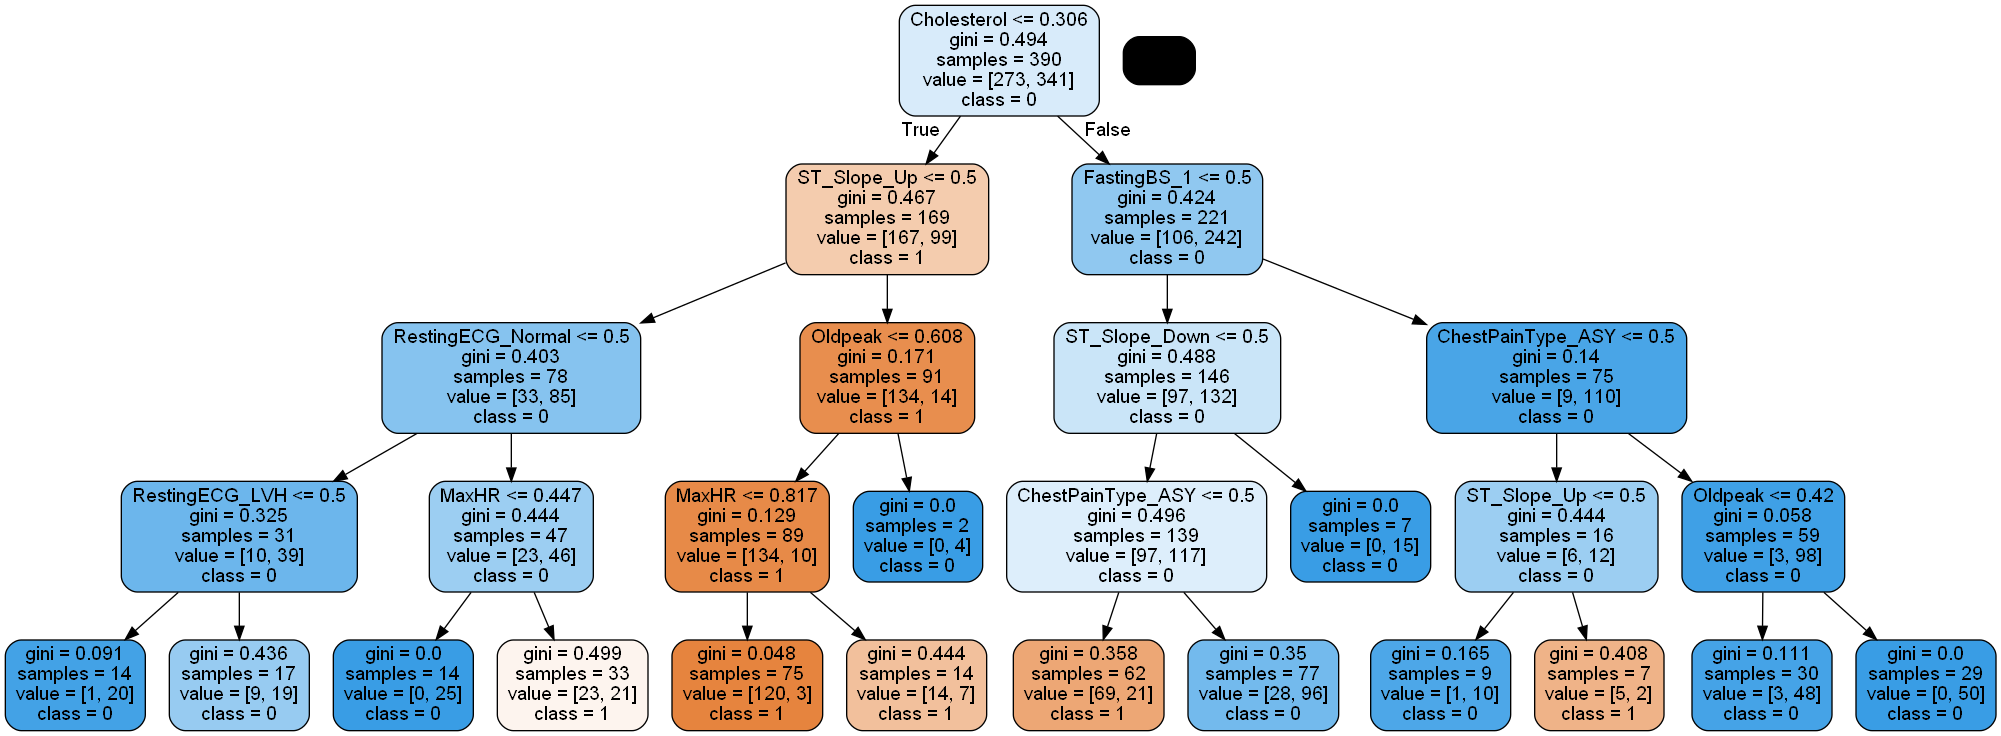

In [37]:
from sklearn.tree import export_graphviz
import pydotplus
from IPython.display import Image

dot_data = export_graphviz(RFC.estimators_[0], out_file=None, feature_names=X_train.columns, class_names=["1","0"], filled=True, rounded=True)
graph = pydotplus.graph_from_dot_data(dot_data)
graph.write_png("tree.png")
Image(graph.create_png())


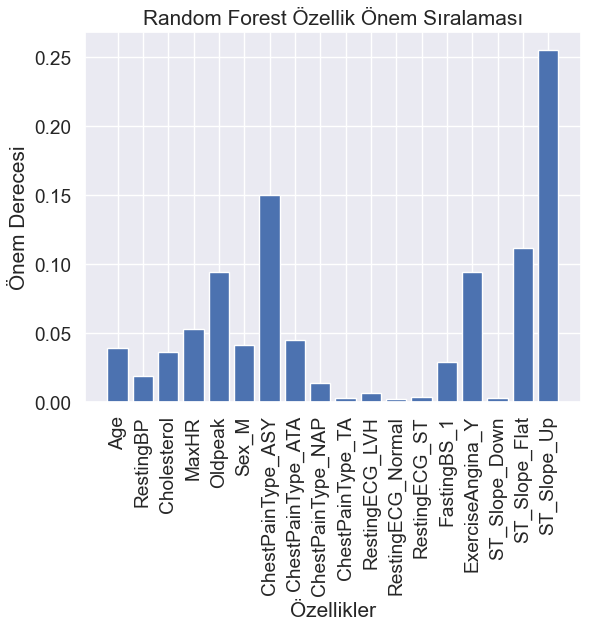

In [38]:
import matplotlib.pyplot as plt

feature_importances = RFC.feature_importances_

plt.bar(range(len(feature_importances)), feature_importances)
plt.xticks(range(len(feature_importances)), X_train.columns, rotation=90)
plt.xlabel("Özellikler")
plt.ylabel("Önem Derecesi")
plt.title("Random Forest Özellik Önem Sıralaması")
plt.show()

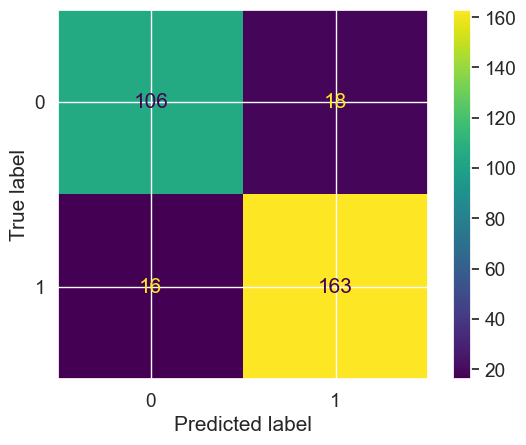

True Negatives:  106
False Positives:  18
False Negatives:  16
True Positives:  163
Accuracy: 0.8877887788778878
Precision: 0.9005524861878453
F1: 0.9055555555555554
MCCC: 0.7674265464465286


In [39]:
#RandomForest Results
cm = confusion_matrix(y_test, RFC_pred, labels=RFC .classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=RFC .classes_)
disp.plot()
plt.show()
tp, fn, fp, tn = confusion_matrix(y_true = y_test, y_pred = RFC_pred, labels=[1,0]).reshape(-1)
print("True Negatives: ",tn)
print("False Positives: ",fp)
print("False Negatives: ",fn)
print("True Positives: ",tp)

accuray_rfc = accuracy_score(y_test, RFC_pred)
print("Accuracy:", accuray_rfc)
precision_Rfc = precision_score(y_test, RFC_pred)
print("Precision:", precision_Rfc)
f1_rfc=f1_score(y_test, RFC_pred)
print("F1:", f1_rfc)
mcc_rfc = matthews_corrcoef(y_test, RFC_pred)
print("MCCC:", mcc_rfc)

In [40]:
#Logistic Regression
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression(class_weight='balanced',random_state=1,penalty='l2')
logreg.fit(X_train, y_train)
log_pred = logreg.predict(X_test)

C:\Users\Van_P\anaconda3\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


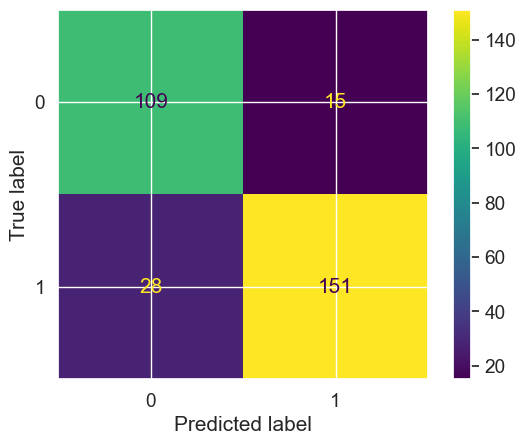

True Negatives:  109
False Positives:  15
False Negatives:  28
True Positives:  151
Accuracy: 0.858085808580858
Precision: 0.9096385542168675
F1: 0.8753623188405797
MCCC: 0.713880635722181


In [41]:
#Logistic Regression Results
cm = confusion_matrix(y_test, log_pred, labels=logreg .classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=logreg .classes_)
disp.plot()
plt.show()
tp, fn, fp, tn = confusion_matrix(y_true = y_test, y_pred = log_pred, labels=[1,0]).reshape(-1)
print("True Negatives: ",tn)
print("False Positives: ",fp)
print("False Negatives: ",fn)
print("True Positives: ",tp)

accuray_log = accuracy_score(y_test, log_pred)
print("Accuracy:", accuray_log)
precision_Log = precision_score(y_test, log_pred)
print("Precision:", precision_Log)
f1_log=f1_score(y_test, log_pred)
print("F1:", f1_log)
mcc_log = matthews_corrcoef(y_test, log_pred)
print("MCCC:", mcc_log)

In [42]:
#Gaussian Naive Bayes
from sklearn.naive_bayes import GaussianNB
NB = GaussianNB()
NB.fit(X_train, y_train)
NB_predicted = NB.predict(X_test)

C:\Users\Van_P\anaconda3\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


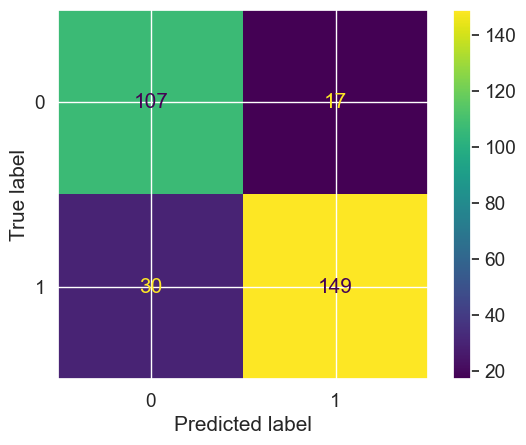

True Negatives:  107
False Positives:  17
False Negatives:  30
True Positives:  149
Accuracy: 0.8448844884488449
Precision: 0.8975903614457831
F1: 0.863768115942029
MCCC: 0.6869081520730981


In [43]:
#Gaussian Naive Bayes Results
cm = confusion_matrix(y_test, NB_predicted, labels=NB .classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=NB .classes_)
disp.plot()
plt.show()
tp, fn, fp, tn = confusion_matrix(y_true = y_test, y_pred = NB_predicted, labels=[1,0]).reshape(-1)
print("True Negatives: ",tn)
print("False Positives: ",fp)
print("False Negatives: ",fn)
print("True Positives: ",tp)

accuray_nb = accuracy_score(y_test, NB_predicted)
print("Accuracy:", accuray_nb)
precision_NB = precision_score(y_test, NB_predicted)
print("Precision:", precision_NB)
f1_nb=f1_score(y_test, NB_predicted)
print("F1:", f1_nb)
mcc_nb = matthews_corrcoef(y_test, NB_predicted)
print("MCCC:", mcc_nb)

In [44]:
#Neural Network
act_func = "relu"
# "softplus"
rate = 0.3
# build the model!
model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(500, input_shape=(X_train.shape[1],), activation=act_func)) # (features,)
model.add(tf.keras.layers.Dropout(rate))
model.add(tf.keras.layers.Dense(150, activation=act_func))
model.add(tf.keras.layers.Dropout(rate))
model.add(tf.keras.layers.Dense(45, activation=act_func))
model.add(tf.keras.layers.Dropout(rate))
model.add(tf.keras.layers.Dense(1, activation='sigmoid')) # output node
model.summary() # see what your model looks like
# compile the model
model.compile(optimizer=tf.keras.optimizers.legacy.Adam(), loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), metrics=['accuracy'])
#%% erken bitirme koşulu
# early stopping callback
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                    mode='min',
                   patience=20,
                    restore_best_weights = True)
 
#%% modelin eğitilmesi
 
# fit the model!
# attach it to a new variable called 'history' in case
# to look at the learning curves
history = model.fit(X_train, y_train,
                     validation_data = (X_test, y_test),
                     callbacks=[es],
                     epochs=250,
                     batch_size=30,
                     verbose=1)
 
#%% test
 
pred_NN = model.predict(X_test)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 500)               9500      
                                                                 
 dropout (Dropout)           (None, 500)               0         
                                                                 
 dense_1 (Dense)             (None, 150)               75150     
                                                                 
 dropout_1 (Dropout)         (None, 150)               0         
                                                                 
 dense_2 (Dense)             (None, 45)                6795      
                                                                 
 dropout_2 (Dropout)         (None, 45)                0         
                                                                 
 dense_3 (Dense)             (None, 1)                 4

C:\Users\Van_P\anaconda3\lib\site-packages\keras\backend.py:5703: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


21/21 [==============================] - 1s 14ms/step - loss: 0.5737 - accuracy: 0.7117 - val_loss: 0.3988 - val_accuracy: 0.8680
Epoch 2/250
21/21 [==============================] - 0s 5ms/step - loss: 0.4151 - accuracy: 0.8420 - val_loss: 0.3255 - val_accuracy: 0.8680


C:\Users\Van_P\anaconda3\lib\site-packages\keras\backend.py:5703: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


Epoch 3/250
21/21 [==============================] - 0s 5ms/step - loss: 0.3781 - accuracy: 0.8355 - val_loss: 0.3346 - val_accuracy: 0.8647
Epoch 4/250
21/21 [==============================] - 0s 5ms/step - loss: 0.3697 - accuracy: 0.8534 - val_loss: 0.3363 - val_accuracy: 0.8680
Epoch 5/250
21/21 [==============================] - 0s 5ms/step - loss: 0.3466 - accuracy: 0.8616 - val_loss: 0.3327 - val_accuracy: 0.8548
Epoch 6/250
21/21 [==============================] - 0s 5ms/step - loss: 0.3699 - accuracy: 0.8518 - val_loss: 0.3234 - val_accuracy: 0.8746
Epoch 7/250
21/21 [==============================] - 0s 5ms/step - loss: 0.3372 - accuracy: 0.8681 - val_loss: 0.3490 - val_accuracy: 0.8548
Epoch 8/250
21/21 [==============================] - 0s 4ms/step - loss: 0.3344 - accuracy: 0.8697 - val_loss: 0.3468 - val_accuracy: 0.8614
Epoch 9/250
21/21 [==============================] - 0s 5ms/step - loss: 0.3265 - accuracy: 0.8746 - val_loss: 0.3473 - val_accuracy: 0.8581
Epoch 10/250


In [45]:
Pred_NN = pd.DataFrame(pred_NN, columns = ['HeartDisease'])
n=0
while n<len(Pred_NN):
    if Pred_NN.iloc[n,0]<0.5:
        Pred_NN.iloc[n,0]=0
    else:
        Pred_NN.iloc[n,0]=1
    n+=1
Pred_NN

HeartDisease
0             0.0
1             1.0
2             0.0
3             0.0
4             1.0
..            ...
298           1.0
299           0.0
300           0.0
301           0.0
302           1.0

[303 rows x 1 columns]

In [46]:
tp, fn, fp, tn = confusion_matrix(y_true = y_test, y_pred = Pred_NN, labels=[1,0]).reshape(-1)
print("True Negatives: ",tn)
print("False Positives: ",fp)
print("False Negatives: ",fn)
print("True Positives: ",tp)

accuray_nn = accuracy_score(y_test, Pred_NN)
print("Accuracy:", accuray_nn)
precision_NN = precision_score(y_test, Pred_NN)
print("Precision:", precision_NN)
f1_nn=f1_score(y_test, Pred_NN)
print("F1:", f1_nn)
mcc_nn = matthews_corrcoef(y_test, Pred_NN)
print("MCCC:", mcc_nn)

True Negatives:  102
False Positives:  22
False Negatives:  16
True Positives:  163
Accuracy: 0.8745874587458746
Precision: 0.8810810810810811
F1: 0.8956043956043956
MCCC: 0.7393159669681816


In [47]:
#KNN
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=10,weights='distance',leaf_size=10)
knn.fit(X_train, y_train)
KNN_pred = knn.predict(X_test)

C:\Users\Van_P\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


In [48]:
import time
model = knn
start=time.time()
param_grid = {'n_neighbors': [2,3,5,8,10],
             'weights':['distance','uniform'],
             'leaf_size':[10,20,30,50,100]}

model, pred = algorithm_pipeline(X_train, X_test, y_train, y_test, model, 
                                 param_grid, cv=5)
end = time.time()
print(model.best_score_)
print(model.best_params_)
print("Time Taken with GridSearchCV:", end-start)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
0.8566440090630415
{'leaf_size': 10, 'n_neighbors': 10, 'weights': 'distance'}
Time Taken with GridSearchCV: 1.1402130126953125


C:\Users\Van_P\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


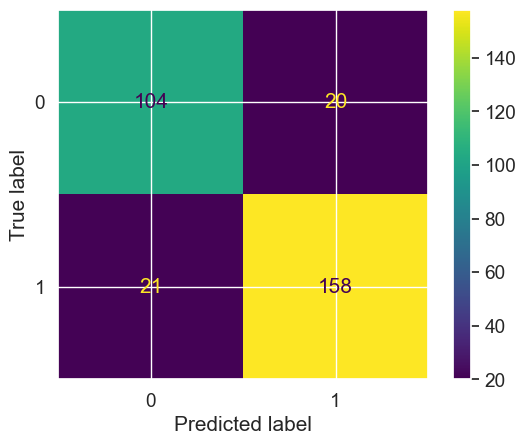

True Negatives:  104
False Positives:  20
False Negatives:  21
True Positives:  158
Accuracy: 0.8646864686468647
Precision: 0.8876404494382022
F1: 0.8851540616246498
MCCC: 0.7205153137669609


In [49]:
cm = confusion_matrix(y_test, KNN_pred, labels=knn .classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=knn .classes_)
disp.plot()
plt.show()
tp, fn, fp, tn = confusion_matrix(y_true = y_test, y_pred = KNN_pred, labels=[1,0]).reshape(-1)
print("True Negatives: ",tn)
print("False Positives: ",fp)
print("False Negatives: ",fn)
print("True Positives: ",tp)

accuray_knn = accuracy_score(y_test, KNN_pred)
print("Accuracy:", accuray_knn)
precision_kNN = precision_score(y_test, KNN_pred)
print("Precision:", precision_kNN)
f1_knn=f1_score(y_test, KNN_pred)
print("F1:", f1_knn)
mcc_knn = matthews_corrcoef(y_test, KNN_pred)
print("MCCC:", mcc_knn)